# Семантическая сегментация на PyTorch
## Задачи
1) Прочитать статью BiSeNet https://arxiv.org/abs/1808.00897

2) Загрузить датасет https://drive.google.com/open?id=1MOTVekem9o6PyEaXnuzYuzq8HdzNpHnC

3) Реализовать архитектуру BiSeNet, заполнив пропуски в шаблоне ниже, и применить её для задачи сегментации эллипсов

4) Реализовать и подсчитать метрику качества (любую из нижепреведенных) по валидационному датасету, построить графики в TensorBoard

* пиксельная точность (pixel accuracy): $\sum_{c=1}^{N_c}{n_{cc}}~/~\sum_{c=1}^{N_c}{n_c}$;

* средняя точность (mean accuracy): $\frac{1}{N_c}\sum_{c=1}^{N_c}{(n_{cc}~/~n_c)}$;

* средний коэффициент Жаккара (mean intersection over union): $\frac{1}{N_c}\sum_{c=1}^{N_c}{[n_{cc}~/~(n_c+\sum_{c'}^{N_c}{n_{c'c}}-n_{cc})]}$;

где: 
* $N_c$ - число классов в эталонной разметке для рассматриваемого изображения;
* $n_{ij}$ - число пикселей класса $i$, с предсказанным классом $j$ на рассматриваемом изображении;
* $n_c=\sum_{j}^{N_c}{n_{cj}}$ - общее число пикселей с эталонным классом $c$ на рассматриваемом изображении.

5) Визуализировать результат работы сети на нескольких изображениях


In [1]:
from tqdm import tqdm
import numpy as np
from skimage.io import imread
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

import os
from glob import glob

%matplotlib inline

In [2]:
debug = False

### Датасеты для обучения и тестирования

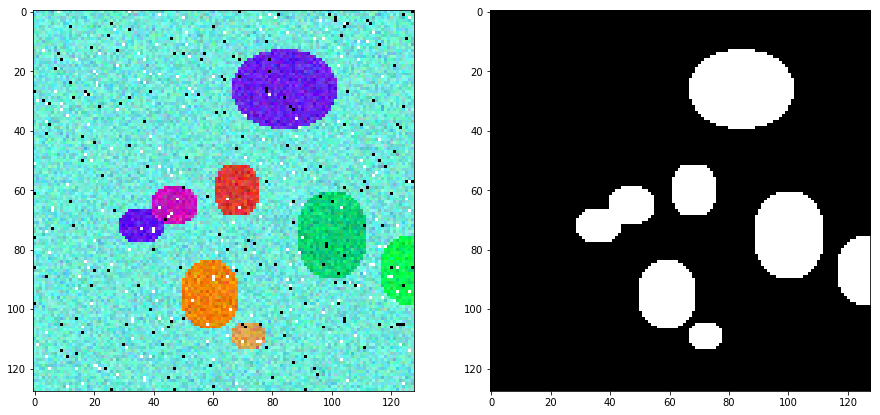

In [3]:
class Ellipses(Dataset):
    def __init__(self, path):
        self.transform = torchvision.transforms.ToTensor()
        self.imgs = [imread(x) for x in glob(os.path.join(path,'imgs/*.png'))]
        self.masks = [imread(x)[:, :, np.newaxis] for x in glob(os.path.join(path,'masks/*.png'))]
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        mask = self.masks[idx]
        return self.transform(img), self.transform(mask)
    
# Datasets
data_train = Ellipses("ellipse_database/train/")
data_eval = Ellipses("ellipse_database/eval/")

# Example images
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(data_train[0][0].cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 2, 2)
_ = plt.imshow(data_train[0][1][0, :, :].cpu().numpy(), cmap='gray')

https://towardsdatascience.com/bisenet-for-real-time-segmentation-part-iii-f2b40ba4e177

### Описание модели BiSeNet

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


class ConvBnRelu(nn.Module):
    def __init__(self, in_planes, out_planes, ksize, stride, pad, dilation=1,
                 groups=1, has_bn=True, norm_layer=nn.BatchNorm2d, bn_eps=1e-5,
                 has_relu=True, inplace=True, has_bias=False):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=ksize,
                              stride=stride, padding=pad,
                              dilation=dilation, groups=groups, bias=has_bias)
        self.has_bn = has_bn
        if self.has_bn:
            self.bn = norm_layer(out_planes, eps=bn_eps)
        self.has_relu = has_relu
        if self.has_relu:
            self.relu = nn.ReLU(inplace=inplace)

    def forward(self, x):
        x = self.conv(x)
        if self.has_bn:
            x = self.bn(x)
        if self.has_relu:
            x = self.relu(x)

        return x


# For BiSeNet
class AttentionRefinement(nn.Module):
    def __init__(self, in_planes, out_planes,
                 norm_layer=nn.BatchNorm2d):
        super(AttentionRefinement, self).__init__()
        self.conv_3x3 = ConvBnRelu(in_planes, out_planes, 3, 1, 1,
                                   has_bn=True, norm_layer=norm_layer,
                                   has_relu=True, has_bias=False)
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(out_planes, out_planes, 1, 1, 0,
                       has_bn=True, norm_layer=norm_layer,
                       has_relu=False, has_bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        fm = self.conv_3x3(x)
        fm_se = self.channel_attention(fm)
        fm = fm * fm_se

        return fm


class FeatureFusion(nn.Module):
    def __init__(self, in_planes, out_planes,
                 reduction=1, norm_layer=nn.BatchNorm2d):
        super(FeatureFusion, self).__init__()
        self.conv_1x1 = ConvBnRelu(in_planes, out_planes, 1, 1, 0,
                                   has_bn=True, norm_layer=norm_layer,
                                   has_relu=True, has_bias=False)
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(out_planes, out_planes // reduction, 1, 1, 0,
                       has_bn=False, norm_layer=norm_layer,
                       has_relu=True, has_bias=False),
            ConvBnRelu(out_planes // reduction, out_planes, 1, 1, 0,
                       has_bn=False, norm_layer=norm_layer,
                       has_relu=False, has_bias=False),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        fm = torch.cat([x1, x2], dim=1)
        fm = self.conv_1x1(fm)
        fm_se = self.channel_attention(fm)
        output = fm + fm * fm_se
       
        return output


class ResNetEncoder(nn.Module):
    """ Encoder based on ResNet model.
    
    Attributes:
        n_channels_x16 (int): number of channels in feature map after 3rd block.
        n_channels_x32 (int): number of channels in feature map after 4th block.
    """
    def __init__(self, _resnet):
        """ Init.
    
            Args:
                _resnet: resnet model from torchvision.models.
        """
        super().__init__()
        if _resnet == None:
            resnet = models.resnet18(pretrained=True)
            self.backbone = resnet
        else:
            self.backbone = _resnet
        
        self.conv1 = self.backbone.conv1
        self.bn1 = self.backbone.bn1
        self.relu = self.backbone.relu
        self.maxpool = self.backbone.maxpool
        self.layer1 = self.backbone.layer1
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4
        self.n_channels_x16 = 256
        self.n_channels_x32 = 512


    def forward(self, x):
        """ Forward pass.
    
            Attributes:
                x (torch.Tensor): input tensor.
                
            Returns:
                x16_feats (torch.Tensor): feature map after 3rd block.
                x32_feats (torch.Tensor): feature map after 4th block.
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(self.bn1(x))
        x = self.maxpool(x)
        feature1 = self.layer1(x)             # 1 / 4
        feature2 = self.layer2(feature1)      # 1 / 8
        x16_feats = self.layer3(feature2)     # 1 / 16
        x32_feats = self.layer4(x16_feats)    # 1 / 32
              
        blocks = [feature2, x16_feats, x32_feats]

        return blocks

class BiSeNet(nn.Module):
    def __init__(self, out_planes = 2, pretrained_model=None,
                 norm_layer=nn.BatchNorm2d):
        """
        If pretrained model == None - use ImageNet-1000 ResNet50
        """   
        super(BiSeNet, self).__init__()
        
        self.context_path = ResNetEncoder(pretrained_model)

        self.business_layer = []

        self.spatial_path = SpatialPath(3, 128, norm_layer)

        conv_channel = 128
        self.global_context = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(512, conv_channel, 1, 1, 0,
                       has_bn=True,
                       has_relu=True, has_bias=False, norm_layer=norm_layer)
        )

        # stage = [512, 256, 128, 64]
        arms = [AttentionRefinement(512, conv_channel, norm_layer),
                AttentionRefinement(256, conv_channel, norm_layer)]
        refines = [ConvBnRelu(conv_channel, conv_channel, 3, 1, 1,
                              has_bn=True, norm_layer=norm_layer,
                              has_relu=True, has_bias=False),
                   ConvBnRelu(conv_channel, conv_channel, 3, 1, 1,
                              has_bn=True, norm_layer=norm_layer,
                              has_relu=True, has_bias=False)]

        heads = [BiSeNetHead(conv_channel, out_planes, 2,
                             True, norm_layer),
                 BiSeNetHead(conv_channel, out_planes, 1,
                             True, norm_layer),
                 BiSeNetHead(conv_channel * 2, out_planes, 1,
                             False, norm_layer)]

        self.ffm = FeatureFusion(conv_channel * 2, conv_channel * 2,
                                 1, norm_layer)

        self.arms = nn.ModuleList(arms)
        self.refines = nn.ModuleList(refines)
        self.heads = nn.ModuleList(heads)

        self.business_layer.append(self.spatial_path)
        self.business_layer.append(self.global_context)
        self.business_layer.append(self.arms)
        self.business_layer.append(self.refines)
        self.business_layer.append(self.heads)
        self.business_layer.append(self.ffm)

    def forward(self, data, label=None):
        spatial_out = self.spatial_path(data)

        context_blocks = self.context_path(data)
        context_blocks.reverse()

        global_context = self.global_context(context_blocks[0])
        global_context = F.interpolate(global_context,
                                       size=context_blocks[0].size()[2:],
                                       mode='bilinear', align_corners=True)

        last_fm = global_context
        pred_out = []

        for i, (fm, arm, refine) in enumerate(zip(context_blocks[:2], self.arms,
                                                  self.refines)):
            fm = arm(fm)
            fm += last_fm
            last_fm = F.interpolate(fm, size=(context_blocks[i + 1].size()[2:]),
                                    mode='bilinear', align_corners=True)
            last_fm = refine(last_fm)
            pred_out.append(last_fm)
        context_out = last_fm

        concate_fm = self.ffm(spatial_out, context_out)
        pred_out.append(concate_fm)
        if debug:
            print('Final vector')
            print(concate_fm.shape)
        return self.heads[-1](pred_out[2]), self.heads[0](pred_out[0]), self.heads[1](pred_out[1])


class SpatialPath(nn.Module):
    def __init__(self, in_planes, out_planes, norm_layer=nn.BatchNorm2d):
        super(SpatialPath, self).__init__()
        inner_channel = 64
        self.conv_7x7 = ConvBnRelu(in_planes, inner_channel, 7, 2, 3,
                                   has_bn=True, norm_layer=norm_layer,
                                   has_relu=True, has_bias=False)
        self.conv_3x3_1 = ConvBnRelu(inner_channel, inner_channel, 3, 2, 1,
                                     has_bn=True, norm_layer=norm_layer,
                                     has_relu=True, has_bias=False)
        self.conv_3x3_2 = ConvBnRelu(inner_channel, inner_channel, 3, 2, 1,
                                     has_bn=True, norm_layer=norm_layer,
                                     has_relu=True, has_bias=False)
        self.conv_1x1 = ConvBnRelu(inner_channel, out_planes, 1, 1, 0,
                                   has_bn=True, norm_layer=norm_layer,
                                   has_relu=True, has_bias=False)

    def forward(self, x):
        x = self.conv_7x7(x)
        x = self.conv_3x3_1(x)
        x = self.conv_3x3_2(x)
        output = self.conv_1x1(x)

        return output


class BiSeNetHead(nn.Module):
    def __init__(self, in_planes, out_planes, scale,
                 is_aux=False, norm_layer=nn.BatchNorm2d):
        super(BiSeNetHead, self).__init__()
        if is_aux:
            self.conv_3x3 = ConvBnRelu(in_planes, 128, 3, 1, 1,
                                       has_bn=True, norm_layer=norm_layer,
                                       has_relu=True, has_bias=False)
        else:
            self.conv_3x3 = ConvBnRelu(in_planes, 64, 3, 1, 1,
                                       has_bn=True, norm_layer=norm_layer,
                                       has_relu=True, has_bias=False)
        # self.dropout = nn.Dropout(0.1)
        if is_aux:
            self.conv_1x1 = nn.Conv2d(128, out_planes, kernel_size=1,
                                      stride=1, padding=0)
        else:
            self.conv_1x1 = nn.Conv2d(64, out_planes, kernel_size=1,
                                      stride=1, padding=0)
        self.scale = scale

    def forward(self, x):
        fm = self.conv_3x3(x)
        # fm = self.dropout(fm)
        output = self.conv_1x1(fm)
        if self.scale > 1:
            output = F.interpolate(output, scale_factor=self.scale,
                                   mode='bilinear',
                                   align_corners=True)

        return output

### Обучение и тестирование

In [73]:
def prepare_masks(masks, with_aux=True):
    """ Make binary mask for background and object, then interpolate to smaller dimensions for auxillary losses. 
    
    Args:
        masks (torch.Tensor): gt masks, batch_size x H x W.
        with_aux (bool, optional): flag to return auxillary masks.
        
    Returns:
        masks (torch.Tensor): batch_size x 2 x H x W mask for background and object.
        masks_16 (torch.Tensor, optional): interpolated 'masks' for auxillary loss.
        masks_32 (torch.Tensor, optional): interpolated 'masks' for auxillary loss.
    """
    if debug:
        print('masks shape')
        print(masks.shape)
    
    if with_aux:
 
        scale_factor = 1/8
        masks_16 = F.interpolate(masks, scale_factor=scale_factor, mode='nearest')
        masks_32 = F.interpolate(masks, scale_factor=scale_factor, mode='nearest')
        masks = F.interpolate(masks, scale_factor=scale_factor, mode='nearest')
        
        masks = torch.cat((1-masks, masks), dim=1)
        masks_16 = torch.cat((1-masks_16, masks_16), dim=1)
        masks_32 = torch.cat((1-masks_32, masks_32), dim=1)

        return (masks, masks_16, masks_32)
    else:
        masks = torch.cat((1-masks, masks), dim=1)
        
        return masks
    
 

In [42]:
# Calculates class intersections over unions
def iou(pred, target, num_classes = 2):
    ious = []
    # Ignore IoU for background class
    for cls in range(num_classes - 1):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().data.cpu()[0]  # Cast to long to prevent overflows
        union = pred_inds.long().sum().data.cpu()[0] + target_inds.long().sum().data.cpu()[0] - intersection
        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append(intersection / max(union, 1))
    return ious

In [44]:
def iou(pred, target, n_classes = 1):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().data.cpu()[0]  # Cast to long to prevent overflows
        union = pred_inds.long().sum().data.cpu()[0] + target_inds.long().sum().data.cpu()[0] - intersection
        if union == 0:
             ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
             ious.append(float(intersection) / float(max(union, 1)))
    return np.array(ious)

In [36]:
def iou_numpy(outputs: np.array, labels: np.array):
    outputs = outputs.squeeze(1)
    
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded  # Or thresholded.mean()

In [27]:
SMOOTH = 1e-6
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    # outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).int().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [46]:
def train_step(model, optimizer, train_loader, criterions, device):
    """ One epoch of training. 
    
    Args:
        model: instance of BiSeNet class.
        optimizer: torch.optim.Adam.
        train_loader (torch.DataLoader): dataloader for training data.
        criterions (list): list of criterions (main and auxillary losses).
        device (torch.device): cuda if avaliable.
        
    Returns:
        mean_loss (float): mean loss for an epoch.
        mean_acc (float): mean accuracy for an epoch.
    """
    model.train()
    
    mean_loss = 0
    mean_acc = 0
    total = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for i, (images, masks) in pbar:
        # Place on gpu
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device)
        
        # Forward pass
        outputs, side_out_16, side_out_32 = model(images)
        if debug:
            print('outputs')
            print(outputs.shape)
            print('out_16')
            print(side_out_16.shape)
            print('out_32')
            print(side_out_32.shape)
        
        # Loss calculation
        loss_masks = prepare_masks(masks, with_aux=True)
        loss = criterions[0](outputs, loss_masks[0])
        loss += criterions[1](side_out_16, loss_masks[1])
        loss += criterions[2](side_out_32, loss_masks[2])
        print('done')
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Some statistics
        mean_loss += loss.item()
        mean_acc += get_acc(outputs, masks)
        total += masks.size(0)
        pbar.set_description(f"Loss {mean_loss/total:.5f} | Acc {mean_acc/total:.4f} |")
    
    pbar.close()
    
    return (mean_loss / total, mean_acc / total)


def eval_step(model, eval_loader, criterions, device):
    """ Evaluation of the model. 
    
    Args:
        model: instance of BiSeNet class.
        eval_loader (torch.DataLoader): dataloader for evaluation data.
        criterions (list): list of criterions (main and auxillary losses).
        device (torch.device): cuda if avaliable.
        
    Returns:
        mean_loss (float): mean loss for an evaluation data.
        mean_acc (float): mean accuracy for an evaluation data.
    """
    model.eval()
 
    with torch.no_grad():
        mean_loss = 0
        mean_acc = 0
        total = 0
        for i, (images, masks) in enumerate(eval_loader):
            # Place on gpu
            images = images.to(device, dtype=torch.float)
            masks = masks.to(device)

            # Forward pass
            outputs, side_out_16, side_out_32 = model(images)

            # Loss calculation
            loss_masks = prepare_masks(masks, with_aux=True)
            loss = criterions[0](outputs, loss_masks[0])
            loss += criterions[1](side_out_16, loss_masks[1])
            loss += criterions[2](side_out_32, loss_masks[2])
            
            # Some statistics
            mean_loss += loss.item()
            mean_acc += get_acc(outputs, masks)
            total += masks.size(0)
            
    return (mean_loss / total, mean_acc / total)


def get_acc(pred, mask):
    scale_factor = mask.shape[2]/pred.shape[2]
    masks_16 = F.interpolate(mask, scale_factor=1/scale_factor, mode='nearest')
    #return iou(pred, masks_16)
    return 0

#def log_loss_acc(writer, epoch, train_qual, test_qual):
    # ================================== YOUR CODE HERE ==================================
    # ====================================================================================
    

def train(model, opt, train_loader, eval_loader, criterions, n_epochs, device, logdir):
    # ================================== YOUR CODE HERE ==================================
    # Don't forget to initialize and close tensorboard writer
    # ====================================================================================
    for epoch in range(n_epochs):
        train_qual = train_step(model, opt, train_loader, criterions, device)
        
        test_qual = eval_step(model, eval_loader, criterions, device)
        
        #log_loss_acc(writer, epoch, train_qual, test_qual)
        
        print(f'Epoch [{epoch+1}/{n_epochs}] | Loss (train/test): {train_qual[0]:.4f}/{test_qual[0]:.4f} '+\
               f' | Acc (train/test): {train_qual[1]:.4f}/{test_qual[1]:.4f}')

## Setup Hyperparameters

In [10]:
class_number = 2
LR = 0.001# Set desired learning rate
B_SIZE = 8# Set desired batch size
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
epochs = 10

In [11]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(dataset=data_train,
                                           batch_size=B_SIZE, 
                                           shuffle=True)
eval_loader = torch.utils.data.DataLoader(dataset=data_eval,
                                          batch_size=B_SIZE, 
                                          shuffle=False)

In [52]:
model_dir = os.path.join('.', 'model')
if (not os.path.exists(model_dir)):
    os.mkdir(model_dir)
model_st_path = os.path.join('.', model_dir, 'state_bisenet_rs18.pth')
model_path = os.path.join('.', model_dir, 'bisenet_rs18.pth')

In [60]:
model = torch.load(model_path)
model.load_state_dict(torch.load(model_st_path))
model.eval()

BiSeNet(
  (context_path): ResNetEncoder(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo

In [20]:
# Model definition
if model == None:
    model = BiSeNet(class_number).to(device)

### Запуск

In [72]:
# Loss and optimizer
criterions = [nn.BCEWithLogitsLoss(), nn.BCEWithLogitsLoss(), nn.BCEWithLogitsLoss()]
optimizer = torch.optim.Adam(model.parameters(), lr=LR)                    
# Train
train(model, optimizer, train_loader, eval_loader, criterions, epochs, device, './logdir/resnet')














  0%|                                                                                    | 0/250 [00:00<?, ?it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00592 | Acc 0.0000 |:   0%|                                                       | 0/250 [00:00<?, ?it/s]












Loss 0.00592 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<02:00,  2.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00535 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<02:00,  2.07it/s]












Loss 0.00535 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<01:35,  2.60it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00676 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<01:35,  2.60it/s]












Loss 0.00676 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<01:15,  3.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00700 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<01:15,  3.27it/s]












Loss 0.00700 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<01:01,  3.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00701 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:01<01:01,  3.99it/s]












Loss 0.00701 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:01<00:52,  4.71it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:01<00:52,  4.71it/s]












Loss 0.00643 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:01<00:47,  5.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00689 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:01<00:47,  5.19it/s]












Loss 0.00689 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:01<00:42,  5.70it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00692 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:01<00:42,  5.70it/s]












Loss 0.00692 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:39,  6.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00739 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:39,  6.20it/s]












Loss 0.00739 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:36,  6.65it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00736 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:36,  6.65it/s]












Loss 0.00736 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:34,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00732 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:34,  7.00it/s]












Loss 0.00732 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:34,  6.89it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00706 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:34,  6.89it/s]












Loss 0.00706 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:33,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00706 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:02<00:33,  7.20it/s]












Loss 0.00706 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:02<00:31,  7.41it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00687 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:02<00:31,  7.41it/s]












Loss 0.00687 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:02<00:31,  7.55it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00678 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:02<00:31,  7.55it/s]












Loss 0.00678 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:31,  7.57it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00672 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:31,  7.57it/s]












Loss 0.00672 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:31,  7.54it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00674 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:31,  7.54it/s]












Loss 0.00674 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:35,  6.48it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00674 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:35,  6.48it/s]












Loss 0.00674 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:37,  6.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00662 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:37,  6.17it/s]












Loss 0.00662 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:36,  6.41it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00675 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:03<00:36,  6.41it/s]












Loss 0.00675 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:03<00:33,  6.79it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00676 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:03<00:33,  6.79it/s]












Loss 0.00676 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:03<00:32,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00686 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:03<00:32,  7.02it/s]












Loss 0.00686 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:31,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00684 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:31,  7.19it/s]












Loss 0.00684 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:31,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00689 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:31,  7.16it/s]












Loss 0.00689 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:30,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00705 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:30,  7.34it/s]












Loss 0.00705 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:30,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00704 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:30,  7.36it/s]












Loss 0.00704 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:30,  7.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00704 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:04<00:30,  7.39it/s]












Loss 0.00704 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:04<00:30,  7.43it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00707 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:04<00:30,  7.43it/s]












Loss 0.00707 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:30,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00720 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:30,  7.34it/s]












Loss 0.00720 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:29,  7.43it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00715 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:29,  7.43it/s]












Loss 0.00715 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:28,  7.62it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00710 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:28,  7.62it/s]












Loss 0.00710 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:28,  7.64it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00707 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:28,  7.64it/s]












Loss 0.00707 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:28,  7.61it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00700 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:28,  7.61it/s]












Loss 0.00700 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:27,  7.77it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00693 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:27,  7.77it/s]












Loss 0.00693 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:27,  7.81it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00690 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:05<00:27,  7.81it/s]












Loss 0.00690 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:05<00:29,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00693 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:05<00:29,  7.33it/s]












Loss 0.00693 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:37,  5.75it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00689 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:37,  5.75it/s]












Loss 0.00689 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:39,  5.43it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00691 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:39,  5.43it/s]












Loss 0.00691 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:38,  5.44it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00690 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:38,  5.44it/s]












Loss 0.00690 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:36,  5.77it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00688 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:06<00:36,  5.77it/s]












Loss 0.00688 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:06<00:34,  6.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00690 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:06<00:34,  6.01it/s]












Loss 0.00690 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:06<00:33,  6.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00688 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:06<00:33,  6.23it/s]












Loss 0.00688 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:06<00:32,  6.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00692 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:06<00:32,  6.39it/s]












Loss 0.00692 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:31,  6.55it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00693 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:31,  6.55it/s]












Loss 0.00693 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:31,  6.56it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00692 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:31,  6.56it/s]












Loss 0.00692 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:30,  6.76it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00696 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:30,  6.76it/s]












Loss 0.00696 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:29,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00704 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:07<00:29,  6.97it/s]












Loss 0.00704 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:07<00:28,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00703 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:07<00:28,  7.11it/s]












Loss 0.00703 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:07<00:27,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00704 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:07<00:27,  7.21it/s]












Loss 0.00704 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:07<00:27,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00701 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:07<00:27,  7.29it/s]












Loss 0.00701 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:27,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00702 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:27,  7.26it/s]












Loss 0.00702 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:29,  6.81it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00702 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:29,  6.81it/s]












Loss 0.00702 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:29,  6.61it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00703 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:29,  6.61it/s]












Loss 0.00703 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:28,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00707 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:08<00:28,  6.93it/s]












Loss 0.00707 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:08<00:27,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00710 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:08<00:27,  7.16it/s]












Loss 0.00710 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:08<00:27,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00714 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:08<00:27,  7.14it/s]












Loss 0.00714 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:08<00:29,  6.68it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00715 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:08<00:29,  6.68it/s]












Loss 0.00715 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:30,  6.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00714 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:30,  6.36it/s]












Loss 0.00714 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:30,  6.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00712 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:30,  6.35it/s]












Loss 0.00712 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:31,  6.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00713 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:09<00:31,  6.06it/s]












Loss 0.00713 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:09<00:30,  6.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00713 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:09<00:30,  6.31it/s]












Loss 0.00713 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:09<00:28,  6.74it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00716 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:09<00:28,  6.74it/s]












Loss 0.00716 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:09<00:26,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00717 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:09<00:26,  7.04it/s]












Loss 0.00717 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:09<00:25,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00717 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:09<00:25,  7.21it/s]












Loss 0.00717 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:25,  7.40it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00715 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:25,  7.40it/s]












Loss 0.00715 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:24,  7.52it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00715 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:24,  7.52it/s]












Loss 0.00715 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:24,  7.55it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00721 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:24,  7.55it/s]












Loss 0.00721 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:24,  7.44it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00721 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:10<00:24,  7.44it/s]












Loss 0.00721 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:10<00:27,  6.69it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00730 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:10<00:27,  6.69it/s]












Loss 0.00730 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:10<00:28,  6.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00734 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:10<00:28,  6.26it/s]












Loss 0.00734 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:10<00:27,  6.56it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00734 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:10<00:27,  6.56it/s]












Loss 0.00734 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:29,  6.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00735 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:29,  6.03it/s]












Loss 0.00735 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:31,  5.67it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00733 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:11<00:31,  5.67it/s]












Loss 0.00733 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:11<00:33,  5.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00734 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:11<00:33,  5.30it/s]












Loss 0.00734 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:11<00:31,  5.50it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00765 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:11<00:31,  5.50it/s]












Loss 0.00765 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:11<00:32,  5.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00766 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:11<00:32,  5.31it/s]












Loss 0.00766 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:11<00:30,  5.64it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00765 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:11<00:30,  5.64it/s]












Loss 0.00765 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:11<00:29,  5.79it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00764 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:11<00:29,  5.79it/s]












Loss 0.00764 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:30,  5.65it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00763 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:12<00:30,  5.65it/s]












Loss 0.00763 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:12<00:29,  5.86it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00770 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:12<00:29,  5.86it/s]












Loss 0.00770 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:12<00:26,  6.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00778 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:12<00:26,  6.32it/s]












Loss 0.00778 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:12<00:25,  6.69it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00782 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:12<00:25,  6.69it/s]












Loss 0.00782 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:12<00:23,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00784 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:12<00:23,  7.04it/s]












Loss 0.00784 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:12<00:25,  6.54it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00786 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:12<00:25,  6.54it/s]












Loss 0.00786 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:12<00:26,  6.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00800 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:12<00:26,  6.22it/s]












Loss 0.00800 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:12<00:24,  6.60it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00800 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:13<00:24,  6.60it/s]












Loss 0.00800 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:13<00:23,  6.89it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00800 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:13<00:23,  6.89it/s]












Loss 0.00800 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:13<00:23,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00800 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:13<00:23,  7.09it/s]












Loss 0.00800 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:13<00:23,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00808 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:13<00:23,  7.01it/s]












Loss 0.00808 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:13<00:25,  6.44it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00808 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:13<00:25,  6.44it/s]












Loss 0.00808 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:13<00:26,  5.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00810 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:13<00:26,  5.99it/s]












Loss 0.00810 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:13<00:24,  6.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00811 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:13<00:24,  6.39it/s]












Loss 0.00811 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:13<00:23,  6.73it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00823 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:14<00:23,  6.73it/s]












Loss 0.00823 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:14<00:22,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00823 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:14<00:22,  7.04it/s]












Loss 0.00823 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:14<00:21,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00825 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:14<00:21,  7.19it/s]












Loss 0.00825 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:14<00:21,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00833 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:14<00:21,  7.30it/s]












Loss 0.00833 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:14<00:20,  7.48it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00834 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:14<00:20,  7.48it/s]












Loss 0.00834 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:14<00:20,  7.54it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00834 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:14<00:20,  7.54it/s]












Loss 0.00834 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:14<00:19,  7.64it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00836 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:14<00:19,  7.64it/s]












Loss 0.00836 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:14<00:19,  7.73it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00834 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:15<00:19,  7.73it/s]












Loss 0.00834 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:15<00:19,  7.61it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00834 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:15<00:19,  7.61it/s]












Loss 0.00834 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:15<00:19,  7.50it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00833 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:15<00:19,  7.50it/s]












Loss 0.00833 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:15<00:19,  7.47it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00839 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:15<00:19,  7.47it/s]












Loss 0.00839 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:15<00:19,  7.55it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00839 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:15<00:19,  7.55it/s]












Loss 0.00839 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:15<00:19,  7.65it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00836 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:15<00:19,  7.65it/s]












Loss 0.00836 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:15<00:18,  7.68it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00836 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:15<00:18,  7.68it/s]












Loss 0.00836 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:15<00:18,  7.70it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00836 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:15<00:18,  7.70it/s]












Loss 0.00836 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:18,  7.74it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00836 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:16<00:18,  7.74it/s]












Loss 0.00836 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:16<00:18,  7.62it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00841 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:16<00:18,  7.62it/s]












Loss 0.00841 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:16<00:18,  7.55it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00839 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:16<00:18,  7.55it/s]












Loss 0.00839 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:16<00:18,  7.61it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00838 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:16<00:18,  7.61it/s]












Loss 0.00838 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:16<00:18,  7.69it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00837 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:16<00:18,  7.69it/s]












Loss 0.00837 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:16<00:17,  7.67it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00838 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:16<00:17,  7.67it/s]












Loss 0.00838 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:16<00:17,  7.62it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00837 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:16<00:17,  7.62it/s]












Loss 0.00837 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:17,  7.64it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00840 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:17,  7.64it/s]












Loss 0.00840 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:17,  7.67it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00845 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:17<00:17,  7.67it/s]












Loss 0.00845 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:17<00:17,  7.66it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00843 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:17<00:17,  7.66it/s]












Loss 0.00843 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:17<00:17,  7.57it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00842 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:17<00:17,  7.57it/s]












Loss 0.00842 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:17<00:17,  7.62it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00843 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:17<00:17,  7.62it/s]












Loss 0.00843 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:17<00:17,  7.70it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00842 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:17<00:17,  7.70it/s]












Loss 0.00842 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:17<00:16,  7.73it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00843 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:17<00:16,  7.73it/s]












Loss 0.00843 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:16,  7.72it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00845 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:16,  7.72it/s]












Loss 0.00845 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:16,  7.68it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00845 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:18<00:16,  7.68it/s]












Loss 0.00845 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:18<00:16,  7.68it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00843 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:18<00:16,  7.68it/s]












Loss 0.00843 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:18<00:16,  7.53it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00847 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:18<00:16,  7.53it/s]












Loss 0.00847 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:18<00:16,  7.49it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00846 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:18<00:16,  7.49it/s]












Loss 0.00846 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:18<00:16,  7.47it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00847 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:18<00:16,  7.47it/s]












Loss 0.00847 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:18<00:19,  6.38it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00847 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:18<00:19,  6.38it/s]












Loss 0.00847 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:18<00:21,  5.79it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00846 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:19<00:21,  5.79it/s]












Loss 0.00846 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:19<00:21,  5.52it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00843 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:19<00:21,  5.52it/s]












Loss 0.00843 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:19<00:22,  5.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00845 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:19<00:22,  5.22it/s]












Loss 0.00845 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:19<00:23,  5.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00844 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:19<00:23,  5.13it/s]












Loss 0.00844 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:19<00:23,  4.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00845 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:19<00:23,  4.96it/s]












Loss 0.00845 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:19<00:22,  5.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00843 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:20<00:22,  5.12it/s]












Loss 0.00843 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:20<00:23,  4.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00842 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:20<00:23,  4.93it/s]












Loss 0.00842 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:20<00:25,  4.52it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00844 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:20<00:25,  4.52it/s]












Loss 0.00844 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:20<00:22,  4.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00843 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:20<00:22,  4.98it/s]












Loss 0.00843 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:20<00:22,  5.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00844 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:20<00:22,  5.02it/s]












Loss 0.00844 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:20<00:20,  5.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00846 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:21<00:20,  5.39it/s]












Loss 0.00846 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:21<00:21,  5.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00845 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:21<00:21,  5.28it/s]












Loss 0.00845 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:21<00:20,  5.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00842 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:21<00:20,  5.35it/s]












Loss 0.00842 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:21<00:18,  5.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00841 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:21<00:18,  5.93it/s]












Loss 0.00841 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:21<00:16,  6.41it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00840 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:21<00:16,  6.41it/s]












Loss 0.00840 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:21<00:16,  6.68it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00838 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:21<00:16,  6.68it/s]












Loss 0.00838 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:21<00:15,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00842 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:21<00:15,  6.95it/s]












Loss 0.00842 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:21<00:14,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00841 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:22<00:14,  7.17it/s]












Loss 0.00841 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:22<00:14,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00841 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:22<00:14,  7.35it/s]












Loss 0.00841 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:22<00:13,  7.54it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00839 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:22<00:13,  7.54it/s]












Loss 0.00839 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:22<00:13,  7.43it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00842 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:22<00:13,  7.43it/s]












Loss 0.00842 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:22<00:13,  7.44it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00840 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:22<00:13,  7.44it/s]












Loss 0.00840 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:22<00:13,  7.46it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00841 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:22<00:13,  7.46it/s]












Loss 0.00841 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:22<00:13,  7.52it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00841 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:22<00:13,  7.52it/s]












Loss 0.00841 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:22<00:13,  7.47it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00839 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:22<00:13,  7.47it/s]












Loss 0.00839 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:22<00:13,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00840 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:23<00:13,  7.27it/s]












Loss 0.00840 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:23<00:14,  6.62it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00839 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:23<00:14,  6.62it/s]












Loss 0.00839 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:23<00:15,  5.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00840 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:23<00:15,  5.99it/s]












Loss 0.00840 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:23<00:14,  6.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00840 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:23<00:14,  6.29it/s]












Loss 0.00840 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:23<00:14,  6.60it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00839 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:23<00:14,  6.60it/s]












Loss 0.00839 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:23<00:13,  6.83it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00839 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:23<00:13,  6.83it/s]












Loss 0.00839 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:23<00:12,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00838 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:24<00:12,  7.05it/s]












Loss 0.00838 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:24<00:12,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00839 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:24<00:12,  7.14it/s]












Loss 0.00839 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:24<00:12,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00838 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:24<00:12,  7.28it/s]












Loss 0.00838 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:24<00:12,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00836 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:24<00:12,  7.30it/s]












Loss 0.00836 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:24<00:11,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00835 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:24<00:11,  7.32it/s]












Loss 0.00835 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:24<00:11,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00835 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:24<00:11,  7.36it/s]












Loss 0.00835 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:24<00:11,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00834 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:24<00:11,  7.34it/s]












Loss 0.00834 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:24<00:11,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00832 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:24<00:11,  7.30it/s]












Loss 0.00832 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:24<00:11,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00833 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:25<00:11,  7.35it/s]












Loss 0.00833 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:25<00:11,  7.38it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00830 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:25<00:11,  7.38it/s]












Loss 0.00830 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:25<00:11,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00829 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:25<00:11,  7.34it/s]












Loss 0.00829 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:25<00:10,  7.43it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00828 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:25<00:10,  7.43it/s]












Loss 0.00828 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:25<00:10,  7.44it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00828 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:25<00:10,  7.44it/s]












Loss 0.00828 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:25<00:10,  7.49it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00828 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:25<00:10,  7.49it/s]












Loss 0.00828 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:25<00:10,  7.48it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00827 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:25<00:10,  7.48it/s]












Loss 0.00827 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:25<00:10,  7.50it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00828 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:26<00:10,  7.50it/s]












Loss 0.00828 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:26<00:10,  7.49it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00827 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:26<00:10,  7.49it/s]












Loss 0.00827 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:26<00:09,  7.45it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00828 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:26<00:09,  7.45it/s]












Loss 0.00828 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:26<00:09,  7.44it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00827 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:26<00:09,  7.44it/s]












Loss 0.00827 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:26<00:09,  7.45it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00826 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:26<00:09,  7.45it/s]












Loss 0.00826 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:26<00:09,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00826 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:26<00:09,  7.34it/s]












Loss 0.00826 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:26<00:09,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00827 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:26<00:09,  7.16it/s]












Loss 0.00827 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:26<00:09,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00827 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:27<00:09,  7.02it/s]












Loss 0.00827 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:27<00:09,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00825 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:27<00:09,  6.93it/s]












Loss 0.00825 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:27<00:09,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00825 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:27<00:09,  6.98it/s]












Loss 0.00825 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:27<00:09,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00824 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:27<00:09,  7.18it/s]












Loss 0.00824 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:27<00:08,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00823 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:27<00:08,  7.29it/s]












Loss 0.00823 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:27<00:08,  7.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00824 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:27<00:08,  7.39it/s]












Loss 0.00824 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:27<00:08,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00823 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:27<00:08,  7.14it/s]












Loss 0.00823 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:27<00:09,  6.74it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00822 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:28<00:09,  6.74it/s]












Loss 0.00822 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:28<00:08,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00822 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:28<00:08,  6.90it/s]












Loss 0.00822 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:28<00:08,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00823 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:28<00:08,  7.04it/s]












Loss 0.00823 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:28<00:08,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00824 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:28<00:08,  7.11it/s]












Loss 0.00824 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:28<00:08,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00825 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:28<00:08,  7.15it/s]












Loss 0.00825 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:28<00:07,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00824 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:28<00:07,  7.29it/s]












Loss 0.00824 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:28<00:07,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00822 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:28<00:07,  7.32it/s]












Loss 0.00822 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:28<00:07,  7.41it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00822 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:28<00:07,  7.41it/s]












Loss 0.00822 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:28<00:07,  7.46it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00822 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:29<00:07,  7.46it/s]












Loss 0.00822 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:29<00:07,  7.45it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00822 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:29<00:07,  7.45it/s]












Loss 0.00822 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:29<00:06,  7.47it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00822 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:29<00:06,  7.47it/s]












Loss 0.00822 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:29<00:06,  7.55it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00822 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:29<00:06,  7.55it/s]












Loss 0.00822 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:29<00:06,  7.49it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00820 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:29<00:06,  7.49it/s]












Loss 0.00820 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:29<00:06,  7.53it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00820 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:29<00:06,  7.53it/s]












Loss 0.00820 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:29<00:06,  7.44it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00820 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:29<00:06,  7.44it/s]












Loss 0.00820 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:29<00:06,  7.47it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00821 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:30<00:06,  7.47it/s]












Loss 0.00821 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:30<00:07,  6.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00819 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:30<00:07,  6.31it/s]












Loss 0.00819 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:30<00:07,  5.75it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00819 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:30<00:07,  5.75it/s]












Loss 0.00819 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:30<00:07,  6.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00820 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:30<00:07,  6.16it/s]












Loss 0.00820 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:30<00:06,  6.52it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00817 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:30<00:06,  6.52it/s]












Loss 0.00817 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:30<00:06,  6.71it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00817 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:30<00:06,  6.71it/s]












Loss 0.00817 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:30<00:05,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00815 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:30<00:05,  6.95it/s]












Loss 0.00815 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:30<00:05,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00814 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:31<00:05,  7.09it/s]












Loss 0.00814 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:31<00:05,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00811 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:31<00:05,  7.17it/s]












Loss 0.00811 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:31<00:05,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00811 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:31<00:05,  7.24it/s]












Loss 0.00811 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:31<00:05,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00810 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:31<00:05,  7.29it/s]












Loss 0.00810 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:31<00:05,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00809 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:31<00:05,  7.20it/s]












Loss 0.00809 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:31<00:04,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00808 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:31<00:04,  7.26it/s]












Loss 0.00808 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:31<00:04,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00808 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:31<00:04,  7.37it/s]












Loss 0.00808 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:31<00:04,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00807 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:32<00:04,  7.16it/s]












Loss 0.00807 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:32<00:05,  6.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00806 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:32<00:05,  6.04it/s]












Loss 0.00806 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:32<00:05,  5.56it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00804 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:32<00:05,  5.56it/s]












Loss 0.00804 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:32<00:06,  4.74it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00804 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:32<00:06,  4.74it/s]












Loss 0.00804 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:32<00:05,  5.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00805 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:32<00:05,  5.16it/s]












Loss 0.00805 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:32<00:05,  5.43it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00804 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:33<00:05,  5.43it/s]












Loss 0.00804 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:33<00:04,  5.78it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00804 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:33<00:04,  5.78it/s]












Loss 0.00804 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:33<00:04,  5.88it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00803 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:33<00:04,  5.88it/s]












Loss 0.00803 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:33<00:03,  6.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00802 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:33<00:03,  6.29it/s]












Loss 0.00802 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:33<00:03,  6.53it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00805 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:33<00:03,  6.53it/s]












Loss 0.00805 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:33<00:03,  6.73it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00805 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:33<00:03,  6.73it/s]












Loss 0.00805 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:33<00:03,  6.86it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00806 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:34<00:03,  6.86it/s]












Loss 0.00806 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:34<00:03,  6.87it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00805 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:34<00:03,  6.87it/s]












Loss 0.00805 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:34<00:03,  6.57it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00806 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:34<00:03,  6.57it/s]












Loss 0.00806 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:34<00:02,  6.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00805 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:34<00:02,  6.35it/s]












Loss 0.00805 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:34<00:02,  6.50it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00806 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:34<00:02,  6.50it/s]












Loss 0.00806 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:34<00:02,  6.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00808 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:34<00:02,  6.22it/s]












Loss 0.00808 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:34<00:02,  6.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00809 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:34<00:02,  6.14it/s]












Loss 0.00809 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:34<00:02,  6.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00809 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:35<00:02,  6.30it/s]












Loss 0.00809 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:35<00:02,  6.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00806 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:35<00:02,  6.20it/s]












Loss 0.00806 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:35<00:02,  6.41it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00806 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:35<00:02,  6.41it/s]












Loss 0.00806 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:35<00:01,  6.70it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00804 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:35<00:01,  6.70it/s]












Loss 0.00804 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:35<00:01,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00804 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:35<00:01,  7.00it/s]












Loss 0.00804 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:35<00:01,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00806 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:35<00:01,  7.20it/s]












Loss 0.00806 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:35<00:01,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00805 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:35<00:01,  7.35it/s]












Loss 0.00805 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:35<00:01,  7.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00805 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:36<00:01,  7.39it/s]












Loss 0.00805 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:36<00:00,  7.41it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00806 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:36<00:00,  7.41it/s]












Loss 0.00806 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:36<00:00,  7.43it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00807 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:36<00:00,  7.43it/s]












Loss 0.00807 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:36<00:00,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00805 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:36<00:00,  7.37it/s]












Loss 0.00805 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:36<00:00,  6.85it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00805 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:36<00:00,  6.85it/s]












Loss 0.00805 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:36<00:00,  6.43it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00805 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:36<00:00,  6.43it/s]












Loss 0.00805 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:36<00:00,  6.66it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00804 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:36<00:00,  6.66it/s]












Loss 0.00804 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:36<00:00,  6.75it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00805 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:37<00:00,  6.75it/s]












Loss 0.00805 | Acc 0.0000 |: 100%|█████████████████████████████████████████████| 250/250 [00:37<00:00,  6.92it/s]












                                                                                                                 

masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torc














  0%|                                                                                    | 0/250 [00:00<?, ?it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00466 | Acc 0.0000 |:   0%|                                                       | 0/250 [00:00<?, ?it/s]












Loss 0.00466 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:44,  5.65it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00567 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:44,  5.65it/s]












Loss 0.00567 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:44,  5.57it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00538 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:44,  5.57it/s]












Loss 0.00538 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:41,  5.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00507 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:41,  5.94it/s]












Loss 0.00507 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:38,  6.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00489 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:38,  6.34it/s]












Loss 0.00489 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:36,  6.65it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00525 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:36,  6.65it/s]












Loss 0.00525 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:35,  6.89it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00616 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:01<00:35,  6.89it/s]












Loss 0.00616 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:01<00:35,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:01<00:35,  6.94it/s]












Loss 0.00598 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:34,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:34,  7.10it/s]












Loss 0.00613 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00621 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.27it/s]












Loss 0.00621 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:32,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00628 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:32,  7.37it/s]












Loss 0.00628 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:34,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:34,  6.91it/s]












Loss 0.00617 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:37,  6.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:37,  6.34it/s]












Loss 0.00625 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:35,  6.69it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00633 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:02<00:35,  6.69it/s]












Loss 0.00633 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:02<00:33,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:02<00:33,  6.95it/s]












Loss 0.00643 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:32,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00644 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:32,  7.14it/s]












Loss 0.00644 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:32,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00629 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:32,  7.30it/s]












Loss 0.00629 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:31,  7.40it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00619 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:31,  7.40it/s]












Loss 0.00619 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:34,  6.71it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:34,  6.71it/s]












Loss 0.00613 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:36,  6.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:36,  6.34it/s]












Loss 0.00608 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:34,  6.58it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:03<00:34,  6.58it/s]












Loss 0.00611 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:03<00:36,  6.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:03<00:36,  6.32it/s]












Loss 0.00602 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:36,  6.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:36,  6.20it/s]












Loss 0.00600 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:38,  5.84it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:38,  5.84it/s]












Loss 0.00600 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:39,  5.79it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00594 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:39,  5.79it/s]












Loss 0.00594 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:36,  6.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00594 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:36,  6.08it/s]












Loss 0.00594 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:35,  6.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00595 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:04<00:35,  6.23it/s]












Loss 0.00595 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:04<00:34,  6.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00586 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:04<00:34,  6.39it/s]












Loss 0.00586 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:36,  6.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00595 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:36,  6.11it/s]












Loss 0.00595 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:36,  6.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:36,  6.13it/s]












Loss 0.00598 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:37,  5.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:37,  5.93it/s]












Loss 0.00598 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:36,  6.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:36,  6.05it/s]












Loss 0.00598 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:37,  5.82it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00596 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:05<00:37,  5.82it/s]












Loss 0.00596 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:05<00:37,  5.74it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:05<00:37,  5.74it/s]












Loss 0.00607 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:05<00:34,  6.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00618 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:05<00:34,  6.18it/s]












Loss 0.00618 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:05<00:33,  6.51it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:05<00:33,  6.51it/s]












Loss 0.00617 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:31,  6.80it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00621 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:31,  6.80it/s]












Loss 0.00621 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:30,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00620 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:30,  6.94it/s]












Loss 0.00620 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:30,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:30,  7.00it/s]












Loss 0.00615 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:29,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:06<00:29,  7.07it/s]












Loss 0.00611 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:06<00:30,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:06<00:30,  6.96it/s]












Loss 0.00614 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:06<00:33,  6.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:06<00:33,  6.16it/s]












Loss 0.00614 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:06<00:33,  6.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:06<00:33,  6.25it/s]












Loss 0.00612 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:32,  6.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:32,  6.34it/s]












Loss 0.00614 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:32,  6.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:32,  6.33it/s]












Loss 0.00613 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:31,  6.48it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:07<00:31,  6.48it/s]












Loss 0.00615 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:07<00:30,  6.70it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00616 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:07<00:30,  6.70it/s]












Loss 0.00616 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:07<00:30,  6.66it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:07<00:30,  6.66it/s]












Loss 0.00617 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:07<00:32,  6.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00619 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:07<00:32,  6.13it/s]












Loss 0.00619 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:07<00:31,  6.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:07<00:31,  6.31it/s]












Loss 0.00611 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:32,  6.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00624 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:32,  6.13it/s]












Loss 0.00624 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:32,  6.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00627 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:08<00:32,  6.13it/s]












Loss 0.00627 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:08<00:33,  5.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:08<00:33,  5.97it/s]












Loss 0.00632 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:08<00:34,  5.78it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:08<00:34,  5.78it/s]












Loss 0.00636 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:08<00:33,  5.81it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:08<00:33,  5.81it/s]












Loss 0.00639 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:08<00:32,  5.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:08<00:32,  5.94it/s]












Loss 0.00636 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:08<00:30,  6.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:08<00:30,  6.30it/s]












Loss 0.00634 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:31,  6.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:09<00:31,  6.12it/s]












Loss 0.00635 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:09<00:31,  6.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:09<00:31,  6.09it/s]












Loss 0.00636 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:09<00:29,  6.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:09<00:29,  6.37it/s]












Loss 0.00634 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:09<00:28,  6.68it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:09<00:28,  6.68it/s]












Loss 0.00631 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:09<00:27,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00626 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:09<00:27,  6.90it/s]












Loss 0.00626 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:09<00:26,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00624 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:09<00:26,  7.07it/s]












Loss 0.00624 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:09<00:26,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00622 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:09<00:26,  7.14it/s]












Loss 0.00622 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:25,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00624 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:10<00:25,  7.22it/s]












Loss 0.00624 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:10<00:25,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00627 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:10<00:25,  7.29it/s]












Loss 0.00627 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:10<00:25,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00628 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:10<00:25,  7.18it/s]












Loss 0.00628 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:10<00:25,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00626 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:10<00:25,  7.26it/s]












Loss 0.00626 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:10<00:24,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00628 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:10<00:24,  7.32it/s]












Loss 0.00628 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:10<00:24,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00627 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:10<00:24,  7.33it/s]












Loss 0.00627 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:10<00:24,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:10<00:24,  7.37it/s]












Loss 0.00625 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:24,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:24,  7.37it/s]












Loss 0.00625 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:24,  7.38it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:11<00:24,  7.38it/s]












Loss 0.00625 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:11<00:24,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00626 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:11<00:24,  7.37it/s]












Loss 0.00626 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:11<00:24,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00626 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:11<00:24,  7.30it/s]












Loss 0.00626 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:11<00:23,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:11<00:23,  7.32it/s]












Loss 0.00625 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:11<00:23,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00624 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:11<00:23,  7.33it/s]












Loss 0.00624 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:11<00:23,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00623 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:11<00:23,  7.32it/s]












Loss 0.00623 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:23,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:23,  7.33it/s]












Loss 0.00625 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:23,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00621 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:12<00:23,  7.24it/s]












Loss 0.00621 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:12<00:23,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00620 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:12<00:23,  7.23it/s]












Loss 0.00620 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:12<00:23,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00622 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:12<00:23,  7.28it/s]












Loss 0.00622 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:12<00:23,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00620 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:12<00:23,  7.27it/s]












Loss 0.00620 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:12<00:22,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00618 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:12<00:22,  7.31it/s]












Loss 0.00618 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:12<00:22,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00616 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:12<00:22,  7.34it/s]












Loss 0.00616 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:12<00:22,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00618 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:12<00:22,  7.36it/s]












Loss 0.00618 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:22,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:13<00:22,  7.37it/s]












Loss 0.00615 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:13<00:22,  7.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00616 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:13<00:22,  7.39it/s]












Loss 0.00616 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:13<00:22,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:13<00:22,  7.28it/s]












Loss 0.00615 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:13<00:22,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:13<00:22,  7.30it/s]












Loss 0.00613 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:13<00:21,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:13<00:21,  7.33it/s]












Loss 0.00613 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:13<00:21,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:13<00:21,  7.31it/s]












Loss 0.00615 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:13<00:21,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:13<00:21,  7.37it/s]












Loss 0.00615 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:21,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00616 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:21,  7.36it/s]












Loss 0.00616 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:21,  7.38it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:14<00:21,  7.38it/s]












Loss 0.00614 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:14<00:21,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:14<00:21,  7.31it/s]












Loss 0.00611 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:14<00:20,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:14<00:20,  7.37it/s]












Loss 0.00610 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:14<00:20,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:14<00:20,  7.36it/s]












Loss 0.00613 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:14<00:20,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:14<00:20,  7.36it/s]












Loss 0.00612 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:14<00:20,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:14<00:20,  7.36it/s]












Loss 0.00614 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:20,  7.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:20,  7.39it/s]












Loss 0.00612 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:20,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:15<00:20,  7.36it/s]












Loss 0.00610 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:15<00:20,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:15<00:20,  7.29it/s]












Loss 0.00610 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:15<00:20,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:15<00:20,  7.28it/s]












Loss 0.00609 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:15<00:19,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:15<00:19,  7.32it/s]












Loss 0.00608 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:15<00:19,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:15<00:19,  7.34it/s]












Loss 0.00607 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:15<00:19,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:15<00:19,  7.27it/s]












Loss 0.00609 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:19,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:19,  7.27it/s]












Loss 0.00610 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:19,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:16<00:19,  7.31it/s]












Loss 0.00608 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:16<00:19,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:16<00:19,  7.27it/s]












Loss 0.00605 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:16<00:19,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:16<00:19,  7.16it/s]












Loss 0.00605 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:16<00:19,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:16<00:19,  7.21it/s]












Loss 0.00607 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:16<00:19,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:16<00:19,  7.22it/s]












Loss 0.00607 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:16<00:18,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:16<00:18,  7.25it/s]












Loss 0.00607 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:18,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:18,  7.25it/s]












Loss 0.00607 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:18,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:18,  7.28it/s]












Loss 0.00607 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:18,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:17<00:18,  7.30it/s]












Loss 0.00607 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:17<00:18,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:17<00:18,  7.21it/s]












Loss 0.00606 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:17<00:18,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:17<00:18,  7.20it/s]












Loss 0.00608 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:17<00:18,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:17<00:18,  7.20it/s]












Loss 0.00606 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:17<00:17,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:17<00:17,  7.23it/s]












Loss 0.00607 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:17,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:17,  7.25it/s]












Loss 0.00606 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:17,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:17,  7.28it/s]












Loss 0.00609 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:18<00:17,  7.27it/s]












Loss 0.00608 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:18<00:17,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:18<00:17,  7.25it/s]












Loss 0.00612 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:18<00:17,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:18<00:17,  7.28it/s]












Loss 0.00611 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:18<00:16,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:18<00:16,  7.30it/s]












Loss 0.00612 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:18<00:16,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:18<00:16,  7.35it/s]












Loss 0.00614 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:18<00:16,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:18<00:16,  7.30it/s]












Loss 0.00614 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:16,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00616 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:16,  7.14it/s]












Loss 0.00616 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:16,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:19<00:16,  7.11it/s]












Loss 0.00617 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:19<00:16,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00618 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:19<00:16,  7.12it/s]












Loss 0.00618 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:19<00:16,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00618 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:19<00:16,  7.07it/s]












Loss 0.00618 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:19<00:16,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:19<00:16,  7.14it/s]












Loss 0.00617 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:19<00:16,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:19<00:16,  7.11it/s]












Loss 0.00617 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:19<00:16,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00618 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:19<00:16,  6.97it/s]












Loss 0.00618 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:16,  6.89it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00621 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:16,  6.89it/s]












Loss 0.00621 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:16,  6.88it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00621 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:20<00:16,  6.88it/s]












Loss 0.00621 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:20<00:16,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00620 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:20<00:16,  6.93it/s]












Loss 0.00620 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:20<00:15,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00624 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:20<00:15,  6.99it/s]












Loss 0.00624 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:20<00:15,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00623 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:20<00:15,  7.04it/s]












Loss 0.00623 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:20<00:15,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00624 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:20<00:15,  7.11it/s]












Loss 0.00624 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:20<00:15,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00624 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:20<00:15,  7.18it/s]












Loss 0.00624 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:20<00:14,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00627 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:20<00:14,  7.26it/s]












Loss 0.00627 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:14,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00626 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:21<00:14,  7.32it/s]












Loss 0.00626 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:21<00:14,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:21<00:14,  7.35it/s]












Loss 0.00625 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:21<00:14,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:21<00:14,  7.19it/s]












Loss 0.00625 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:21<00:14,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:21<00:14,  7.22it/s]












Loss 0.00625 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:21<00:14,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00623 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:21<00:14,  7.26it/s]












Loss 0.00623 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:21<00:13,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00626 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:21<00:13,  7.23it/s]












Loss 0.00626 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:21<00:13,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00627 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:21<00:13,  7.26it/s]












Loss 0.00627 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00628 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:22<00:13,  7.29it/s]












Loss 0.00628 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:22<00:13,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00627 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:22<00:13,  7.31it/s]












Loss 0.00627 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:22<00:13,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00626 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:22<00:13,  7.21it/s]












Loss 0.00626 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:22<00:13,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00626 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:22<00:13,  7.19it/s]












Loss 0.00626 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:22<00:13,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00627 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:22<00:13,  7.25it/s]












Loss 0.00627 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:22<00:13,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00628 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:22<00:13,  7.22it/s]












Loss 0.00628 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:22<00:12,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00628 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:22<00:12,  7.24it/s]












Loss 0.00628 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00628 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.28it/s]












Loss 0.00628 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:23<00:12,  7.32it/s]












Loss 0.00630 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:23<00:12,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:23<00:12,  7.34it/s]












Loss 0.00630 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:23<00:12,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:23<00:12,  7.27it/s]












Loss 0.00630 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:23<00:12,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:23<00:12,  7.31it/s]












Loss 0.00631 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:23<00:11,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00629 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:23<00:11,  7.32it/s]












Loss 0.00629 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:23<00:11,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:23<00:11,  7.30it/s]












Loss 0.00630 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:11,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:11,  7.22it/s]












Loss 0.00630 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:24<00:11,  7.23it/s]












Loss 0.00630 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:24<00:11,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:24<00:11,  7.26it/s]












Loss 0.00631 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:24<00:11,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:24<00:11,  7.15it/s]












Loss 0.00630 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:24<00:11,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:24<00:11,  7.21it/s]












Loss 0.00632 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:24<00:11,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:24<00:11,  7.25it/s]












Loss 0.00631 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:24<00:10,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:24<00:10,  7.30it/s]












Loss 0.00631 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:10,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:10,  7.27it/s]












Loss 0.00630 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:25<00:10,  7.28it/s]












Loss 0.00630 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:25<00:10,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:25<00:10,  7.20it/s]












Loss 0.00632 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:25<00:10,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:25<00:10,  7.14it/s]












Loss 0.00632 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:25<00:10,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:25<00:10,  7.19it/s]












Loss 0.00631 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:25<00:10,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:25<00:10,  7.24it/s]












Loss 0.00631 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:25<00:10,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:25<00:10,  7.16it/s]












Loss 0.00632 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:25<00:09,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:25<00:09,  7.20it/s]












Loss 0.00631 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:09,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:26<00:09,  7.20it/s]












Loss 0.00632 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:26<00:09,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:26<00:09,  7.20it/s]












Loss 0.00632 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:26<00:09,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00633 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:26<00:09,  7.17it/s]












Loss 0.00633 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:26<00:09,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00633 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:26<00:09,  7.14it/s]












Loss 0.00633 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:26<00:09,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:26<00:09,  7.22it/s]












Loss 0.00632 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:26<00:09,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:26<00:09,  7.09it/s]












Loss 0.00632 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:26<00:09,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:26<00:09,  7.03it/s]












Loss 0.00631 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:09,  6.80it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:27<00:09,  6.80it/s]












Loss 0.00631 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:27<00:09,  6.79it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:27<00:09,  6.79it/s]












Loss 0.00631 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:27<00:08,  6.79it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00629 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:27<00:08,  6.79it/s]












Loss 0.00629 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:27<00:08,  6.92it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:27<00:08,  6.92it/s]












Loss 0.00630 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:27<00:08,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:27<00:08,  7.05it/s]












Loss 0.00630 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:27<00:08,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00629 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:27<00:08,  7.06it/s]












Loss 0.00629 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:27<00:07,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:27<00:07,  7.15it/s]












Loss 0.00630 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:27<00:07,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00629 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:28<00:07,  7.16it/s]












Loss 0.00629 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:28<00:07,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00629 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:28<00:07,  7.22it/s]












Loss 0.00629 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:28<00:07,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:28<00:07,  7.16it/s]












Loss 0.00632 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:28<00:07,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00633 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:28<00:07,  7.14it/s]












Loss 0.00633 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:28<00:07,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:28<00:07,  7.17it/s]












Loss 0.00635 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:28<00:07,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:28<00:07,  7.13it/s]












Loss 0.00634 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:28<00:06,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:28<00:06,  7.17it/s]












Loss 0.00634 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:06,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:06,  7.16it/s]












Loss 0.00635 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:29<00:06,  7.20it/s]












Loss 0.00634 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:29<00:06,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00633 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:29<00:06,  7.17it/s]












Loss 0.00633 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:29<00:06,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:29<00:06,  7.19it/s]












Loss 0.00632 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:29<00:06,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:29<00:06,  7.15it/s]












Loss 0.00632 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:29<00:06,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00633 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:29<00:06,  7.18it/s]












Loss 0.00633 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:29<00:06,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00633 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:29<00:06,  7.16it/s]












Loss 0.00633 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:29<00:05,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:29<00:05,  7.15it/s]












Loss 0.00635 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:29<00:05,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:30<00:05,  7.18it/s]












Loss 0.00634 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:30<00:05,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:30<00:05,  7.12it/s]












Loss 0.00634 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:30<00:05,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:30<00:05,  7.16it/s]












Loss 0.00634 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:30<00:05,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:30<00:05,  7.19it/s]












Loss 0.00635 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:30<00:05,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:30<00:05,  7.14it/s]












Loss 0.00635 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:30<00:05,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:30<00:05,  7.17it/s]












Loss 0.00637 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:30<00:04,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:30<00:04,  7.13it/s]












Loss 0.00636 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:30<00:04,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:31<00:04,  7.12it/s]












Loss 0.00636 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:31<00:04,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:31<00:04,  7.01it/s]












Loss 0.00637 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:31<00:04,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:31<00:04,  7.05it/s]












Loss 0.00637 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:31<00:04,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:31<00:04,  7.06it/s]












Loss 0.00636 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:31<00:04,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:31<00:04,  7.09it/s]












Loss 0.00635 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:31<00:04,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:31<00:04,  7.05it/s]












Loss 0.00636 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:31<00:03,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:31<00:03,  7.14it/s]












Loss 0.00636 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:31<00:03,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:32<00:03,  7.18it/s]












Loss 0.00636 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:32<00:03,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:32<00:03,  7.15it/s]












Loss 0.00636 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:32<00:03,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:32<00:03,  7.18it/s]












Loss 0.00637 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:32<00:03,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:32<00:03,  7.21it/s]












Loss 0.00638 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:32<00:03,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00640 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:32<00:03,  7.15it/s]












Loss 0.00640 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:32<00:03,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:32<00:03,  7.19it/s]












Loss 0.00641 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:32<00:02,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:32<00:02,  7.19it/s]












Loss 0.00641 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:32<00:02,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00640 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:33<00:02,  7.18it/s]












Loss 0.00640 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:33<00:02,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:33<00:02,  7.20it/s]












Loss 0.00641 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:33<00:02,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00640 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:33<00:02,  7.18it/s]












Loss 0.00640 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:33<00:02,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00640 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:33<00:02,  7.22it/s]












Loss 0.00640 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:33<00:02,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:33<00:02,  7.19it/s]












Loss 0.00641 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:33<00:02,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:33<00:02,  7.19it/s]












Loss 0.00641 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:33<00:01,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:33<00:01,  7.18it/s]












Loss 0.00642 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:33<00:01,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:34<00:01,  7.17it/s]












Loss 0.00642 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:34<00:01,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:34<00:01,  7.15it/s]












Loss 0.00642 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:34<00:01,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:34<00:01,  7.07it/s]












Loss 0.00643 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:34<00:01,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:34<00:01,  7.12it/s]












Loss 0.00642 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:34<00:01,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:34<00:01,  7.10it/s]












Loss 0.00643 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:34<00:01,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:34<00:01,  7.05it/s]












Loss 0.00643 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:34<00:00,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:34<00:00,  7.11it/s]












Loss 0.00643 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:34<00:00,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00644 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:35<00:00,  7.13it/s]












Loss 0.00644 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:35<00:00,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:35<00:00,  7.17it/s]












Loss 0.00643 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:35<00:00,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:35<00:00,  7.13it/s]












Loss 0.00642 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:35<00:00,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:35<00:00,  7.07it/s]












Loss 0.00642 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:35<00:00,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:35<00:00,  7.06it/s]












Loss 0.00642 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:35<00:00,  6.76it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:35<00:00,  6.76it/s]












Loss 0.00643 | Acc 0.0000 |: 100%|█████████████████████████████████████████████| 250/250 [00:35<00:00,  6.64it/s]












                                                                                                                 

masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torc














  0%|                                                                                    | 0/250 [00:00<?, ?it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00732 | Acc 0.0000 |:   0%|                                                       | 0/250 [00:00<?, ?it/s]












Loss 0.00732 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:34,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00769 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:34,  7.25it/s]












Loss 0.00769 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:34,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00799 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:34,  7.25it/s]












Loss 0.00799 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:34,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00855 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:34,  7.23it/s]












Loss 0.00855 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:33,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00733 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:33,  7.27it/s]












Loss 0.00733 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:33,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00660 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:33,  7.29it/s]












Loss 0.00660 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:33,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00673 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:33,  7.28it/s]












Loss 0.00673 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:00<00:33,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00648 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:01<00:33,  7.22it/s]












Loss 0.00648 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:33,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00652 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:33,  7.24it/s]












Loss 0.00652 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00648 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.26it/s]












Loss 0.00648 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:33,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:33,  7.27it/s]












Loss 0.00613 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:33,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00647 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:33,  7.19it/s]












Loss 0.00647 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:33,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00650 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:33,  7.20it/s]












Loss 0.00650 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:32,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00657 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:32,  7.22it/s]












Loss 0.00657 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:01<00:32,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00667 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:02<00:32,  7.18it/s]












Loss 0.00667 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:32,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00672 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:32,  7.17it/s]












Loss 0.00672 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:32,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00676 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:32,  7.24it/s]












Loss 0.00676 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:32,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00682 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:32,  7.19it/s]












Loss 0.00682 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:32,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00684 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:32,  7.24it/s]












Loss 0.00684 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:31,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00676 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:31,  7.26it/s]












Loss 0.00676 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:31,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00656 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:31,  7.23it/s]












Loss 0.00656 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:02<00:31,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00657 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:03<00:31,  7.22it/s]












Loss 0.00657 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:31,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00676 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:31,  7.27it/s]












Loss 0.00676 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:31,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00669 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:31,  7.27it/s]












Loss 0.00669 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:31,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00674 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:31,  7.21it/s]












Loss 0.00674 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:31,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00666 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:31,  7.19it/s]












Loss 0.00666 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:31,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00653 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:31,  7.06it/s]












Loss 0.00653 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:03<00:31,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00654 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:03<00:31,  7.11it/s]












Loss 0.00654 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:03<00:31,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00664 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:31,  7.15it/s]












Loss 0.00664 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:30,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00667 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:30,  7.15it/s]












Loss 0.00667 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:30,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00660 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:30,  7.15it/s]












Loss 0.00660 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:30,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00657 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:30,  7.13it/s]












Loss 0.00657 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:30,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00663 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:30,  7.18it/s]












Loss 0.00663 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:30,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00661 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:30,  7.11it/s]












Loss 0.00661 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:30,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00658 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:30,  7.13it/s]












Loss 0.00658 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:04<00:29,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00651 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:04<00:29,  7.17it/s]












Loss 0.00651 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:29,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00653 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:29,  7.19it/s]












Loss 0.00653 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:29,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00655 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:29,  7.24it/s]












Loss 0.00655 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:29,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00653 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:29,  7.23it/s]












Loss 0.00653 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:29,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00647 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:29,  7.25it/s]












Loss 0.00647 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:28,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:28,  7.25it/s]












Loss 0.00643 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:05<00:28,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:05<00:28,  7.22it/s]












Loss 0.00637 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:05<00:28,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:05<00:28,  7.27it/s]












Loss 0.00634 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:05<00:28,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:28,  7.26it/s]












Loss 0.00634 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:28,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:28,  7.18it/s]












Loss 0.00632 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:28,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00627 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:28,  7.18it/s]












Loss 0.00627 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:28,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:28,  7.15it/s]












Loss 0.00625 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:28,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00627 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:28,  7.20it/s]












Loss 0.00627 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:06<00:27,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00624 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:06<00:27,  7.26it/s]












Loss 0.00624 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:06<00:27,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00626 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:06<00:27,  7.27it/s]












Loss 0.00626 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:06<00:27,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00623 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:27,  7.26it/s]












Loss 0.00623 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:27,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00622 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:27,  7.24it/s]












Loss 0.00622 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:27,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00621 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:27,  7.20it/s]












Loss 0.00621 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:27,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00620 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:27,  7.10it/s]












Loss 0.00620 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:27,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00616 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:27,  7.10it/s]












Loss 0.00616 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:07<00:27,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:07<00:27,  7.08it/s]












Loss 0.00612 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:07<00:27,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:07<00:27,  7.16it/s]












Loss 0.00615 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:07<00:26,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00619 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:26,  7.17it/s]












Loss 0.00619 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:26,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00620 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:26,  7.18it/s]












Loss 0.00620 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:26,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00620 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:26,  7.20it/s]












Loss 0.00620 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:26,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00616 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:26,  7.18it/s]












Loss 0.00616 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:26,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:26,  7.11it/s]












Loss 0.00617 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:26,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:26,  7.10it/s]












Loss 0.00617 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:08<00:26,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00619 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:08<00:26,  7.13it/s]












Loss 0.00619 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:08<00:26,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:26,  7.13it/s]












Loss 0.00614 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:26,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:26,  7.09it/s]












Loss 0.00617 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:25,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:25,  7.09it/s]












Loss 0.00614 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:25,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:25,  7.06it/s]












Loss 0.00614 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:25,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:25,  7.13it/s]












Loss 0.00614 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:25,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:25,  7.01it/s]












Loss 0.00613 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:09<00:25,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:09<00:25,  7.07it/s]












Loss 0.00613 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:09<00:25,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:25,  7.05it/s]












Loss 0.00615 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:25,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00619 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:25,  7.10it/s]












Loss 0.00619 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:24,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00622 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:24,  7.12it/s]












Loss 0.00622 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:24,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00623 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:24,  7.16it/s]












Loss 0.00623 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:24,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00621 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:24,  7.20it/s]












Loss 0.00621 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:24,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00624 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:24,  7.14it/s]












Loss 0.00624 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:10<00:24,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:10<00:24,  7.15it/s]












Loss 0.00625 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:10<00:24,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00622 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:24,  7.17it/s]












Loss 0.00622 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:24,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00620 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:24,  7.08it/s]












Loss 0.00620 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:23,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00622 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:23,  7.13it/s]












Loss 0.00622 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:23,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:23,  7.10it/s]












Loss 0.00625 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:23,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00624 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:23,  7.18it/s]












Loss 0.00624 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:23,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00620 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:23,  7.12it/s]












Loss 0.00620 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:11<00:23,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00619 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:11<00:23,  7.16it/s]












Loss 0.00619 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:11<00:23,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:11<00:23,  7.17it/s]












Loss 0.00615 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:11<00:22,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:22,  7.15it/s]












Loss 0.00613 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:22,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:22,  7.18it/s]












Loss 0.00610 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:22,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:22,  7.21it/s]












Loss 0.00609 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:22,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:22,  7.13it/s]












Loss 0.00609 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:22,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:22,  7.15it/s]












Loss 0.00610 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:12<00:22,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:12<00:22,  7.22it/s]












Loss 0.00609 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:12<00:21,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:12<00:21,  7.22it/s]












Loss 0.00608 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:12<00:21,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:21,  7.22it/s]












Loss 0.00608 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:21,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:21,  7.20it/s]












Loss 0.00606 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:21,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:21,  7.15it/s]












Loss 0.00607 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:21,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:21,  7.04it/s]












Loss 0.00606 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:21,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:21,  7.10it/s]












Loss 0.00607 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:13<00:21,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:13<00:21,  7.15it/s]












Loss 0.00608 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:13<00:21,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:13<00:21,  7.13it/s]












Loss 0.00607 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:13<00:21,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:21,  7.04it/s]












Loss 0.00603 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:21,  6.81it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:21,  6.81it/s]












Loss 0.00605 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:21,  6.82it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:21,  6.82it/s]












Loss 0.00606 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:21,  6.75it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00604 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:21,  6.75it/s]












Loss 0.00604 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:14<00:21,  6.86it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00604 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:14<00:21,  6.86it/s]












Loss 0.00604 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:14<00:20,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00604 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:14<00:20,  6.95it/s]












Loss 0.00604 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:14<00:20,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:14<00:20,  7.02it/s]












Loss 0.00606 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:14<00:20,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:20,  7.09it/s]












Loss 0.00606 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:19,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:19,  7.14it/s]












Loss 0.00603 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:19,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00604 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:19,  7.11it/s]












Loss 0.00604 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:19,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:19,  7.10it/s]












Loss 0.00603 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:15<00:19,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:15<00:19,  7.10it/s]












Loss 0.00602 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:15<00:19,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:15<00:19,  7.13it/s]












Loss 0.00600 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:15<00:19,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:15<00:19,  7.13it/s]












Loss 0.00600 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:15<00:19,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:19,  7.14it/s]












Loss 0.00600 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:19,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:19,  7.08it/s]












Loss 0.00601 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:18,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:18,  7.09it/s]












Loss 0.00602 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:18,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:18,  7.04it/s]












Loss 0.00603 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:16<00:18,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:16<00:18,  7.06it/s]












Loss 0.00603 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:16<00:18,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:16<00:18,  7.08it/s]












Loss 0.00602 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:16<00:18,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:16<00:18,  7.11it/s]












Loss 0.00601 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:16<00:18,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:18,  7.13it/s]












Loss 0.00602 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:18,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:18,  7.08it/s]












Loss 0.00601 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.08it/s]












Loss 0.00600 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:17,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:17,  7.08it/s]












Loss 0.00600 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:17<00:17,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:17<00:17,  7.10it/s]












Loss 0.00601 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:17<00:17,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:17<00:17,  7.11it/s]












Loss 0.00603 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:17<00:17,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:17<00:17,  7.15it/s]












Loss 0.00602 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:17<00:16,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:18<00:16,  7.18it/s]












Loss 0.00603 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:16,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:16,  7.15it/s]












Loss 0.00606 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:16,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:16,  7.21it/s]












Loss 0.00607 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:16,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:16,  7.21it/s]












Loss 0.00606 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:18<00:16,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:18<00:16,  7.13it/s]












Loss 0.00605 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:18<00:16,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00604 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:18<00:16,  7.18it/s]












Loss 0.00604 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:18<00:16,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:18<00:16,  7.24it/s]












Loss 0.00605 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:18<00:15,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:19<00:15,  7.23it/s]












Loss 0.00606 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:15,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:15,  7.19it/s]












Loss 0.00606 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:15,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:15,  7.24it/s]












Loss 0.00605 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.27it/s]












Loss 0.00605 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:19<00:15,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:19<00:15,  7.25it/s]












Loss 0.00605 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:19<00:15,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:19<00:15,  7.18it/s]












Loss 0.00608 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:19<00:15,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:19<00:15,  7.14it/s]












Loss 0.00607 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:19<00:15,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:19<00:15,  7.16it/s]












Loss 0.00608 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:19<00:14,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:20<00:14,  7.17it/s]












Loss 0.00609 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:14,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:14,  7.18it/s]












Loss 0.00609 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.17it/s]












Loss 0.00608 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.10it/s]












Loss 0.00607 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:20<00:14,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:20<00:14,  7.10it/s]












Loss 0.00606 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:20<00:14,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:20<00:14,  7.14it/s]












Loss 0.00607 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:20<00:14,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:20<00:14,  7.11it/s]












Loss 0.00606 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:20<00:14,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:21<00:14,  7.12it/s]












Loss 0.00606 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.08it/s]












Loss 0.00607 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:13,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:13,  7.07it/s]












Loss 0.00606 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.09it/s]












Loss 0.00605 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:21<00:13,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:21<00:13,  7.03it/s]












Loss 0.00605 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:21<00:13,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:21<00:13,  7.03it/s]












Loss 0.00605 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:21<00:13,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:21<00:13,  7.10it/s]












Loss 0.00605 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:21<00:13,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:22<00:13,  7.13it/s]












Loss 0.00606 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.15it/s]












Loss 0.00606 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.18it/s]












Loss 0.00607 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  7.21it/s]












Loss 0.00607 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:22<00:12,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:22<00:12,  7.16it/s]












Loss 0.00606 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:22<00:12,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00604 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:22<00:12,  7.22it/s]












Loss 0.00604 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:22<00:11,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00604 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:22<00:11,  7.27it/s]












Loss 0.00604 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:22<00:11,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:23<00:11,  7.22it/s]












Loss 0.00602 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:11,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:11,  7.16it/s]












Loss 0.00602 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.14it/s]












Loss 0.00601 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.11it/s]












Loss 0.00600 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:23<00:11,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:23<00:11,  7.03it/s]












Loss 0.00600 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:23<00:11,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:23<00:11,  7.06it/s]












Loss 0.00601 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:23<00:11,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:23<00:11,  7.06it/s]












Loss 0.00601 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:23<00:11,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:24<00:11,  7.11it/s]












Loss 0.00602 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:10,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:10,  7.15it/s]












Loss 0.00601 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.09it/s]












Loss 0.00600 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  7.12it/s]












Loss 0.00600 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:24<00:10,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:24<00:10,  7.07it/s]












Loss 0.00600 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:24<00:10,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00599 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:24<00:10,  7.04it/s]












Loss 0.00599 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:24<00:10,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:24<00:10,  7.09it/s]












Loss 0.00598 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:24<00:10,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:25<00:10,  7.15it/s]












Loss 0.00602 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:25<00:09,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:25<00:09,  7.18it/s]












Loss 0.00603 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:09,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:09,  7.14it/s]












Loss 0.00603 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:09,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:09,  7.11it/s]












Loss 0.00603 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:25<00:09,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:25<00:09,  7.09it/s]












Loss 0.00603 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:25<00:09,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:25<00:09,  7.15it/s]












Loss 0.00602 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:25<00:09,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:25<00:09,  7.21it/s]












Loss 0.00602 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:25<00:09,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:26<00:09,  7.13it/s]












Loss 0.00601 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:26<00:08,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:26<00:08,  7.18it/s]












Loss 0.00601 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:08,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:08,  7.18it/s]












Loss 0.00602 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  7.17it/s]












Loss 0.00603 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:26<00:08,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:26<00:08,  7.15it/s]












Loss 0.00603 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:26<00:08,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:26<00:08,  7.00it/s]












Loss 0.00602 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:26<00:08,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:26<00:08,  6.98it/s]












Loss 0.00602 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:26<00:08,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:27<00:08,  7.04it/s]












Loss 0.00603 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:27<00:08,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00604 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:27<00:08,  7.04it/s]












Loss 0.00604 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:27<00:07,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:27<00:07,  7.09it/s]












Loss 0.00603 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:27<00:07,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:27<00:07,  7.12it/s]












Loss 0.00602 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:27<00:07,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:27<00:07,  7.13it/s]












Loss 0.00601 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:27<00:07,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:27<00:07,  7.04it/s]












Loss 0.00600 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:27<00:07,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:27<00:07,  7.09it/s]












Loss 0.00603 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:27<00:07,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:28<00:07,  7.07it/s]












Loss 0.00602 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:28<00:07,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:28<00:07,  7.08it/s]












Loss 0.00603 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:06,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:06,  7.11it/s]












Loss 0.00602 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  7.05it/s]












Loss 0.00602 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:28<00:06,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:28<00:06,  7.11it/s]












Loss 0.00605 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:28<00:06,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:28<00:06,  7.01it/s]












Loss 0.00606 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:28<00:06,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:28<00:06,  7.04it/s]












Loss 0.00605 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:28<00:06,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:29<00:06,  7.08it/s]












Loss 0.00606 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:29<00:06,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:29<00:06,  7.12it/s]












Loss 0.00607 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:29<00:05,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:29<00:05,  7.06it/s]












Loss 0.00606 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:29<00:05,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:29<00:05,  7.07it/s]












Loss 0.00606 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:29<00:05,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:29<00:05,  7.06it/s]












Loss 0.00607 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:29<00:05,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:29<00:05,  7.04it/s]












Loss 0.00608 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:29<00:05,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:29<00:05,  7.06it/s]












Loss 0.00608 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:29<00:05,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:30<00:05,  6.99it/s]












Loss 0.00609 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:30<00:05,  6.88it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:30<00:05,  6.88it/s]












Loss 0.00609 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:30<00:05,  6.79it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:30<00:05,  6.79it/s]












Loss 0.00609 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:30<00:05,  6.79it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:30<00:05,  6.79it/s]












Loss 0.00610 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:30<00:04,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:30<00:04,  6.91it/s]












Loss 0.00612 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:30<00:04,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:30<00:04,  6.90it/s]












Loss 0.00610 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:30<00:04,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:30<00:04,  6.96it/s]












Loss 0.00612 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:30<00:04,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:31<00:04,  7.00it/s]












Loss 0.00612 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:31<00:04,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:31<00:04,  7.03it/s]












Loss 0.00611 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:31<00:03,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:31<00:03,  7.08it/s]












Loss 0.00610 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:31<00:03,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:31<00:03,  7.07it/s]












Loss 0.00610 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:31<00:03,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:31<00:03,  7.13it/s]












Loss 0.00611 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:31<00:03,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:31<00:03,  7.11it/s]












Loss 0.00612 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:31<00:03,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:31<00:03,  7.13it/s]












Loss 0.00613 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:31<00:03,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:31<00:03,  7.15it/s]












Loss 0.00613 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:31<00:03,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:32<00:03,  7.13it/s]












Loss 0.00612 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:32<00:02,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:32<00:02,  7.20it/s]












Loss 0.00612 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:32<00:02,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:32<00:02,  7.21it/s]












Loss 0.00612 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:32<00:02,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:32<00:02,  7.19it/s]












Loss 0.00613 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:32<00:02,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:32<00:02,  7.18it/s]












Loss 0.00612 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:32<00:02,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:32<00:02,  7.20it/s]












Loss 0.00612 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:32<00:02,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:32<00:02,  7.15it/s]












Loss 0.00612 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:32<00:02,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:33<00:02,  7.18it/s]












Loss 0.00615 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:33<00:01,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00616 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:33<00:01,  7.20it/s]












Loss 0.00616 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:33<00:01,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00616 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:33<00:01,  7.17it/s]












Loss 0.00616 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:33<00:01,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:33<00:01,  7.13it/s]












Loss 0.00615 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:33<00:01,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:33<00:01,  7.07it/s]












Loss 0.00617 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:33<00:01,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00618 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:33<00:01,  7.12it/s]












Loss 0.00618 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:33<00:01,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:33<00:01,  7.05it/s]












Loss 0.00617 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:33<00:01,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:34<00:01,  7.14it/s]












Loss 0.00617 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:34<00:00,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00618 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:34<00:00,  7.17it/s]












Loss 0.00618 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:34<00:00,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00618 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:34<00:00,  7.16it/s]












Loss 0.00618 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:34<00:00,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00618 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:34<00:00,  7.20it/s]












Loss 0.00618 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:34<00:00,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00618 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:34<00:00,  7.26it/s]












Loss 0.00618 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:34<00:00,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00618 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:34<00:00,  7.27it/s]












Loss 0.00618 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:34<00:00,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:34<00:00,  7.20it/s]












Loss 0.00617 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:34<00:00,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:35<00:00,  7.17it/s]












Loss 0.00617 | Acc 0.0000 |: 100%|█████████████████████████████████████████████| 250/250 [00:35<00:00,  7.10it/s]












                                                                                                                 

masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torc














  0%|                                                                                    | 0/250 [00:00<?, ?it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00816 | Acc 0.0000 |:   0%|                                                       | 0/250 [00:00<?, ?it/s]












Loss 0.00816 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:35,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00842 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:35,  7.04it/s]












Loss 0.00842 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:35,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00782 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:35,  7.04it/s]












Loss 0.00782 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:34,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00750 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:34,  7.10it/s]












Loss 0.00750 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:34,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00814 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:34,  7.13it/s]












Loss 0.00814 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:34,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00799 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:34,  7.09it/s]












Loss 0.00799 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:34,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00744 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:34,  7.13it/s]












Loss 0.00744 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:00<00:34,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00767 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:01<00:34,  7.11it/s]












Loss 0.00767 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:34,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00794 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:34,  7.12it/s]












Loss 0.00794 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00780 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.09it/s]












Loss 0.00780 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:33,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00774 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:33,  7.17it/s]












Loss 0.00774 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:33,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00756 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:33,  7.21it/s]












Loss 0.00756 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:33,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00732 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:33,  7.05it/s]












Loss 0.00732 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:33,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00711 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:33,  7.14it/s]












Loss 0.00711 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:01<00:33,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00717 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:02<00:33,  7.14it/s]












Loss 0.00717 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:32,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00711 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:32,  7.16it/s]












Loss 0.00711 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:32,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00698 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:32,  7.20it/s]












Loss 0.00698 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:32,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00693 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:32,  7.18it/s]












Loss 0.00693 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:32,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00691 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:32,  7.17it/s]












Loss 0.00691 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:32,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00685 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:32,  7.15it/s]












Loss 0.00685 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:32,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00687 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:32,  7.11it/s]












Loss 0.00687 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:02<00:32,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00684 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:03<00:32,  7.15it/s]












Loss 0.00684 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:32,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00675 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:32,  7.10it/s]












Loss 0.00675 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:32,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00668 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:32,  7.04it/s]












Loss 0.00668 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:32,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00676 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:32,  7.06it/s]












Loss 0.00676 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:32,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00671 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:32,  7.01it/s]












Loss 0.00671 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:32,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00660 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:32,  6.98it/s]












Loss 0.00660 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:03<00:32,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00652 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:03<00:32,  6.90it/s]












Loss 0.00652 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:03<00:32,  6.78it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00655 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:32,  6.78it/s]












Loss 0.00655 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:32,  6.83it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00652 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:32,  6.83it/s]












Loss 0.00652 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:31,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00648 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:31,  6.90it/s]












Loss 0.00648 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:31,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00644 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:31,  6.97it/s]












Loss 0.00644 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:31,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00644 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:31,  7.02it/s]












Loss 0.00644 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:30,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:30,  7.04it/s]












Loss 0.00638 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:30,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:30,  7.01it/s]












Loss 0.00635 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:04<00:30,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:05<00:30,  7.04it/s]












Loss 0.00636 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:30,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00633 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:30,  7.07it/s]












Loss 0.00633 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:30,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:30,  7.02it/s]












Loss 0.00632 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:30,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:30,  7.05it/s]












Loss 0.00634 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:29,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:29,  7.05it/s]












Loss 0.00639 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:29,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:29,  7.05it/s]












Loss 0.00642 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:05<00:29,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:05<00:29,  7.08it/s]












Loss 0.00643 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:05<00:29,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:06<00:29,  7.09it/s]












Loss 0.00641 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:29,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:29,  7.03it/s]












Loss 0.00637 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:29,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:29,  7.07it/s]












Loss 0.00642 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:29,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:29,  7.05it/s]












Loss 0.00639 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:28,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00640 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:28,  7.05it/s]












Loss 0.00640 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:28,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:28,  7.08it/s]












Loss 0.00641 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:06<00:28,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:06<00:28,  7.10it/s]












Loss 0.00638 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:06<00:28,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:07<00:28,  7.04it/s]












Loss 0.00636 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:28,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:28,  7.02it/s]












Loss 0.00631 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:28,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:28,  6.98it/s]












Loss 0.00637 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:28,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:28,  6.99it/s]












Loss 0.00631 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:28,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00629 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:28,  6.99it/s]












Loss 0.00629 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:27,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00623 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:27,  7.02it/s]












Loss 0.00623 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:07<00:27,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00622 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:07<00:27,  7.06it/s]












Loss 0.00622 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:07<00:27,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:08<00:27,  7.05it/s]












Loss 0.00617 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:27,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00621 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:27,  7.06it/s]












Loss 0.00621 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:27,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00619 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:27,  6.93it/s]












Loss 0.00619 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:27,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:27,  6.99it/s]












Loss 0.00615 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:27,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00619 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:27,  6.99it/s]












Loss 0.00619 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:27,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:27,  6.98it/s]












Loss 0.00614 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:26,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:26,  7.03it/s]












Loss 0.00610 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:08<00:26,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:09<00:26,  7.00it/s]












Loss 0.00611 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:27,  6.83it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:27,  6.83it/s]












Loss 0.00610 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:28,  6.60it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:28,  6.60it/s]












Loss 0.00610 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:27,  6.62it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:27,  6.62it/s]












Loss 0.00607 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:27,  6.70it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:27,  6.70it/s]












Loss 0.00609 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:26,  6.79it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:26,  6.79it/s]












Loss 0.00608 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:26,  6.83it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:26,  6.83it/s]












Loss 0.00607 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:09<00:25,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:10<00:25,  6.94it/s]












Loss 0.00606 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:25,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:25,  6.91it/s]












Loss 0.00605 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:25,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:25,  7.01it/s]












Loss 0.00601 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:25,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:25,  7.02it/s]












Loss 0.00601 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:24,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:24,  7.04it/s]












Loss 0.00598 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:25,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:25,  6.97it/s]












Loss 0.00598 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:24,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:24,  7.05it/s]












Loss 0.00598 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:10<00:24,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00594 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:11<00:24,  6.96it/s]












Loss 0.00594 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:24,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:24,  6.97it/s]












Loss 0.00602 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:24,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:24,  7.04it/s]












Loss 0.00602 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:24,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00603 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:24,  7.05it/s]












Loss 0.00603 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:23,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:23,  7.06it/s]












Loss 0.00602 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:23,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:23,  7.04it/s]












Loss 0.00605 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:23,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:23,  7.06it/s]












Loss 0.00612 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:11<00:23,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:12<00:23,  7.07it/s]












Loss 0.00612 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:12<00:23,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:12<00:23,  7.08it/s]












Loss 0.00611 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:23,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:23,  7.07it/s]












Loss 0.00610 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:23,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:23,  7.06it/s]












Loss 0.00608 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:22,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:22,  7.07it/s]












Loss 0.00608 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:22,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:22,  7.08it/s]












Loss 0.00606 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:22,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:22,  7.11it/s]












Loss 0.00609 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:12<00:22,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:13<00:22,  7.06it/s]












Loss 0.00613 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:13<00:22,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:13<00:22,  7.02it/s]












Loss 0.00611 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:22,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:22,  7.06it/s]












Loss 0.00612 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:21,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:21,  7.10it/s]












Loss 0.00612 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:21,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:21,  7.10it/s]












Loss 0.00610 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:21,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:21,  7.13it/s]












Loss 0.00611 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:21,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:21,  7.16it/s]












Loss 0.00612 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:13<00:21,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:14<00:21,  7.14it/s]












Loss 0.00611 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:14<00:21,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00610 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:14<00:21,  7.17it/s]












Loss 0.00610 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:21,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:21,  7.12it/s]












Loss 0.00612 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:20,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:20,  7.11it/s]












Loss 0.00615 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:20,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:20,  7.13it/s]












Loss 0.00615 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:20,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00616 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:20,  7.16it/s]












Loss 0.00616 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:14<00:20,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00616 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:14<00:20,  7.19it/s]












Loss 0.00616 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:14<00:20,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:15<00:20,  7.24it/s]












Loss 0.00615 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:15<00:19,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:15<00:19,  7.21it/s]












Loss 0.00617 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:19,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00617 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:19,  7.22it/s]












Loss 0.00617 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:19,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00621 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:19,  7.18it/s]












Loss 0.00621 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:19,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00624 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:19,  7.12it/s]












Loss 0.00624 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:19,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00624 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:19,  7.08it/s]












Loss 0.00624 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:15<00:19,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00623 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:15<00:19,  7.08it/s]












Loss 0.00623 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:15<00:19,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00624 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:16<00:19,  7.08it/s]












Loss 0.00624 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:16<00:19,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:16<00:19,  7.07it/s]












Loss 0.00625 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:19,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00628 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:19,  7.05it/s]












Loss 0.00628 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:19,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00628 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:19,  7.05it/s]












Loss 0.00628 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:19,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00627 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:19,  7.03it/s]












Loss 0.00627 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:19,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:19,  6.93it/s]












Loss 0.00631 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:16<00:18,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:16<00:18,  6.95it/s]












Loss 0.00634 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:16<00:18,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:17<00:18,  6.96it/s]












Loss 0.00635 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:17<00:18,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:17<00:18,  7.02it/s]












Loss 0.00634 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:18,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:18,  7.04it/s]












Loss 0.00634 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:18,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:18,  7.02it/s]












Loss 0.00635 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:18,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:18,  6.95it/s]












Loss 0.00638 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:18,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:18,  6.93it/s]












Loss 0.00639 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:17<00:17,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:17<00:17,  6.99it/s]












Loss 0.00641 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:17<00:17,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:18<00:17,  6.99it/s]












Loss 0.00639 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:18<00:17,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:18<00:17,  7.01it/s]












Loss 0.00637 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:18<00:17,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:18<00:17,  6.96it/s]












Loss 0.00637 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:17,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:17,  7.01it/s]












Loss 0.00638 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:17,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:17,  6.98it/s]












Loss 0.00639 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:16,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:16,  7.01it/s]












Loss 0.00638 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:18<00:16,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:18<00:16,  7.05it/s]












Loss 0.00637 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:18<00:16,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:19<00:16,  7.11it/s]












Loss 0.00638 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:19<00:16,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:19<00:16,  7.09it/s]












Loss 0.00638 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:19<00:16,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:19<00:16,  7.09it/s]












Loss 0.00635 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:16,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:16,  7.11it/s]












Loss 0.00634 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:15,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:15,  7.12it/s]












Loss 0.00634 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.12it/s]












Loss 0.00632 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:19<00:15,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:19<00:15,  7.07it/s]












Loss 0.00632 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:19<00:15,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:20<00:15,  7.14it/s]












Loss 0.00630 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:20<00:15,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:20<00:15,  7.11it/s]












Loss 0.00631 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:20<00:15,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:20<00:15,  7.13it/s]












Loss 0.00635 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:20<00:14,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:20<00:14,  7.15it/s]












Loss 0.00634 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:14,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:14,  7.09it/s]












Loss 0.00635 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.07it/s]












Loss 0.00634 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00633 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.01it/s]












Loss 0.00633 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:20<00:14,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:21<00:14,  7.02it/s]












Loss 0.00634 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:21<00:14,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:21<00:14,  7.07it/s]












Loss 0.00635 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:21<00:14,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:21<00:14,  7.06it/s]












Loss 0.00635 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:21<00:14,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:21<00:14,  7.12it/s]












Loss 0.00635 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.09it/s]












Loss 0.00636 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:13,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:13,  7.12it/s]












Loss 0.00635 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.04it/s]












Loss 0.00634 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:21<00:13,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:21<00:13,  7.10it/s]












Loss 0.00635 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:21<00:13,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00633 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:22<00:13,  7.16it/s]












Loss 0.00633 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:22<00:13,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:22<00:13,  7.09it/s]












Loss 0.00632 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:22<00:13,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:22<00:13,  7.11it/s]












Loss 0.00631 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.09it/s]












Loss 0.00632 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.07it/s]












Loss 0.00632 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00632 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  6.97it/s]












Loss 0.00632 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:22<00:12,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00631 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:22<00:12,  7.08it/s]












Loss 0.00631 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:22<00:12,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:23<00:12,  7.07it/s]












Loss 0.00630 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:23<00:12,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00633 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:23<00:12,  7.11it/s]












Loss 0.00633 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:23<00:12,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:23<00:12,  7.10it/s]












Loss 0.00634 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:11,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00633 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:11,  7.11it/s]












Loss 0.00633 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.17it/s]












Loss 0.00636 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.05it/s]












Loss 0.00637 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:23<00:11,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:23<00:11,  7.10it/s]












Loss 0.00637 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:23<00:11,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:24<00:11,  7.06it/s]












Loss 0.00635 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:24<00:11,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:24<00:11,  7.12it/s]












Loss 0.00635 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:24<00:11,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:24<00:11,  7.08it/s]












Loss 0.00635 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:10,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00634 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:10,  7.14it/s]












Loss 0.00634 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.16it/s]












Loss 0.00636 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  7.12it/s]












Loss 0.00636 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:24<00:10,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:24<00:10,  7.05it/s]












Loss 0.00635 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:24<00:10,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:25<00:10,  7.02it/s]












Loss 0.00635 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:25<00:10,  6.80it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:25<00:10,  6.80it/s]












Loss 0.00636 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:25<00:10,  6.76it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:25<00:10,  6.76it/s]












Loss 0.00636 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:25<00:10,  6.72it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:25<00:10,  6.72it/s]












Loss 0.00636 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:10,  6.79it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:10,  6.79it/s]












Loss 0.00637 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:10,  6.76it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:10,  6.76it/s]












Loss 0.00638 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:25<00:09,  6.86it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:25<00:09,  6.86it/s]












Loss 0.00636 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:25<00:09,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:26<00:09,  6.99it/s]












Loss 0.00637 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:26<00:09,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:26<00:09,  7.03it/s]












Loss 0.00638 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:26<00:09,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:26<00:09,  6.99it/s]












Loss 0.00639 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:26<00:09,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:26<00:09,  7.02it/s]












Loss 0.00639 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:09,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00640 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:09,  7.00it/s]












Loss 0.00640 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  6.91it/s]












Loss 0.00639 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:26<00:08,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:26<00:08,  6.95it/s]












Loss 0.00639 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:26<00:08,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:27<00:08,  6.96it/s]












Loss 0.00639 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:27<00:08,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:27<00:08,  6.94it/s]












Loss 0.00639 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:27<00:08,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:27<00:08,  6.99it/s]












Loss 0.00637 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:27<00:08,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:27<00:08,  6.96it/s]












Loss 0.00638 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:27<00:08,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:27<00:08,  7.00it/s]












Loss 0.00638 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:27<00:08,  6.85it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00640 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:27<00:08,  6.85it/s]












Loss 0.00640 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:27<00:07,  6.92it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:28<00:07,  6.92it/s]












Loss 0.00641 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:28<00:07,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:28<00:07,  6.97it/s]












Loss 0.00642 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:28<00:07,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:28<00:07,  7.02it/s]












Loss 0.00641 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:28<00:07,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:28<00:07,  7.08it/s]












Loss 0.00643 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:28<00:07,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:28<00:07,  7.04it/s]












Loss 0.00643 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:06,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:06,  7.06it/s]












Loss 0.00642 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  6.97it/s]












Loss 0.00642 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:28<00:06,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:28<00:06,  7.04it/s]












Loss 0.00643 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:28<00:06,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:29<00:06,  7.07it/s]












Loss 0.00643 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:29<00:06,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:29<00:06,  7.07it/s]












Loss 0.00642 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:29<00:06,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:29<00:06,  7.06it/s]












Loss 0.00642 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:29<00:06,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:29<00:06,  7.10it/s]












Loss 0.00642 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:29<00:05,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:29<00:05,  7.05it/s]












Loss 0.00641 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:29<00:05,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:29<00:05,  6.90it/s]












Loss 0.00641 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:29<00:05,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:29<00:05,  6.96it/s]












Loss 0.00641 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:29<00:05,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:30<00:05,  6.96it/s]












Loss 0.00641 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:30<00:05,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:30<00:05,  7.00it/s]












Loss 0.00641 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:30<00:05,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:30<00:05,  7.07it/s]












Loss 0.00642 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:30<00:05,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:30<00:05,  7.11it/s]












Loss 0.00641 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:30<00:04,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00641 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:30<00:04,  7.12it/s]












Loss 0.00641 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:30<00:04,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00640 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:30<00:04,  6.99it/s]












Loss 0.00640 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:30<00:04,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00640 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:30<00:04,  6.98it/s]












Loss 0.00640 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:30<00:04,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:31<00:04,  7.02it/s]












Loss 0.00639 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:31<00:04,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:31<00:04,  7.01it/s]












Loss 0.00639 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:31<00:04,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:31<00:04,  7.06it/s]












Loss 0.00639 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:31<00:04,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:31<00:04,  7.10it/s]












Loss 0.00639 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:31<00:03,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:31<00:03,  7.11it/s]












Loss 0.00639 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:31<00:03,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:31<00:03,  6.90it/s]












Loss 0.00638 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:31<00:03,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:31<00:03,  6.97it/s]












Loss 0.00637 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:31<00:03,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:32<00:03,  7.05it/s]












Loss 0.00637 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:32<00:03,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:32<00:03,  7.05it/s]












Loss 0.00638 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:32<00:03,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:32<00:03,  7.07it/s]












Loss 0.00637 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:32<00:03,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:32<00:03,  7.09it/s]












Loss 0.00637 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:32<00:02,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:32<00:02,  7.12it/s]












Loss 0.00637 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:32<00:02,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:32<00:02,  7.13it/s]












Loss 0.00636 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:32<00:02,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:32<00:02,  7.10it/s]












Loss 0.00635 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:32<00:02,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:33<00:02,  7.07it/s]












Loss 0.00635 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:33<00:02,  6.89it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00633 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:33<00:02,  6.89it/s]












Loss 0.00633 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:33<00:02,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:33<00:02,  6.95it/s]












Loss 0.00635 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:33<00:02,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:33<00:02,  6.97it/s]












Loss 0.00635 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:33<00:02,  6.85it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:33<00:02,  6.85it/s]












Loss 0.00635 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:33<00:01,  6.92it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:33<00:01,  6.92it/s]












Loss 0.00635 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:33<00:01,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:33<00:01,  6.97it/s]












Loss 0.00636 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:33<00:01,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00635 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:34<00:01,  6.98it/s]












Loss 0.00635 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:34<00:01,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00636 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:34<00:01,  7.04it/s]












Loss 0.00636 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:34<00:01,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:34<00:01,  6.97it/s]












Loss 0.00637 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:34<00:01,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00638 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:34<00:01,  7.08it/s]












Loss 0.00638 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:34<00:00,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00639 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:34<00:00,  7.05it/s]












Loss 0.00639 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:34<00:00,  6.76it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:34<00:00,  6.76it/s]












Loss 0.00643 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:34<00:00,  6.72it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:35<00:00,  6.72it/s]












Loss 0.00643 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:35<00:00,  6.81it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:35<00:00,  6.81it/s]












Loss 0.00643 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:35<00:00,  6.87it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:35<00:00,  6.87it/s]












Loss 0.00643 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:35<00:00,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00644 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:35<00:00,  6.96it/s]












Loss 0.00644 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:35<00:00,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00645 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:35<00:00,  6.96it/s]












Loss 0.00645 | Acc 0.0000 |: 100%|█████████████████████████████████████████████| 250/250 [00:35<00:00,  7.03it/s]












                                                                                                                 

masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torc














  0%|                                                                                    | 0/250 [00:00<?, ?it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00865 | Acc 0.0000 |:   0%|                                                       | 0/250 [00:00<?, ?it/s]












Loss 0.00865 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:35,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00806 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:35,  7.04it/s]












Loss 0.00806 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:35,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00795 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:35,  6.98it/s]












Loss 0.00795 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:35,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00775 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:35,  6.94it/s]












Loss 0.00775 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:35,  6.89it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00763 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:35,  6.89it/s]












Loss 0.00763 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:35,  6.83it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00718 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:35,  6.83it/s]












Loss 0.00718 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:35,  6.81it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00708 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:01<00:35,  6.81it/s]












Loss 0.00708 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:01<00:36,  6.63it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00691 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:01<00:36,  6.63it/s]












Loss 0.00691 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:36,  6.71it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00684 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:36,  6.71it/s]












Loss 0.00684 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:35,  6.72it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00702 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:35,  6.72it/s]












Loss 0.00702 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:36,  6.63it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00705 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:36,  6.63it/s]












Loss 0.00705 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:35,  6.65it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00722 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:35,  6.65it/s]












Loss 0.00722 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:35,  6.63it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00713 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:35,  6.63it/s]












Loss 0.00713 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:35,  6.68it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00708 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:02<00:35,  6.68it/s]












Loss 0.00708 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:02<00:34,  6.76it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00687 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:02<00:34,  6.76it/s]












Loss 0.00687 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:34,  6.78it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00675 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:34,  6.78it/s]












Loss 0.00675 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:34,  6.84it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00661 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:34,  6.84it/s]












Loss 0.00661 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:34,  6.77it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00671 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:34,  6.77it/s]












Loss 0.00671 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:34,  6.81it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00660 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:34,  6.81it/s]












Loss 0.00660 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:34,  6.75it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00673 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:34,  6.75it/s]












Loss 0.00673 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:33,  6.78it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00681 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:03<00:33,  6.78it/s]












Loss 0.00681 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:03<00:33,  6.80it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00694 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:03<00:33,  6.80it/s]












Loss 0.00694 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:33,  6.76it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00685 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:33,  6.76it/s]












Loss 0.00685 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:33,  6.76it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00676 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:33,  6.76it/s]












Loss 0.00676 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:33,  6.74it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00669 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:33,  6.74it/s]












Loss 0.00669 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:33,  6.63it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00668 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:33,  6.63it/s]












Loss 0.00668 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:38,  5.89it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00665 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:04<00:38,  5.89it/s]












Loss 0.00665 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:04<00:37,  5.88it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00669 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:04<00:37,  5.88it/s]












Loss 0.00669 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:38,  5.76it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00665 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:38,  5.76it/s]












Loss 0.00665 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:38,  5.81it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00659 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:38,  5.81it/s]












Loss 0.00659 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:41,  5.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00658 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:41,  5.33it/s]












Loss 0.00658 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:38,  5.73it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00653 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:38,  5.73it/s]












Loss 0.00653 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:36,  6.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00654 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:05<00:36,  6.04it/s]












Loss 0.00654 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:05<00:35,  6.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00650 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:05<00:35,  6.09it/s]












Loss 0.00650 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:05<00:36,  5.92it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00653 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:05<00:36,  5.92it/s]












Loss 0.00653 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:05<00:37,  5.79it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00656 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:05<00:37,  5.79it/s]












Loss 0.00656 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:36,  5.78it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00653 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:36,  5.78it/s]












Loss 0.00653 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:36,  5.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00647 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:36,  5.91it/s]












Loss 0.00647 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:34,  6.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00646 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:06<00:34,  6.18it/s]












Loss 0.00646 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:06<00:32,  6.44it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00642 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:06<00:32,  6.44it/s]












Loss 0.00642 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:06<00:32,  6.56it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:06<00:32,  6.56it/s]












Loss 0.00637 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:06<00:31,  6.70it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00637 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:06<00:31,  6.70it/s]












Loss 0.00637 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:06<00:30,  6.80it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00630 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:06<00:30,  6.80it/s]












Loss 0.00630 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:30,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00625 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:30,  6.90it/s]












Loss 0.00625 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:29,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00623 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:29,  6.94it/s]












Loss 0.00623 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:29,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00621 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:07<00:29,  7.04it/s]












Loss 0.00621 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:07<00:28,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00618 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:07<00:28,  7.10it/s]












Loss 0.00618 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:07<00:28,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00619 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:07<00:28,  7.13it/s]












Loss 0.00619 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:07<00:28,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:07<00:28,  7.17it/s]












Loss 0.00614 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:07<00:27,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:07<00:27,  7.20it/s]












Loss 0.00613 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:27,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:27,  7.16it/s]












Loss 0.00611 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:27,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00608 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:27,  7.18it/s]












Loss 0.00608 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:27,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:08<00:27,  7.19it/s]












Loss 0.00609 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:08<00:27,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:08<00:27,  7.20it/s]












Loss 0.00613 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:08<00:27,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00613 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:08<00:27,  7.21it/s]












Loss 0.00613 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:08<00:26,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00611 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:08<00:26,  7.24it/s]












Loss 0.00611 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:08<00:26,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00614 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:08<00:26,  7.24it/s]












Loss 0.00614 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:26,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00615 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:26,  7.24it/s]












Loss 0.00615 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:26,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:26,  7.18it/s]












Loss 0.00612 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:27,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00604 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:09<00:27,  7.06it/s]












Loss 0.00604 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:09<00:27,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00605 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:09<00:27,  7.01it/s]












Loss 0.00605 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:09<00:26,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:09<00:26,  7.04it/s]












Loss 0.00606 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:09<00:26,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00606 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:09<00:26,  7.07it/s]












Loss 0.00606 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:09<00:26,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:09<00:26,  7.12it/s]












Loss 0.00609 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:25,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:25,  7.19it/s]












Loss 0.00609 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:25,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00609 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:25,  7.24it/s]












Loss 0.00609 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:25,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00607 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:10<00:25,  7.22it/s]












Loss 0.00607 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:10<00:25,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00604 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:10<00:25,  7.25it/s]












Loss 0.00604 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:10<00:25,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:10<00:25,  7.28it/s]












Loss 0.00601 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:10<00:24,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:10<00:24,  7.32it/s]












Loss 0.00602 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:10<00:24,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:10<00:24,  7.36it/s]












Loss 0.00600 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:24,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00599 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:24,  7.37it/s]












Loss 0.00599 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:24,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00597 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:24,  7.30it/s]












Loss 0.00597 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:24,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:24,  7.35it/s]












Loss 0.00598 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:24,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:11<00:24,  7.33it/s]












Loss 0.00602 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:11<00:23,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00599 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:11<00:23,  7.35it/s]












Loss 0.00599 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:11<00:23,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:11<00:23,  7.26it/s]












Loss 0.00598 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:11<00:23,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:11<00:23,  7.27it/s]












Loss 0.00600 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:23,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:23,  7.23it/s]












Loss 0.00600 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:24,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00602 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:24,  7.02it/s]












Loss 0.00602 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:23,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:23,  7.09it/s]












Loss 0.00600 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:23,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:12<00:23,  7.15it/s]












Loss 0.00600 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:12<00:23,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:12<00:23,  7.19it/s]












Loss 0.00598 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:12<00:22,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:12<00:22,  7.29it/s]












Loss 0.00598 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:12<00:22,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00595 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:12<00:22,  7.31it/s]












Loss 0.00595 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:12<00:22,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00593 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:12<00:22,  7.34it/s]












Loss 0.00593 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:22,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00592 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:22,  7.28it/s]












Loss 0.00592 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:22,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00589 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:22,  7.25it/s]












Loss 0.00589 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:22,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00587 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:13<00:22,  7.31it/s]












Loss 0.00587 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:13<00:22,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00587 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:13<00:22,  7.29it/s]












Loss 0.00587 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:13<00:22,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00586 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:13<00:22,  7.25it/s]












Loss 0.00586 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:13<00:22,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00587 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:13<00:22,  7.20it/s]












Loss 0.00587 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:13<00:22,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00584 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:13<00:22,  7.17it/s]












Loss 0.00584 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:21,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00581 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:21,  7.18it/s]












Loss 0.00581 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:21,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00579 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:21,  7.23it/s]












Loss 0.00579 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:21,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00578 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:14<00:21,  7.25it/s]












Loss 0.00578 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:14<00:21,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00588 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:14<00:21,  7.23it/s]












Loss 0.00588 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:14<00:21,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00587 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:14<00:21,  7.20it/s]












Loss 0.00587 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:14<00:21,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00590 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:14<00:21,  7.17it/s]












Loss 0.00590 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:14<00:21,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00590 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:14<00:21,  7.13it/s]












Loss 0.00590 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:21,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00592 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:21,  7.12it/s]












Loss 0.00592 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:20,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00594 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:20,  7.12it/s]












Loss 0.00594 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:20,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00592 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:20,  7.16it/s]












Loss 0.00592 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:20,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00593 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:15<00:20,  7.16it/s]












Loss 0.00593 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:15<00:20,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00592 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:15<00:20,  7.17it/s]












Loss 0.00592 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:15<00:20,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00590 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:15<00:20,  7.11it/s]












Loss 0.00590 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:15<00:20,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00589 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:15<00:20,  7.09it/s]












Loss 0.00589 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:20,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00589 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:20,  7.08it/s]












Loss 0.00589 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:20,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00586 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:20,  7.10it/s]












Loss 0.00586 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:19,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00586 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:19,  7.14it/s]












Loss 0.00586 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:19,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00588 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:16<00:19,  7.13it/s]












Loss 0.00588 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:16<00:19,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00590 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:16<00:19,  7.16it/s]












Loss 0.00590 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:16<00:19,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00591 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:16<00:19,  7.13it/s]












Loss 0.00591 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:16<00:19,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00593 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:16<00:19,  7.12it/s]












Loss 0.00593 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:18,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00591 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:18,  7.19it/s]












Loss 0.00591 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:18,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00595 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:18,  7.16it/s]












Loss 0.00595 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:18,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00594 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:18,  7.15it/s]












Loss 0.00594 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:18,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00596 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:17<00:18,  7.10it/s]












Loss 0.00596 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:17<00:18,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00597 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:17<00:18,  7.07it/s]












Loss 0.00597 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:17<00:18,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00595 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:17<00:18,  6.93it/s]












Loss 0.00595 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:17<00:18,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00595 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:17<00:18,  6.99it/s]












Loss 0.00595 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:18,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:18,  6.99it/s]












Loss 0.00598 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:18,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00597 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:18,  7.07it/s]












Loss 0.00597 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00599 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.07it/s]












Loss 0.00599 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:17,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:18<00:17,  7.02it/s]












Loss 0.00600 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:18<00:17,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00599 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:18<00:17,  7.04it/s]












Loss 0.00599 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:18<00:17,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:18<00:17,  6.99it/s]












Loss 0.00598 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:18<00:17,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:18<00:17,  7.01it/s]












Loss 0.00601 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:18<00:17,  6.85it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00601 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:18<00:17,  6.85it/s]












Loss 0.00601 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:17,  6.85it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:17,  6.85it/s]












Loss 0.00598 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:17,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00599 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:17,  6.91it/s]












Loss 0.00599 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:17,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00599 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:19<00:17,  6.95it/s]












Loss 0.00599 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:19<00:16,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00599 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:19<00:16,  7.00it/s]












Loss 0.00599 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:19<00:16,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00599 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:19<00:16,  6.93it/s]












Loss 0.00599 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:19<00:16,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:19<00:16,  6.98it/s]












Loss 0.00600 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:19<00:16,  6.78it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:19<00:16,  6.78it/s]












Loss 0.00600 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:16,  6.71it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:16,  6.71it/s]












Loss 0.00598 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:16,  6.75it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00597 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:20<00:16,  6.75it/s]












Loss 0.00597 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:20<00:16,  6.66it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00596 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:20<00:16,  6.66it/s]












Loss 0.00596 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:20<00:16,  6.80it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00596 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:20<00:16,  6.80it/s]












Loss 0.00596 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:20<00:15,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00594 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:20<00:15,  6.93it/s]












Loss 0.00594 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:20<00:15,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00594 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:20<00:15,  6.97it/s]












Loss 0.00594 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:20<00:15,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:20<00:15,  7.02it/s]












Loss 0.00598 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:20<00:15,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00597 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:20<00:15,  7.01it/s]












Loss 0.00597 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:14,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:14,  7.09it/s]












Loss 0.00598 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00598 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:21<00:14,  7.15it/s]












Loss 0.00598 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:21<00:14,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00595 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:21<00:14,  7.14it/s]












Loss 0.00595 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:21<00:14,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00595 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:21<00:14,  7.08it/s]












Loss 0.00595 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:21<00:14,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00594 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:21<00:14,  7.10it/s]












Loss 0.00594 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:21<00:14,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00593 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:21<00:14,  7.07it/s]












Loss 0.00593 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:21<00:14,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00593 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:21<00:14,  7.06it/s]












Loss 0.00593 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00593 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.08it/s]












Loss 0.00593 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:13,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00594 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:22<00:13,  7.09it/s]












Loss 0.00594 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:22<00:13,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00593 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:22<00:13,  7.09it/s]












Loss 0.00593 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:22<00:13,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00593 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:22<00:13,  7.09it/s]












Loss 0.00593 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:22<00:13,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00592 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:22<00:13,  7.11it/s]












Loss 0.00592 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:22<00:13,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00592 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:22<00:13,  7.12it/s]












Loss 0.00592 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:22<00:13,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00592 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:22<00:13,  7.08it/s]












Loss 0.00592 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00595 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.08it/s]












Loss 0.00595 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00594 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:23<00:12,  7.09it/s]












Loss 0.00594 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:23<00:12,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00594 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:23<00:12,  7.09it/s]












Loss 0.00594 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:23<00:12,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00595 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:23<00:12,  7.04it/s]












Loss 0.00595 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:23<00:12,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00592 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:23<00:12,  7.04it/s]












Loss 0.00592 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:23<00:12,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00592 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:23<00:12,  7.02it/s]












Loss 0.00592 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:23<00:12,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00593 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:23<00:12,  7.06it/s]












Loss 0.00593 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:12,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00593 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:12,  7.05it/s]












Loss 0.00593 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00592 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:24<00:11,  7.09it/s]












Loss 0.00592 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:24<00:11,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00593 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:24<00:11,  7.00it/s]












Loss 0.00593 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:24<00:11,  6.84it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00591 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:24<00:11,  6.84it/s]












Loss 0.00591 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:24<00:11,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00590 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:24<00:11,  6.90it/s]












Loss 0.00590 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:24<00:11,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00589 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:24<00:11,  6.93it/s]












Loss 0.00589 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:24<00:11,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00589 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:24<00:11,  6.98it/s]












Loss 0.00589 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:11,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00590 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:11,  7.03it/s]












Loss 0.00590 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00589 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:25<00:10,  7.02it/s]












Loss 0.00589 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:25<00:10,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00591 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:25<00:10,  7.07it/s]












Loss 0.00591 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:25<00:10,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00591 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:25<00:10,  7.00it/s]












Loss 0.00591 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:25<00:10,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00590 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:25<00:10,  7.09it/s]












Loss 0.00590 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:25<00:10,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00589 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:25<00:10,  7.12it/s]












Loss 0.00589 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:25<00:10,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00590 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:25<00:10,  7.17it/s]












Loss 0.00590 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:25<00:09,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00590 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:25<00:09,  7.24it/s]












Loss 0.00590 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:09,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00589 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:26<00:09,  7.27it/s]












Loss 0.00589 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:26<00:09,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00588 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:26<00:09,  7.25it/s]












Loss 0.00588 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:26<00:09,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00590 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:26<00:09,  7.22it/s]












Loss 0.00590 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:26<00:09,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00588 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:26<00:09,  7.26it/s]












Loss 0.00588 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:26<00:09,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00588 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:26<00:09,  7.24it/s]












Loss 0.00588 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:26<00:09,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00586 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:26<00:09,  7.16it/s]












Loss 0.00586 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:26<00:09,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00585 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:26<00:09,  7.10it/s]












Loss 0.00585 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:08,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00585 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:27<00:08,  7.08it/s]












Loss 0.00585 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:27<00:08,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00585 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:27<00:08,  7.08it/s]












Loss 0.00585 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:27<00:08,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00585 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:27<00:08,  7.10it/s]












Loss 0.00585 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:27<00:08,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00585 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:27<00:08,  7.16it/s]












Loss 0.00585 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:27<00:08,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00586 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:27<00:08,  7.13it/s]












Loss 0.00586 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:27<00:08,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00586 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:27<00:08,  7.12it/s]












Loss 0.00586 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:27<00:08,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00586 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:27<00:08,  7.10it/s]












Loss 0.00586 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:27<00:07,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00586 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:28<00:07,  7.11it/s]












Loss 0.00586 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:28<00:07,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00585 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:28<00:07,  7.14it/s]












Loss 0.00585 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:28<00:07,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00584 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:28<00:07,  7.08it/s]












Loss 0.00584 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:28<00:07,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00585 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:28<00:07,  7.13it/s]












Loss 0.00585 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:28<00:07,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00585 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:28<00:07,  6.98it/s]












Loss 0.00585 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:28<00:07,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00585 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:28<00:07,  7.01it/s]












Loss 0.00585 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:28<00:07,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00584 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:28<00:07,  7.04it/s]












Loss 0.00584 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:06,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00584 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:29<00:06,  7.11it/s]












Loss 0.00584 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:29<00:06,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00584 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:29<00:06,  7.09it/s]












Loss 0.00584 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:29<00:06,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00583 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:29<00:06,  7.11it/s]












Loss 0.00583 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:29<00:06,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00583 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:29<00:06,  7.12it/s]












Loss 0.00583 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:29<00:06,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00583 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:29<00:06,  7.11it/s]












Loss 0.00583 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:29<00:06,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00583 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:29<00:06,  7.15it/s]












Loss 0.00583 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:29<00:06,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00583 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:29<00:06,  7.15it/s]












Loss 0.00583 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:29<00:05,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00583 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:30<00:05,  7.19it/s]












Loss 0.00583 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:30<00:05,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00582 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:30<00:05,  7.20it/s]












Loss 0.00582 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:30<00:05,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00582 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:30<00:05,  7.17it/s]












Loss 0.00582 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:30<00:05,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00582 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:30<00:05,  7.19it/s]












Loss 0.00582 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:30<00:05,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00582 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:30<00:05,  7.22it/s]












Loss 0.00582 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:30<00:05,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00580 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:30<00:05,  7.15it/s]












Loss 0.00580 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:30<00:05,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00581 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:30<00:05,  7.17it/s]












Loss 0.00581 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:30<00:04,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00581 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:30<00:04,  7.21it/s]












Loss 0.00581 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:30<00:04,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00580 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:31<00:04,  7.23it/s]












Loss 0.00580 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:31<00:04,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00579 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:31<00:04,  7.21it/s]












Loss 0.00579 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:31<00:04,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00578 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:31<00:04,  7.10it/s]












Loss 0.00578 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:31<00:04,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00580 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:31<00:04,  7.11it/s]












Loss 0.00580 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:31<00:04,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00579 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:31<00:04,  7.12it/s]












Loss 0.00579 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:31<00:04,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00579 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:31<00:04,  7.10it/s]












Loss 0.00579 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:31<00:03,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00578 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:31<00:03,  7.14it/s]












Loss 0.00578 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:31<00:03,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00577 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:32<00:03,  7.08it/s]












Loss 0.00577 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:32<00:03,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00577 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:32<00:03,  7.14it/s]












Loss 0.00577 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:32<00:03,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00576 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:32<00:03,  7.05it/s]












Loss 0.00576 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:32<00:03,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00576 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:32<00:03,  7.10it/s]












Loss 0.00576 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:32<00:03,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00576 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:32<00:03,  7.09it/s]












Loss 0.00576 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:32<00:03,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00575 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:32<00:03,  7.11it/s]












Loss 0.00575 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:32<00:02,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00575 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:32<00:02,  7.10it/s]












Loss 0.00575 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:32<00:02,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00575 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:33<00:02,  7.11it/s]












Loss 0.00575 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:33<00:02,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00575 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:33<00:02,  7.16it/s]












Loss 0.00575 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:33<00:02,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00574 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:33<00:02,  7.19it/s]












Loss 0.00574 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:33<00:02,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00575 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:33<00:02,  7.21it/s]












Loss 0.00575 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:33<00:02,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00576 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:33<00:02,  7.19it/s]












Loss 0.00576 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:33<00:02,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00575 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:33<00:02,  7.14it/s]












Loss 0.00575 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:33<00:01,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00575 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:33<00:01,  7.09it/s]












Loss 0.00575 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:33<00:01,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00575 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:34<00:01,  7.08it/s]












Loss 0.00575 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:34<00:01,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00576 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:34<00:01,  7.10it/s]












Loss 0.00576 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:34<00:01,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00576 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:34<00:01,  7.06it/s]












Loss 0.00576 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:34<00:01,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00577 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:34<00:01,  7.06it/s]












Loss 0.00577 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:34<00:01,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00576 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:34<00:01,  7.04it/s]












Loss 0.00576 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:34<00:01,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00577 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:34<00:01,  7.05it/s]












Loss 0.00577 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:34<00:00,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00576 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:34<00:00,  7.01it/s]












Loss 0.00576 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:34<00:00,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00576 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:35<00:00,  7.06it/s]












Loss 0.00576 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:35<00:00,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00576 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:35<00:00,  7.06it/s]












Loss 0.00576 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:35<00:00,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00576 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:35<00:00,  7.04it/s]












Loss 0.00576 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:35<00:00,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00576 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:35<00:00,  7.02it/s]












Loss 0.00576 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:35<00:00,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00576 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:35<00:00,  6.99it/s]












Loss 0.00576 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:35<00:00,  6.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00577 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:35<00:00,  6.39it/s]












Loss 0.00577 | Acc 0.0000 |: 100%|█████████████████████████████████████████████| 250/250 [00:35<00:00,  6.39it/s]












                                                                                                                 

masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torc














  0%|                                                                                    | 0/250 [00:00<?, ?it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00774 | Acc 0.0000 |:   0%|                                                       | 0/250 [00:00<?, ?it/s]












Loss 0.00774 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:34,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00779 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:34,  7.19it/s]












Loss 0.00779 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:34,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00658 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:34,  7.18it/s]












Loss 0.00658 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:34,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00585 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:34,  7.15it/s]












Loss 0.00585 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:34,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:34,  7.12it/s]












Loss 0.00643 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:34,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00621 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:34,  7.08it/s]












Loss 0.00621 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:34,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00600 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:34,  7.11it/s]












Loss 0.00600 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:00<00:34,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00592 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:01<00:34,  7.09it/s]












Loss 0.00592 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:34,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00556 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:34,  7.11it/s]












Loss 0.00556 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:34,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00543 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:34,  7.06it/s]












Loss 0.00543 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:34,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00546 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:34,  7.01it/s]












Loss 0.00546 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:34,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00558 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:34,  6.93it/s]












Loss 0.00558 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:34,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00572 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:34,  6.99it/s]












Loss 0.00572 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:33,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00560 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:33,  7.08it/s]












Loss 0.00560 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:01<00:33,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00553 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:02<00:33,  7.09it/s]












Loss 0.00553 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:33,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00554 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:33,  7.09it/s]












Loss 0.00554 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:33,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00565 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:33,  7.06it/s]












Loss 0.00565 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:33,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00572 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:33,  7.04it/s]












Loss 0.00572 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:33,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00582 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:33,  6.97it/s]












Loss 0.00582 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:33,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00584 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:33,  6.97it/s]












Loss 0.00584 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:32,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00577 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:32,  7.02it/s]












Loss 0.00577 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:02<00:32,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00569 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:03<00:32,  7.00it/s]












Loss 0.00569 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:32,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00567 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:32,  7.03it/s]












Loss 0.00567 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:32,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00564 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:32,  7.02it/s]












Loss 0.00564 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:32,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00562 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:32,  7.02it/s]












Loss 0.00562 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:32,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00568 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:32,  6.97it/s]












Loss 0.00568 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:31,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00565 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:31,  7.04it/s]












Loss 0.00565 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:03<00:32,  6.86it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00557 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:03<00:32,  6.86it/s]












Loss 0.00557 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:03<00:32,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00565 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:32,  6.93it/s]












Loss 0.00565 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:31,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00559 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:31,  6.97it/s]












Loss 0.00559 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:31,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00560 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:31,  7.01it/s]












Loss 0.00560 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:31,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00553 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:31,  6.99it/s]












Loss 0.00553 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:31,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00559 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:31,  6.98it/s]












Loss 0.00559 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:31,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00554 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:31,  7.00it/s]












Loss 0.00554 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:30,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00556 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:30,  6.99it/s]












Loss 0.00556 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:04<00:30,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00550 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:05<00:30,  6.95it/s]












Loss 0.00550 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:30,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00545 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:30,  6.98it/s]












Loss 0.00545 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:30,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00543 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:30,  7.01it/s]












Loss 0.00543 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:30,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00544 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:30,  7.01it/s]












Loss 0.00544 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:30,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00540 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:30,  6.96it/s]












Loss 0.00540 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:30,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00543 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:30,  6.94it/s]












Loss 0.00543 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:05<00:30,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00544 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:05<00:30,  6.96it/s]












Loss 0.00544 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:05<00:29,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00540 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:06<00:29,  7.01it/s]












Loss 0.00540 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:29,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00540 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:29,  7.02it/s]












Loss 0.00540 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:29,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00537 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:29,  7.03it/s]












Loss 0.00537 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:29,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00534 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:29,  7.01it/s]












Loss 0.00534 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:29,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00533 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:29,  7.02it/s]












Loss 0.00533 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:28,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00533 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:28,  7.03it/s]












Loss 0.00533 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:06<00:28,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00529 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:06<00:28,  7.05it/s]












Loss 0.00529 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:06<00:28,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00523 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:07<00:28,  7.06it/s]












Loss 0.00523 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:28,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00521 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:28,  7.09it/s]












Loss 0.00521 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:28,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00520 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:28,  7.03it/s]












Loss 0.00520 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:28,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00526 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:28,  7.06it/s]












Loss 0.00526 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:28,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00525 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:28,  7.01it/s]












Loss 0.00525 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:27,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00526 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:27,  7.05it/s]












Loss 0.00526 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:07<00:27,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00524 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:07<00:27,  7.06it/s]












Loss 0.00524 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:07<00:27,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00521 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:08<00:27,  7.13it/s]












Loss 0.00521 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:27,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00523 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:27,  7.14it/s]












Loss 0.00523 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:26,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00525 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:26,  7.14it/s]












Loss 0.00525 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:26,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00527 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:26,  7.14it/s]












Loss 0.00527 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:26,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00522 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:26,  7.09it/s]












Loss 0.00522 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:26,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00522 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:26,  7.09it/s]












Loss 0.00522 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:26,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00521 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:26,  7.12it/s]












Loss 0.00521 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:08<00:26,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00520 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:09<00:26,  7.10it/s]












Loss 0.00520 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:25,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00521 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:25,  7.16it/s]












Loss 0.00521 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:25,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00521 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:25,  7.15it/s]












Loss 0.00521 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:25,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00519 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:25,  7.18it/s]












Loss 0.00519 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:25,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00518 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:25,  7.15it/s]












Loss 0.00518 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:25,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00513 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:25,  7.06it/s]












Loss 0.00513 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:25,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00511 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:25,  7.04it/s]












Loss 0.00511 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:09<00:25,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00510 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:10<00:25,  6.97it/s]












Loss 0.00510 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:25,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00508 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:25,  6.97it/s]












Loss 0.00508 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:25,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00503 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:25,  7.05it/s]












Loss 0.00503 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:25,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00502 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:25,  7.02it/s]












Loss 0.00502 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:25,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00500 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:25,  7.00it/s]












Loss 0.00500 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:24,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00499 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:24,  7.06it/s]












Loss 0.00499 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:24,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00500 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:24,  7.04it/s]












Loss 0.00500 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:10<00:24,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00502 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:11<00:24,  6.93it/s]












Loss 0.00502 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:24,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00502 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:24,  6.96it/s]












Loss 0.00502 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:24,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00499 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:24,  6.97it/s]












Loss 0.00499 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:24,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00498 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:24,  7.02it/s]












Loss 0.00498 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:24,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00502 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:24,  6.97it/s]












Loss 0.00502 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:23,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00499 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:23,  7.01it/s]












Loss 0.00499 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:23,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00501 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:23,  7.00it/s]












Loss 0.00501 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:11<00:24,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00499 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:12<00:24,  6.91it/s]












Loss 0.00499 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:12<00:23,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00496 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:12<00:23,  6.97it/s]












Loss 0.00496 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:23,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00495 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:23,  6.99it/s]












Loss 0.00495 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:23,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00497 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:23,  6.96it/s]












Loss 0.00497 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:23,  6.81it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00497 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:23,  6.81it/s]












Loss 0.00497 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:23,  6.85it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00498 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:23,  6.85it/s]












Loss 0.00498 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:23,  6.84it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00497 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:23,  6.84it/s]












Loss 0.00497 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:12<00:23,  6.87it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00495 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:13<00:23,  6.87it/s]












Loss 0.00495 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:13<00:22,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00499 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:13<00:22,  6.93it/s]












Loss 0.00499 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:22,  6.92it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00498 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:22,  6.92it/s]












Loss 0.00498 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:22,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00499 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:22,  6.97it/s]












Loss 0.00499 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:22,  6.87it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00498 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:22,  6.87it/s]












Loss 0.00498 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:22,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00496 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:22,  6.90it/s]












Loss 0.00496 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:22,  6.82it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00497 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:22,  6.82it/s]












Loss 0.00497 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:13<00:22,  6.68it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00497 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:14<00:22,  6.68it/s]












Loss 0.00497 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:14<00:22,  6.61it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00498 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:14<00:22,  6.61it/s]












Loss 0.00498 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:22,  6.55it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00497 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:22,  6.55it/s]












Loss 0.00497 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:22,  6.52it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00495 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:22,  6.52it/s]












Loss 0.00495 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:22,  6.67it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00493 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:22,  6.67it/s]












Loss 0.00493 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:21,  6.85it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00495 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:21,  6.85it/s]












Loss 0.00495 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:14<00:20,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00495 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:15<00:20,  7.02it/s]












Loss 0.00495 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:15<00:20,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00495 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:15<00:20,  7.06it/s]












Loss 0.00495 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:15<00:20,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00494 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:15<00:20,  7.08it/s]












Loss 0.00494 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:20,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00494 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:20,  7.10it/s]












Loss 0.00494 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:20,  6.89it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00493 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:20,  6.89it/s]












Loss 0.00493 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:20,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00491 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:20,  6.95it/s]












Loss 0.00491 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:19,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00492 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:19,  7.04it/s]












Loss 0.00492 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:15<00:19,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00493 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:16<00:19,  7.02it/s]












Loss 0.00493 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:16<00:19,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00493 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:16<00:19,  7.09it/s]












Loss 0.00493 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:16<00:19,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00493 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:16<00:19,  7.12it/s]












Loss 0.00493 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:19,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00493 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:19,  7.14it/s]












Loss 0.00493 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:19,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00492 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:19,  7.05it/s]












Loss 0.00492 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:19,  6.79it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00492 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:19,  6.79it/s]












Loss 0.00492 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:19,  6.89it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00490 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:19,  6.89it/s]












Loss 0.00490 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:16<00:18,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00490 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:17<00:18,  6.98it/s]












Loss 0.00490 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:17<00:18,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00489 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:17<00:18,  7.02it/s]












Loss 0.00489 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:17<00:18,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00488 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:17<00:18,  7.05it/s]












Loss 0.00488 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:18,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00488 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:18,  7.09it/s]












Loss 0.00488 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:18,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00487 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:18,  7.08it/s]












Loss 0.00487 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00488 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.08it/s]












Loss 0.00488 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:17,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00486 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:17,  7.15it/s]












Loss 0.00486 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:17<00:17,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00485 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:18<00:17,  7.10it/s]












Loss 0.00485 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:18<00:17,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00484 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:18<00:17,  7.02it/s]












Loss 0.00484 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:18<00:17,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00483 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:18<00:17,  6.94it/s]












Loss 0.00483 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:18<00:17,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00483 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:18<00:17,  6.99it/s]












Loss 0.00483 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:17,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00482 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:17,  7.00it/s]












Loss 0.00482 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:17,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00482 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:17,  7.00it/s]












Loss 0.00482 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:17,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00482 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:17,  6.95it/s]












Loss 0.00482 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:18<00:17,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00481 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:19<00:17,  6.94it/s]












Loss 0.00481 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:19<00:16,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00482 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:19<00:16,  6.97it/s]












Loss 0.00482 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:19<00:16,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00480 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:19<00:16,  7.00it/s]












Loss 0.00480 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:19<00:16,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00481 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:19<00:16,  7.03it/s]












Loss 0.00481 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:16,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00481 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:16,  7.05it/s]












Loss 0.00481 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:16,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:16,  7.06it/s]












Loss 0.00479 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00482 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.03it/s]












Loss 0.00482 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:19<00:15,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00481 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:20<00:15,  7.02it/s]












Loss 0.00481 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:20<00:15,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:20<00:15,  7.04it/s]












Loss 0.00479 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:20<00:15,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00480 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:20<00:15,  7.04it/s]












Loss 0.00480 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:20<00:15,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:20<00:15,  7.07it/s]












Loss 0.00479 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:20<00:15,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00481 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:20<00:15,  7.06it/s]












Loss 0.00481 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:14,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00481 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:14,  7.12it/s]












Loss 0.00481 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00480 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.15it/s]












Loss 0.00480 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.20it/s]












Loss 0.00479 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:20<00:14,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00481 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:21<00:14,  7.20it/s]












Loss 0.00481 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:21<00:14,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00480 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:21<00:14,  7.23it/s]












Loss 0.00480 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:21<00:14,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:21<00:14,  7.21it/s]












Loss 0.00478 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:21<00:13,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:21<00:13,  7.19it/s]












Loss 0.00478 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.14it/s]












Loss 0.00477 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:13,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:13,  7.17it/s]












Loss 0.00476 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.18it/s]












Loss 0.00476 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:21<00:13,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:22<00:13,  7.15it/s]












Loss 0.00478 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:22<00:13,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:22<00:13,  7.18it/s]












Loss 0.00477 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:22<00:13,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:22<00:13,  7.22it/s]












Loss 0.00477 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:22<00:12,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:22<00:12,  7.21it/s]












Loss 0.00477 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.22it/s]












Loss 0.00478 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.17it/s]












Loss 0.00479 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  7.16it/s]












Loss 0.00478 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:22<00:12,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:23<00:12,  7.15it/s]












Loss 0.00479 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:23<00:12,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:23<00:12,  7.17it/s]












Loss 0.00478 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:23<00:12,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:23<00:12,  7.14it/s]












Loss 0.00478 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:23<00:12,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00481 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:23<00:12,  7.14it/s]












Loss 0.00481 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:11,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00481 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:11,  7.13it/s]












Loss 0.00481 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00480 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.15it/s]












Loss 0.00480 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.12it/s]












Loss 0.00479 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:23<00:11,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:24<00:11,  7.14it/s]












Loss 0.00478 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:24<00:11,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:24<00:11,  7.08it/s]












Loss 0.00477 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:24<00:11,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:24<00:11,  7.09it/s]












Loss 0.00478 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:24<00:11,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:24<00:11,  7.08it/s]












Loss 0.00476 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:10,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:10,  7.11it/s]












Loss 0.00476 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.12it/s]












Loss 0.00476 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  6.99it/s]












Loss 0.00476 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:24<00:11,  6.59it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00475 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:25<00:11,  6.59it/s]












Loss 0.00475 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:25<00:10,  6.79it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00475 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:25<00:10,  6.79it/s]












Loss 0.00475 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:25<00:10,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:25<00:10,  6.91it/s]












Loss 0.00476 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:25<00:10,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:25<00:10,  6.97it/s]












Loss 0.00477 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:25<00:10,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:25<00:10,  7.03it/s]












Loss 0.00477 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:10,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:10,  6.98it/s]












Loss 0.00477 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:10,  6.85it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:10,  6.85it/s]












Loss 0.00476 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:25<00:09,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:26<00:09,  6.91it/s]












Loss 0.00476 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:26<00:09,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:26<00:09,  6.90it/s]












Loss 0.00476 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:26<00:09,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00475 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:26<00:09,  6.95it/s]












Loss 0.00475 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:26<00:09,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00475 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:26<00:09,  6.99it/s]












Loss 0.00475 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:26<00:09,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00475 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:26<00:09,  7.05it/s]












Loss 0.00475 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:08,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:08,  7.03it/s]












Loss 0.00474 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  6.89it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  6.89it/s]












Loss 0.00474 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:26<00:08,  6.92it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:27<00:08,  6.92it/s]












Loss 0.00473 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:27<00:08,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:27<00:08,  7.04it/s]












Loss 0.00472 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:27<00:08,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:27<00:08,  7.07it/s]












Loss 0.00473 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:27<00:08,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:27<00:08,  7.14it/s]












Loss 0.00473 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:27<00:07,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:27<00:07,  7.14it/s]












Loss 0.00473 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:27<00:07,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:27<00:07,  7.19it/s]












Loss 0.00472 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:27<00:07,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:27<00:07,  7.22it/s]












Loss 0.00473 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:27<00:07,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:28<00:07,  7.20it/s]












Loss 0.00474 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:28<00:07,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:28<00:07,  7.23it/s]












Loss 0.00473 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:28<00:07,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:28<00:07,  7.23it/s]












Loss 0.00474 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:28<00:07,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:28<00:07,  7.21it/s]












Loss 0.00476 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:28<00:06,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00475 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:28<00:06,  7.17it/s]












Loss 0.00475 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:06,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00475 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:06,  7.18it/s]












Loss 0.00475 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00475 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  7.20it/s]












Loss 0.00475 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:28<00:06,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:29<00:06,  7.23it/s]












Loss 0.00474 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:29<00:06,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:29<00:06,  7.18it/s]












Loss 0.00474 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:29<00:06,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:29<00:06,  7.15it/s]












Loss 0.00474 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:29<00:06,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:29<00:06,  7.19it/s]












Loss 0.00473 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:29<00:06,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:29<00:06,  7.15it/s]












Loss 0.00472 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:29<00:05,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:29<00:05,  7.14it/s]












Loss 0.00472 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:29<00:05,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:29<00:05,  7.22it/s]












Loss 0.00472 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:29<00:05,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:30<00:05,  7.14it/s]












Loss 0.00472 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:30<00:05,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:30<00:05,  7.03it/s]












Loss 0.00472 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:30<00:05,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00471 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:30<00:05,  6.98it/s]












Loss 0.00471 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:30<00:05,  6.87it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00471 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:30<00:05,  6.87it/s]












Loss 0.00471 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:30<00:05,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00471 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:30<00:05,  6.90it/s]












Loss 0.00471 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:30<00:04,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:30<00:04,  7.02it/s]












Loss 0.00472 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:30<00:04,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:30<00:04,  7.13it/s]












Loss 0.00472 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:30<00:04,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:30<00:04,  7.15it/s]












Loss 0.00472 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:30<00:04,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00471 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:31<00:04,  7.19it/s]












Loss 0.00471 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:31<00:04,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:31<00:04,  7.20it/s]












Loss 0.00472 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:31<00:04,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:31<00:04,  7.25it/s]












Loss 0.00473 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:31<00:03,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:31<00:03,  7.28it/s]












Loss 0.00473 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:31<00:03,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:31<00:03,  7.05it/s]












Loss 0.00474 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:31<00:03,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:31<00:03,  7.11it/s]












Loss 0.00474 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:31<00:03,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00475 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:31<00:03,  7.15it/s]












Loss 0.00475 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:31<00:03,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00475 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:32<00:03,  7.10it/s]












Loss 0.00475 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:32<00:03,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:32<00:03,  7.16it/s]












Loss 0.00476 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:32<00:03,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:32<00:03,  7.20it/s]












Loss 0.00477 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:32<00:03,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:32<00:03,  7.21it/s]












Loss 0.00478 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:32<00:03,  6.88it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:32<00:03,  6.88it/s]












Loss 0.00477 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:32<00:02,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:32<00:02,  6.97it/s]












Loss 0.00478 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:32<00:02,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:32<00:02,  7.01it/s]












Loss 0.00478 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:32<00:02,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:33<00:02,  7.06it/s]












Loss 0.00478 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:33<00:02,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:33<00:02,  7.12it/s]












Loss 0.00478 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:33<00:02,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:33<00:02,  7.17it/s]












Loss 0.00477 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:33<00:02,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:33<00:02,  7.15it/s]












Loss 0.00477 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:33<00:01,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:33<00:01,  7.06it/s]












Loss 0.00478 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:33<00:01,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:33<00:01,  7.10it/s]












Loss 0.00477 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:33<00:01,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:33<00:01,  7.10it/s]












Loss 0.00477 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:33<00:01,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:34<00:01,  7.13it/s]












Loss 0.00477 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:34<00:01,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:34<00:01,  7.13it/s]












Loss 0.00478 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:34<00:01,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:34<00:01,  7.15it/s]












Loss 0.00478 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:34<00:01,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:34<00:01,  7.13it/s]












Loss 0.00477 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:34<00:00,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:34<00:00,  7.17it/s]












Loss 0.00477 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:34<00:00,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:34<00:00,  7.22it/s]












Loss 0.00478 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:34<00:00,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:34<00:00,  7.29it/s]












Loss 0.00478 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:34<00:00,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:35<00:00,  7.33it/s]












Loss 0.00477 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:35<00:00,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:35<00:00,  7.30it/s]












Loss 0.00477 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:35<00:00,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:35<00:00,  7.29it/s]












Loss 0.00477 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:35<00:00,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:35<00:00,  7.27it/s]












Loss 0.00478 | Acc 0.0000 |: 100%|█████████████████████████████████████████████| 250/250 [00:35<00:00,  7.28it/s]












                                                                                                                 

masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torc














  0%|                                                                                    | 0/250 [00:00<?, ?it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00375 | Acc 0.0000 |:   0%|                                                       | 0/250 [00:00<?, ?it/s]












Loss 0.00375 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:34,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00466 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:34,  7.14it/s]












Loss 0.00466 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:35,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00462 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:35,  7.08it/s]












Loss 0.00462 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:34,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00471 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:34,  7.12it/s]












Loss 0.00471 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:34,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00445 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:34,  7.19it/s]












Loss 0.00445 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:34,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:34,  7.17it/s]












Loss 0.00474 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:33,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:33,  7.19it/s]












Loss 0.00477 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:00<00:33,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00495 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:01<00:33,  7.21it/s]












Loss 0.00495 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:33,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00482 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:33,  7.27it/s]












Loss 0.00482 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00480 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.18it/s]












Loss 0.00480 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:33,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00491 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:33,  7.23it/s]












Loss 0.00491 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:33,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00468 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:33,  7.21it/s]












Loss 0.00468 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:33,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00453 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:33,  7.17it/s]












Loss 0.00453 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:33,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:33,  7.10it/s]












Loss 0.00455 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:01<00:32,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00454 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:02<00:32,  7.18it/s]












Loss 0.00454 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:32,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00442 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:32,  7.15it/s]












Loss 0.00442 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:32,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00434 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:32,  7.13it/s]












Loss 0.00434 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:32,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00426 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:32,  7.11it/s]












Loss 0.00426 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:32,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00420 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:32,  7.18it/s]












Loss 0.00420 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:32,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00424 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:32,  7.08it/s]












Loss 0.00424 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:33,  6.92it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00425 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:33,  6.92it/s]












Loss 0.00425 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:02<00:32,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00431 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:03<00:32,  6.98it/s]












Loss 0.00431 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:32,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00438 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:32,  7.06it/s]












Loss 0.00438 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:32,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00434 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:32,  7.07it/s]












Loss 0.00434 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:31,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00440 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:31,  7.09it/s]












Loss 0.00440 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:31,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00441 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:31,  7.14it/s]












Loss 0.00441 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:31,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00444 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:31,  7.20it/s]












Loss 0.00444 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:03<00:31,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00445 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:03<00:31,  7.17it/s]












Loss 0.00445 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:03<00:30,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00448 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:30,  7.19it/s]












Loss 0.00448 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:30,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00448 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:30,  7.16it/s]












Loss 0.00448 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:30,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00449 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:30,  7.17it/s]












Loss 0.00449 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:30,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00452 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:30,  7.19it/s]












Loss 0.00452 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:30,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:30,  7.19it/s]












Loss 0.00455 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:30,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:30,  7.19it/s]












Loss 0.00455 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:29,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00468 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:29,  7.21it/s]












Loss 0.00468 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:04<00:29,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00462 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:05<00:29,  7.25it/s]












Loss 0.00462 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:29,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00465 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:29,  7.30it/s]












Loss 0.00465 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:29,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00470 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:29,  7.23it/s]












Loss 0.00470 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:29,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:29,  7.25it/s]












Loss 0.00473 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:29,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:29,  7.18it/s]












Loss 0.00476 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:29,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:29,  7.20it/s]












Loss 0.00477 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:05<00:29,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:05<00:29,  7.18it/s]












Loss 0.00479 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:05<00:28,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00482 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:05<00:28,  7.22it/s]












Loss 0.00482 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:28,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00481 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:28,  7.21it/s]












Loss 0.00481 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:28,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:28,  7.22it/s]












Loss 0.00477 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:28,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:28,  7.20it/s]












Loss 0.00476 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:28,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:28,  7.21it/s]












Loss 0.00478 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:28,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:28,  7.21it/s]












Loss 0.00473 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:06<00:28,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:06<00:28,  7.14it/s]












Loss 0.00472 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:06<00:27,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:06<00:27,  7.20it/s]












Loss 0.00472 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:06<00:28,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00471 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:28,  7.12it/s]












Loss 0.00471 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:28,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00467 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:28,  7.04it/s]












Loss 0.00467 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:29,  6.80it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00464 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:29,  6.80it/s]












Loss 0.00464 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:28,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00460 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:28,  6.90it/s]












Loss 0.00460 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:28,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00464 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:28,  6.98it/s]












Loss 0.00464 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:07<00:27,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00461 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:07<00:27,  7.00it/s]












Loss 0.00461 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:07<00:27,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00460 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:07<00:27,  7.04it/s]












Loss 0.00460 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:07<00:27,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00459 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:27,  7.10it/s]












Loss 0.00459 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:27,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00462 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:27,  7.08it/s]












Loss 0.00462 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:27,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:27,  7.04it/s]












Loss 0.00458 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:27,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00463 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:27,  7.00it/s]












Loss 0.00463 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:27,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00464 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:27,  6.91it/s]












Loss 0.00464 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:27,  6.84it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00462 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:27,  6.84it/s]












Loss 0.00462 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:08<00:27,  6.77it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00461 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:09<00:27,  6.77it/s]












Loss 0.00461 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:27,  6.76it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00462 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:27,  6.76it/s]












Loss 0.00462 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:27,  6.82it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00462 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:27,  6.82it/s]












Loss 0.00462 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:26,  6.89it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00463 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:26,  6.89it/s]












Loss 0.00463 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:26,  6.92it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00465 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:26,  6.92it/s]












Loss 0.00465 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:26,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00467 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:26,  7.00it/s]












Loss 0.00467 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:25,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00464 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:25,  7.01it/s]












Loss 0.00464 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:09<00:25,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00467 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:10<00:25,  7.04it/s]












Loss 0.00467 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:25,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00464 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:25,  7.08it/s]












Loss 0.00464 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:25,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00463 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:25,  7.10it/s]












Loss 0.00463 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:24,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00466 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:24,  7.14it/s]












Loss 0.00466 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:24,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00464 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:24,  7.17it/s]












Loss 0.00464 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:24,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00463 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:24,  7.18it/s]












Loss 0.00463 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:24,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00463 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:24,  7.17it/s]












Loss 0.00463 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:10<00:24,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00464 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:10<00:24,  7.13it/s]












Loss 0.00464 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:10<00:24,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00462 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:24,  7.15it/s]












Loss 0.00462 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:23,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00464 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:23,  7.13it/s]












Loss 0.00464 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:23,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00466 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:23,  7.09it/s]












Loss 0.00466 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:23,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00465 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:23,  7.09it/s]












Loss 0.00465 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:23,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00465 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:23,  7.08it/s]












Loss 0.00465 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:23,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00465 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:23,  7.13it/s]












Loss 0.00465 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:11<00:23,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00466 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:11<00:23,  7.12it/s]












Loss 0.00466 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:11<00:23,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00467 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:12<00:23,  7.17it/s]












Loss 0.00467 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:22,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00467 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:22,  7.15it/s]












Loss 0.00467 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:22,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00468 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:22,  7.13it/s]












Loss 0.00468 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:22,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:22,  7.16it/s]












Loss 0.00472 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:22,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00471 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:22,  7.13it/s]












Loss 0.00471 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:22,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:22,  7.13it/s]












Loss 0.00473 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:12<00:22,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:12<00:22,  7.09it/s]












Loss 0.00474 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:12<00:22,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:13<00:22,  7.08it/s]












Loss 0.00474 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:22,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:22,  7.10it/s]












Loss 0.00473 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:21,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:21,  7.11it/s]












Loss 0.00473 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:21,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00470 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:21,  7.10it/s]












Loss 0.00470 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:21,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00470 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:21,  7.12it/s]












Loss 0.00470 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:21,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:21,  7.02it/s]












Loss 0.00472 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:13<00:21,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:13<00:21,  7.04it/s]












Loss 0.00473 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:13<00:21,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:14<00:21,  7.13it/s]












Loss 0.00473 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:21,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00471 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:21,  7.10it/s]












Loss 0.00471 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:21,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00469 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:21,  7.06it/s]












Loss 0.00469 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:20,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00469 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:20,  7.11it/s]












Loss 0.00469 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:20,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00469 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:20,  7.13it/s]












Loss 0.00469 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:14<00:20,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00467 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:14<00:20,  7.10it/s]












Loss 0.00467 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:14<00:20,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00469 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:14<00:20,  6.99it/s]












Loss 0.00469 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:14<00:20,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00469 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:15<00:20,  6.97it/s]












Loss 0.00469 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:21,  6.80it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00467 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:21,  6.80it/s]












Loss 0.00467 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:20,  6.83it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00466 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:20,  6.83it/s]












Loss 0.00466 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:20,  6.81it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00468 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:20,  6.81it/s]












Loss 0.00468 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:20,  6.89it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00468 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:20,  6.89it/s]












Loss 0.00468 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:15<00:20,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00466 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:15<00:20,  6.93it/s]












Loss 0.00466 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:15<00:19,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00466 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:15<00:19,  6.99it/s]












Loss 0.00466 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:15<00:19,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00467 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:16<00:19,  7.01it/s]












Loss 0.00467 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:19,  6.84it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00466 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:19,  6.84it/s]












Loss 0.00466 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:19,  6.92it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00465 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:19,  6.92it/s]












Loss 0.00465 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:19,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00463 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:19,  7.01it/s]












Loss 0.00463 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:18,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00462 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:18,  7.04it/s]












Loss 0.00462 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:16<00:18,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00462 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:16<00:18,  7.01it/s]












Loss 0.00462 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:16<00:18,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00461 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:16<00:18,  7.03it/s]












Loss 0.00461 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:16<00:18,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00462 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:17<00:18,  7.08it/s]












Loss 0.00462 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:18,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00463 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:18,  7.10it/s]












Loss 0.00463 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:18,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00461 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:18,  7.05it/s]












Loss 0.00461 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00460 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.08it/s]












Loss 0.00460 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:17,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00460 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:17,  7.10it/s]












Loss 0.00460 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:17<00:17,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:17<00:17,  7.10it/s]












Loss 0.00458 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:17<00:17,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:17<00:17,  7.05it/s]












Loss 0.00458 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:17<00:17,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:18<00:17,  7.12it/s]












Loss 0.00457 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:18<00:17,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:18<00:17,  7.10it/s]












Loss 0.00456 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:16,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:16,  7.13it/s]












Loss 0.00456 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:16,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:16,  7.13it/s]












Loss 0.00455 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:16,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:16,  7.10it/s]












Loss 0.00456 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:18<00:16,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:18<00:16,  6.95it/s]












Loss 0.00455 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:18<00:16,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00453 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:18<00:16,  6.96it/s]












Loss 0.00453 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:18<00:16,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00453 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:19<00:16,  7.09it/s]












Loss 0.00453 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:19<00:16,  6.83it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00452 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:19<00:16,  6.83it/s]












Loss 0.00452 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:16,  6.86it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00452 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:16,  6.86it/s]












Loss 0.00452 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:16,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00453 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:16,  6.93it/s]












Loss 0.00453 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00453 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.01it/s]












Loss 0.00453 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:19<00:15,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:19<00:15,  7.08it/s]












Loss 0.00451 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:19<00:15,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00450 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:19<00:15,  7.07it/s]












Loss 0.00450 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:19<00:15,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00452 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:20<00:15,  7.09it/s]












Loss 0.00452 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:20<00:15,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00452 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:20<00:15,  6.93it/s]












Loss 0.00452 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:20<00:15,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00452 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:20<00:15,  6.96it/s]












Loss 0.00452 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:15,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00454 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:15,  7.00it/s]












Loss 0.00454 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00453 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.07it/s]












Loss 0.00453 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.08it/s]












Loss 0.00455 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:20<00:14,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:20<00:14,  7.10it/s]












Loss 0.00455 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:20<00:14,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:21<00:14,  7.08it/s]












Loss 0.00456 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:21<00:14,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:21<00:14,  7.11it/s]












Loss 0.00455 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:21<00:14,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:21<00:14,  7.12it/s]












Loss 0.00455 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.14it/s]












Loss 0.00455 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:13,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:13,  7.19it/s]












Loss 0.00456 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.21it/s]












Loss 0.00455 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:21<00:13,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:21<00:13,  7.22it/s]












Loss 0.00455 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:21<00:13,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:22<00:13,  7.13it/s]












Loss 0.00455 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:22<00:13,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00454 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:22<00:13,  7.15it/s]












Loss 0.00454 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:22<00:13,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:22<00:13,  7.13it/s]












Loss 0.00456 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.17it/s]












Loss 0.00456 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.16it/s]












Loss 0.00456 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  7.15it/s]












Loss 0.00457 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:22<00:12,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:22<00:12,  7.10it/s]












Loss 0.00456 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:22<00:12,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:23<00:12,  7.11it/s]












Loss 0.00456 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:23<00:12,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:23<00:12,  7.11it/s]












Loss 0.00458 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:23<00:12,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:23<00:12,  7.07it/s]












Loss 0.00457 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:11,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:11,  7.09it/s]












Loss 0.00457 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.12it/s]












Loss 0.00457 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.11it/s]












Loss 0.00457 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:23<00:11,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:23<00:11,  7.15it/s]












Loss 0.00458 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:23<00:11,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:23<00:11,  7.12it/s]












Loss 0.00458 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:23<00:11,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:24<00:11,  7.14it/s]












Loss 0.00457 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:24<00:11,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:24<00:11,  7.07it/s]












Loss 0.00457 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:11,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:11,  6.97it/s]












Loss 0.00458 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.04it/s]












Loss 0.00458 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  7.04it/s]












Loss 0.00457 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:24<00:10,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:24<00:10,  6.91it/s]












Loss 0.00458 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:24<00:10,  6.81it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00459 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:25<00:10,  6.81it/s]












Loss 0.00459 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:25<00:10,  6.78it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00459 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:25<00:10,  6.78it/s]












Loss 0.00459 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:25<00:10,  6.85it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:25<00:10,  6.85it/s]












Loss 0.00458 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:25<00:10,  6.90it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:25<00:10,  6.90it/s]












Loss 0.00458 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:10,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:10,  6.94it/s]












Loss 0.00457 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:09,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:09,  6.94it/s]












Loss 0.00457 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:25<00:09,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:25<00:09,  7.00it/s]












Loss 0.00458 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:25<00:09,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:26<00:09,  7.00it/s]












Loss 0.00458 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:26<00:09,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:26<00:09,  7.01it/s]












Loss 0.00458 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:26<00:09,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:26<00:09,  7.04it/s]












Loss 0.00457 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:26<00:09,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:26<00:09,  7.07it/s]












Loss 0.00458 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:08,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:08,  7.08it/s]












Loss 0.00458 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00459 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  7.07it/s]












Loss 0.00459 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:26<00:08,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00459 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:26<00:08,  7.04it/s]












Loss 0.00459 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:26<00:08,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00460 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:27<00:08,  7.08it/s]












Loss 0.00460 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:27<00:08,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00459 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:27<00:08,  7.06it/s]












Loss 0.00459 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:27<00:08,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:27<00:08,  7.01it/s]












Loss 0.00458 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:27<00:08,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:27<00:08,  7.05it/s]












Loss 0.00458 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:27<00:07,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:27<00:07,  7.09it/s]












Loss 0.00457 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:27<00:07,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:27<00:07,  7.08it/s]












Loss 0.00457 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:27<00:07,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:27<00:07,  7.07it/s]












Loss 0.00456 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:27<00:07,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:28<00:07,  7.07it/s]












Loss 0.00456 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:28<00:07,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:28<00:07,  7.05it/s]












Loss 0.00457 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:28<00:07,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:28<00:07,  6.99it/s]












Loss 0.00456 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:28<00:07,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:28<00:07,  6.97it/s]












Loss 0.00456 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:07,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:07,  6.94it/s]












Loss 0.00455 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  7.01it/s]












Loss 0.00457 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:28<00:06,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:28<00:06,  7.02it/s]












Loss 0.00457 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:28<00:06,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:28<00:06,  7.04it/s]












Loss 0.00458 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:29<00:06,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00458 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:29<00:06,  7.06it/s]












Loss 0.00458 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:29<00:06,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:29<00:06,  7.08it/s]












Loss 0.00457 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:29<00:06,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:29<00:06,  7.04it/s]












Loss 0.00456 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:29<00:05,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:29<00:05,  7.09it/s]












Loss 0.00457 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:29<00:05,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:29<00:05,  7.10it/s]












Loss 0.00456 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:29<00:05,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:29<00:05,  7.13it/s]












Loss 0.00456 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:29<00:05,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:29<00:05,  7.16it/s]












Loss 0.00456 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:29<00:05,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:30<00:05,  7.17it/s]












Loss 0.00456 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:30<00:05,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:30<00:05,  7.18it/s]












Loss 0.00457 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:30<00:05,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00457 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:30<00:05,  7.03it/s]












Loss 0.00457 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:30<00:04,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:30<00:04,  7.07it/s]












Loss 0.00456 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:30<00:04,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:30<00:04,  7.15it/s]












Loss 0.00456 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:30<00:04,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:30<00:04,  7.16it/s]












Loss 0.00456 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:30<00:04,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:30<00:04,  7.22it/s]












Loss 0.00456 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:30<00:04,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:31<00:04,  7.13it/s]












Loss 0.00456 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:31<00:04,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:31<00:04,  7.15it/s]












Loss 0.00455 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:31<00:04,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:31<00:04,  7.04it/s]












Loss 0.00456 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:31<00:03,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:31<00:03,  7.10it/s]












Loss 0.00455 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:31<00:03,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:31<00:03,  7.07it/s]












Loss 0.00456 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:31<00:03,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00456 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:31<00:03,  7.11it/s]












Loss 0.00456 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:31<00:03,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00455 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:31<00:03,  7.10it/s]












Loss 0.00455 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:31<00:03,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00454 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:32<00:03,  7.11it/s]












Loss 0.00454 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:32<00:03,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00453 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:32<00:03,  7.06it/s]












Loss 0.00453 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:32<00:03,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00452 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:32<00:03,  7.12it/s]












Loss 0.00452 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:32<00:02,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00452 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:32<00:02,  7.11it/s]












Loss 0.00452 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:32<00:02,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:32<00:02,  7.13it/s]












Loss 0.00451 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:32<00:02,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:32<00:02,  7.12it/s]












Loss 0.00451 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:32<00:02,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:32<00:02,  7.08it/s]












Loss 0.00451 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:32<00:02,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00450 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:33<00:02,  7.09it/s]












Loss 0.00450 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:33<00:02,  6.84it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:33<00:02,  6.84it/s]












Loss 0.00451 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:33<00:02,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00452 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:33<00:02,  6.91it/s]












Loss 0.00452 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:33<00:01,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00452 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:33<00:01,  7.01it/s]












Loss 0.00452 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:33<00:01,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:33<00:01,  7.09it/s]












Loss 0.00451 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:33<00:01,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:33<00:01,  7.09it/s]












Loss 0.00451 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:33<00:01,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:33<00:01,  7.09it/s]












Loss 0.00451 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:33<00:01,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00450 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:34<00:01,  7.19it/s]












Loss 0.00450 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:34<00:01,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00450 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:34<00:01,  7.17it/s]












Loss 0.00450 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:34<00:01,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:34<00:01,  7.18it/s]












Loss 0.00451 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:34<00:00,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00450 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:34<00:00,  7.20it/s]












Loss 0.00450 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:34<00:00,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00450 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:34<00:00,  7.18it/s]












Loss 0.00450 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:34<00:00,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:34<00:00,  7.15it/s]












Loss 0.00451 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:34<00:00,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:34<00:00,  7.14it/s]












Loss 0.00451 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:34<00:00,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:35<00:00,  7.06it/s]












Loss 0.00451 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:35<00:00,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:35<00:00,  7.07it/s]












Loss 0.00451 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:35<00:00,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00452 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:35<00:00,  7.11it/s]












Loss 0.00452 | Acc 0.0000 |: 100%|█████████████████████████████████████████████| 250/250 [00:35<00:00,  7.12it/s]












                                                                                                                 

masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torc














  0%|                                                                                    | 0/250 [00:00<?, ?it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00390 | Acc 0.0000 |:   0%|                                                       | 0/250 [00:00<?, ?it/s]












Loss 0.00390 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:35,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00352 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:35,  7.09it/s]












Loss 0.00352 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:35,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00325 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:35,  7.08it/s]












Loss 0.00325 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:34,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00283 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:34,  7.11it/s]












Loss 0.00283 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:34,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00264 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:34,  7.09it/s]












Loss 0.00264 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:34,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00276 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:34,  7.09it/s]












Loss 0.00276 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:34,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00287 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:34,  7.06it/s]












Loss 0.00287 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:00<00:34,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00321 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:01<00:34,  7.06it/s]












Loss 0.00321 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:34,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00339 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:34,  7.05it/s]












Loss 0.00339 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00359 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.11it/s]












Loss 0.00359 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:33,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00364 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:33,  7.09it/s]












Loss 0.00364 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:33,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00380 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:33,  7.09it/s]












Loss 0.00380 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:33,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00394 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:33,  7.08it/s]












Loss 0.00394 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:33,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:33,  7.05it/s]












Loss 0.00408 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:01<00:33,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00406 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:02<00:33,  6.99it/s]












Loss 0.00406 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:33,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00403 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:33,  7.02it/s]












Loss 0.00403 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:33,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00395 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:33,  7.06it/s]












Loss 0.00395 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:32,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00425 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:32,  7.07it/s]












Loss 0.00425 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:32,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00433 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:32,  7.10it/s]












Loss 0.00433 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:32,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00432 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:32,  7.10it/s]












Loss 0.00432 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:32,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00442 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:32,  7.14it/s]












Loss 0.00442 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:02<00:32,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00451 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:03<00:32,  7.08it/s]












Loss 0.00451 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:32,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00468 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:32,  6.98it/s]












Loss 0.00468 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:32,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:32,  7.00it/s]












Loss 0.00477 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:32,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00492 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:32,  6.97it/s]












Loss 0.00492 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:33,  6.70it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00510 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:33,  6.70it/s]












Loss 0.00510 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:33,  6.74it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00517 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:33,  6.74it/s]












Loss 0.00517 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:03<00:33,  6.71it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00527 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:04<00:33,  6.71it/s]












Loss 0.00527 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:32,  6.83it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00524 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:32,  6.83it/s]












Loss 0.00524 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:31,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00520 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:31,  6.95it/s]












Loss 0.00520 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:31,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00529 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:31,  7.01it/s]












Loss 0.00529 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:31,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00532 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:31,  7.06it/s]












Loss 0.00532 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:31,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00537 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:31,  6.98it/s]












Loss 0.00537 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:31,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00541 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:31,  6.99it/s]












Loss 0.00541 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:30,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00549 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:30,  7.05it/s]












Loss 0.00549 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:04<00:30,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00549 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:05<00:30,  7.05it/s]












Loss 0.00549 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:30,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00565 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:30,  7.09it/s]












Loss 0.00565 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:29,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00568 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:29,  7.12it/s]












Loss 0.00568 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:29,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00595 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:29,  7.19it/s]












Loss 0.00595 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:29,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00612 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:29,  7.17it/s]












Loss 0.00612 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:29,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00616 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:29,  7.06it/s]












Loss 0.00616 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:05<00:30,  6.77it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00643 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:06<00:30,  6.77it/s]












Loss 0.00643 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:06<00:31,  6.66it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00645 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:06<00:31,  6.66it/s]












Loss 0.00645 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:30,  6.71it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00664 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:30,  6.71it/s]












Loss 0.00664 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:30,  6.77it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00681 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:30,  6.77it/s]












Loss 0.00681 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:29,  6.88it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00682 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:29,  6.88it/s]












Loss 0.00682 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:29,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00676 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:29,  6.93it/s]












Loss 0.00676 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:28,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00689 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:28,  7.02it/s]












Loss 0.00689 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:06<00:28,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00697 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:07<00:28,  7.07it/s]












Loss 0.00697 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:07<00:28,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00697 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:07<00:28,  6.99it/s]












Loss 0.00697 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:28,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00702 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:28,  7.05it/s]












Loss 0.00702 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:28,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00712 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:28,  7.03it/s]












Loss 0.00712 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:27,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00714 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:27,  7.09it/s]












Loss 0.00714 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:28,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00721 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:28,  6.99it/s]












Loss 0.00721 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:27,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00722 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:27,  7.02it/s]












Loss 0.00722 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:07<00:27,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00723 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:08<00:27,  7.00it/s]












Loss 0.00723 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:08<00:27,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00721 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:08<00:27,  7.00it/s]












Loss 0.00721 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:27,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00726 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:27,  7.05it/s]












Loss 0.00726 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:26,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00745 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:26,  7.16it/s]












Loss 0.00745 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:26,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00752 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:26,  7.14it/s]












Loss 0.00752 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:26,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00753 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:26,  7.17it/s]












Loss 0.00753 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:26,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00749 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:26,  7.18it/s]












Loss 0.00749 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:26,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00755 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:26,  7.20it/s]












Loss 0.00755 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:08<00:26,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00752 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:09<00:26,  7.18it/s]












Loss 0.00752 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:25,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00755 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:25,  7.19it/s]












Loss 0.00755 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:25,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00763 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:25,  7.19it/s]












Loss 0.00763 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:25,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00771 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:25,  7.16it/s]












Loss 0.00771 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:25,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00774 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:25,  7.14it/s]












Loss 0.00774 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:25,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00778 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:25,  7.22it/s]












Loss 0.00778 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:24,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00781 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:24,  7.29it/s]












Loss 0.00781 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:09<00:24,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00781 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:10<00:24,  7.32it/s]












Loss 0.00781 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:24,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00805 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:24,  7.27it/s]












Loss 0.00805 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:24,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00807 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:24,  7.31it/s]












Loss 0.00807 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:24,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00806 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:24,  7.23it/s]












Loss 0.00806 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:24,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00808 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:24,  7.20it/s]












Loss 0.00808 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:24,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00811 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:24,  7.25it/s]












Loss 0.00811 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:24,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00809 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:24,  7.25it/s]












Loss 0.00809 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:10<00:23,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00810 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:11<00:23,  7.33it/s]












Loss 0.00810 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:23,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00808 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:23,  7.33it/s]












Loss 0.00808 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:23,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00808 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:23,  7.32it/s]












Loss 0.00808 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:23,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00807 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:23,  7.34it/s]












Loss 0.00807 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:23,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00808 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:23,  7.33it/s]












Loss 0.00808 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:23,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00809 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:23,  7.29it/s]












Loss 0.00809 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:22,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00813 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:22,  7.36it/s]












Loss 0.00813 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:11<00:22,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00812 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:11<00:22,  7.37it/s]












Loss 0.00812 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:11<00:22,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00807 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:12<00:22,  7.33it/s]












Loss 0.00807 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:22,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00813 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:22,  7.37it/s]












Loss 0.00813 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:21,  7.42it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00816 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:21,  7.42it/s]












Loss 0.00816 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:21,  7.45it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00814 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:21,  7.45it/s]












Loss 0.00814 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:21,  7.50it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00814 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:21,  7.50it/s]












Loss 0.00814 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:21,  7.57it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00813 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:21,  7.57it/s]












Loss 0.00813 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:12<00:20,  7.61it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00811 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:12<00:20,  7.61it/s]












Loss 0.00811 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:12<00:20,  7.55it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00810 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:13<00:20,  7.55it/s]












Loss 0.00810 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:20,  7.56it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00810 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:20,  7.56it/s]












Loss 0.00810 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:20,  7.49it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00805 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:20,  7.49it/s]












Loss 0.00805 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:20,  7.42it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00804 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:20,  7.42it/s]












Loss 0.00804 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:20,  7.41it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00803 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:20,  7.41it/s]












Loss 0.00803 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:20,  7.41it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00802 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:20,  7.41it/s]












Loss 0.00802 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:13<00:20,  7.42it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00802 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:13<00:20,  7.42it/s]












Loss 0.00802 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:13<00:20,  7.42it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00804 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:13<00:20,  7.42it/s]












Loss 0.00804 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:20,  7.38it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00806 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:20,  7.38it/s]












Loss 0.00806 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:20,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00803 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:20,  7.34it/s]












Loss 0.00803 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:20,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00800 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:20,  7.34it/s]












Loss 0.00800 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:19,  7.40it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00801 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:19,  7.40it/s]












Loss 0.00801 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:14<00:19,  7.40it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00797 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:14<00:19,  7.40it/s]












Loss 0.00797 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:14<00:19,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00797 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:14<00:19,  7.35it/s]












Loss 0.00797 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:14<00:19,  7.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00799 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:14<00:19,  7.39it/s]












Loss 0.00799 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:14<00:19,  7.41it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00797 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:19,  7.41it/s]












Loss 0.00797 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:19,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00792 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:19,  7.33it/s]












Loss 0.00792 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:19,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00792 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:19,  7.35it/s]












Loss 0.00792 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:19,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00794 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:19,  7.34it/s]












Loss 0.00794 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:15<00:18,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00793 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:15<00:18,  7.36it/s]












Loss 0.00793 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:15<00:18,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00789 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:15<00:18,  7.37it/s]












Loss 0.00789 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:15<00:18,  7.38it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00791 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:15<00:18,  7.38it/s]












Loss 0.00791 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:15<00:18,  7.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00790 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:18,  7.39it/s]












Loss 0.00790 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:18,  7.38it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00790 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:18,  7.38it/s]












Loss 0.00790 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:18,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00791 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:18,  7.37it/s]












Loss 0.00791 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:18,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00790 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:18,  7.33it/s]












Loss 0.00790 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:16<00:18,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00788 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:16<00:18,  7.28it/s]












Loss 0.00788 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:16<00:17,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00789 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:16<00:17,  7.28it/s]












Loss 0.00789 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:16<00:17,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00787 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:16<00:17,  7.30it/s]












Loss 0.00787 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:16<00:17,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00786 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:17,  7.32it/s]












Loss 0.00786 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:17,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00784 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:17,  7.19it/s]












Loss 0.00784 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00785 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.20it/s]












Loss 0.00785 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:17,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00782 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:17,  7.21it/s]












Loss 0.00782 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:17<00:17,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00779 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:17<00:17,  7.20it/s]












Loss 0.00779 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:17<00:17,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00777 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:17<00:17,  7.23it/s]












Loss 0.00777 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:17<00:17,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00776 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:17<00:17,  7.19it/s]












Loss 0.00776 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:17<00:17,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00776 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:17<00:17,  7.13it/s]












Loss 0.00776 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:17<00:16,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00775 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:16,  7.15it/s]












Loss 0.00775 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:16,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00774 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:16,  7.22it/s]












Loss 0.00774 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:16,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00772 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:16,  7.20it/s]












Loss 0.00772 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:18<00:16,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00770 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:18<00:16,  7.21it/s]












Loss 0.00770 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:18<00:16,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00769 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:18<00:16,  7.25it/s]












Loss 0.00769 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:18<00:15,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00768 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:18<00:15,  7.30it/s]












Loss 0.00768 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:18<00:15,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00766 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:18<00:15,  7.25it/s]












Loss 0.00766 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:18<00:15,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00763 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:15,  7.27it/s]












Loss 0.00763 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:15,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00762 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:15,  7.23it/s]












Loss 0.00762 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00761 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.23it/s]












Loss 0.00761 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:19<00:15,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00759 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:19<00:15,  7.18it/s]












Loss 0.00759 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:19<00:15,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00758 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:19<00:15,  7.00it/s]












Loss 0.00758 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:19<00:15,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00756 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:19<00:15,  6.91it/s]












Loss 0.00756 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:19<00:15,  6.84it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00755 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:19<00:15,  6.84it/s]












Loss 0.00755 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:19<00:15,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00754 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:20<00:15,  6.95it/s]












Loss 0.00754 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:15,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00755 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:15,  6.98it/s]












Loss 0.00755 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00753 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.12it/s]












Loss 0.00753 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00751 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.19it/s]












Loss 0.00751 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:20<00:14,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00749 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:20<00:14,  7.13it/s]












Loss 0.00749 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:20<00:14,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00748 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:20<00:14,  7.21it/s]












Loss 0.00748 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:20<00:13,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00746 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:20<00:13,  7.24it/s]












Loss 0.00746 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:20<00:13,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00745 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:21<00:13,  7.29it/s]












Loss 0.00745 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00748 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.27it/s]












Loss 0.00748 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:13,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00746 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:13,  7.23it/s]












Loss 0.00746 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00746 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.30it/s]












Loss 0.00746 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:21<00:13,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00744 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:21<00:13,  7.33it/s]












Loss 0.00744 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:21<00:13,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00742 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:21<00:13,  7.29it/s]












Loss 0.00742 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:21<00:12,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00742 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:21<00:12,  7.36it/s]












Loss 0.00742 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:21<00:12,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00740 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:22<00:12,  7.37it/s]












Loss 0.00740 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00737 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.32it/s]












Loss 0.00737 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.38it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00735 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.38it/s]












Loss 0.00735 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  7.40it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00734 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  7.40it/s]












Loss 0.00734 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:22<00:11,  7.45it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00735 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:22<00:11,  7.45it/s]












Loss 0.00735 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:22<00:11,  7.42it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00732 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:22<00:11,  7.42it/s]












Loss 0.00732 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:22<00:11,  7.47it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00731 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:22<00:11,  7.47it/s]












Loss 0.00731 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:22<00:11,  7.47it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00729 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:22<00:11,  7.47it/s]












Loss 0.00729 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:22<00:11,  7.45it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00728 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:11,  7.45it/s]












Loss 0.00728 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.42it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00726 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.42it/s]












Loss 0.00726 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.40it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00725 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.40it/s]












Loss 0.00725 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:23<00:11,  7.40it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00724 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:23<00:11,  7.40it/s]












Loss 0.00724 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:23<00:10,  7.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00724 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:23<00:10,  7.39it/s]












Loss 0.00724 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:23<00:10,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00723 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:23<00:10,  7.33it/s]












Loss 0.00723 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:23<00:10,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00725 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:23<00:10,  7.37it/s]












Loss 0.00725 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:23<00:10,  7.41it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00724 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:10,  7.41it/s]












Loss 0.00724 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.46it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00723 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.46it/s]












Loss 0.00723 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  7.44it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00723 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  7.44it/s]












Loss 0.00723 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:24<00:10,  7.43it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00721 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:24<00:10,  7.43it/s]












Loss 0.00721 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:24<00:09,  7.46it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00722 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:24<00:09,  7.46it/s]












Loss 0.00722 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:24<00:09,  7.44it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00721 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:24<00:09,  7.44it/s]












Loss 0.00721 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:24<00:09,  7.48it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00722 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:24<00:09,  7.48it/s]












Loss 0.00722 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:24<00:09,  7.51it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00722 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:24<00:09,  7.51it/s]












Loss 0.00722 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:24<00:09,  7.49it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00721 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:09,  7.49it/s]












Loss 0.00721 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:09,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00719 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:09,  7.36it/s]












Loss 0.00719 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:25<00:09,  7.41it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00724 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:25<00:09,  7.41it/s]












Loss 0.00724 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:25<00:09,  7.43it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00723 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:25<00:09,  7.43it/s]












Loss 0.00723 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:25<00:08,  7.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00722 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:25<00:08,  7.39it/s]












Loss 0.00722 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:25<00:08,  7.38it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00723 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:25<00:08,  7.38it/s]












Loss 0.00723 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:25<00:08,  7.42it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00723 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:25<00:08,  7.42it/s]












Loss 0.00723 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:25<00:08,  7.42it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00722 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:08,  7.42it/s]












Loss 0.00722 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  7.43it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00722 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  7.43it/s]












Loss 0.00722 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:26<00:08,  7.46it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00720 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:26<00:08,  7.46it/s]












Loss 0.00720 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:26<00:08,  7.50it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00721 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:26<00:08,  7.50it/s]












Loss 0.00721 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:26<00:07,  7.50it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00721 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:26<00:07,  7.50it/s]












Loss 0.00721 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:26<00:07,  7.47it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00719 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:26<00:07,  7.47it/s]












Loss 0.00719 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:26<00:07,  7.48it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00719 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:26<00:07,  7.48it/s]












Loss 0.00719 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:26<00:07,  7.43it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00718 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:26<00:07,  7.43it/s]












Loss 0.00718 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:26<00:07,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00717 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:27<00:07,  7.36it/s]












Loss 0.00717 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:27<00:07,  7.40it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00716 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:27<00:07,  7.40it/s]












Loss 0.00716 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:27<00:07,  7.45it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00714 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:27<00:07,  7.45it/s]












Loss 0.00714 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:27<00:07,  7.42it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00713 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:27<00:07,  7.42it/s]












Loss 0.00713 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:27<00:06,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00713 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:27<00:06,  7.34it/s]












Loss 0.00713 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:27<00:06,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00712 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:27<00:06,  7.36it/s]












Loss 0.00712 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:27<00:06,  7.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00713 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:27<00:06,  7.39it/s]












Loss 0.00713 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:27<00:06,  7.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00713 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  7.39it/s]












Loss 0.00713 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:28<00:06,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00712 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:28<00:06,  7.32it/s]












Loss 0.00712 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:28<00:06,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00712 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:28<00:06,  7.26it/s]












Loss 0.00712 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:28<00:06,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00711 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:28<00:06,  7.31it/s]












Loss 0.00711 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:28<00:06,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00712 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:28<00:06,  7.30it/s]












Loss 0.00712 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:28<00:05,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00712 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:28<00:05,  7.37it/s]












Loss 0.00712 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:28<00:05,  7.38it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00710 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:28<00:05,  7.38it/s]












Loss 0.00710 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:28<00:05,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00715 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:29<00:05,  7.34it/s]












Loss 0.00715 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:29<00:05,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00716 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:29<00:05,  7.33it/s]












Loss 0.00716 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:29<00:05,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00716 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:29<00:05,  7.35it/s]












Loss 0.00716 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:29<00:05,  7.38it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00715 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:29<00:05,  7.38it/s]












Loss 0.00715 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:29<00:04,  7.42it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00716 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:29<00:04,  7.42it/s]












Loss 0.00716 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:29<00:04,  7.44it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00714 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:29<00:04,  7.44it/s]












Loss 0.00714 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:29<00:04,  7.39it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00712 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:29<00:04,  7.39it/s]












Loss 0.00712 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:29<00:04,  7.41it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00710 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:29<00:04,  7.41it/s]












Loss 0.00710 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:29<00:04,  7.40it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00709 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:30<00:04,  7.40it/s]












Loss 0.00709 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:30<00:04,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00709 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:30<00:04,  7.32it/s]












Loss 0.00709 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:30<00:04,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00708 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:30<00:04,  7.31it/s]












Loss 0.00708 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:30<00:04,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00708 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:30<00:04,  7.32it/s]












Loss 0.00708 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:30<00:03,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00708 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:30<00:03,  7.30it/s]












Loss 0.00708 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:30<00:03,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00708 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:30<00:03,  7.30it/s]












Loss 0.00708 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:30<00:03,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00707 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:30<00:03,  7.25it/s]












Loss 0.00707 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:30<00:03,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00707 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:31<00:03,  7.27it/s]












Loss 0.00707 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:31<00:03,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00706 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:31<00:03,  7.20it/s]












Loss 0.00706 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:31<00:03,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00706 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:31<00:03,  7.21it/s]












Loss 0.00706 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:31<00:03,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00705 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:31<00:03,  7.27it/s]












Loss 0.00705 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:31<00:03,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00704 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:31<00:03,  7.28it/s]












Loss 0.00704 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:31<00:02,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00704 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:31<00:02,  7.16it/s]












Loss 0.00704 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:31<00:02,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00704 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:31<00:02,  7.19it/s]












Loss 0.00704 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:31<00:02,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00707 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:32<00:02,  7.14it/s]












Loss 0.00707 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:32<00:02,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00707 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:32<00:02,  7.11it/s]












Loss 0.00707 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:32<00:02,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00707 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:32<00:02,  7.17it/s]












Loss 0.00707 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:32<00:02,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00706 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:32<00:02,  7.19it/s]












Loss 0.00706 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:32<00:02,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00707 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:32<00:02,  7.22it/s]












Loss 0.00707 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:32<00:01,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00708 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:32<00:01,  7.21it/s]












Loss 0.00708 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:32<00:01,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00708 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:32<00:01,  7.27it/s]












Loss 0.00708 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:32<00:01,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00706 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:33<00:01,  7.23it/s]












Loss 0.00706 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:33<00:01,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00706 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:33<00:01,  7.27it/s]












Loss 0.00706 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:33<00:01,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00705 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:33<00:01,  7.28it/s]












Loss 0.00705 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:33<00:01,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00705 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:33<00:01,  7.31it/s]












Loss 0.00705 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:33<00:01,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00705 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:33<00:01,  7.33it/s]












Loss 0.00705 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:33<00:00,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00705 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:33<00:00,  7.32it/s]












Loss 0.00705 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:33<00:00,  7.38it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00704 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:33<00:00,  7.38it/s]












Loss 0.00704 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:33<00:00,  7.42it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00705 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:33<00:00,  7.42it/s]












Loss 0.00705 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:33<00:00,  7.40it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00706 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:34<00:00,  7.40it/s]












Loss 0.00706 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:34<00:00,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00706 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:34<00:00,  7.27it/s]












Loss 0.00706 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:34<00:00,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00705 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:34<00:00,  7.26it/s]












Loss 0.00705 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:34<00:00,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00707 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:34<00:00,  7.27it/s]












Loss 0.00707 | Acc 0.0000 |: 100%|█████████████████████████████████████████████| 250/250 [00:34<00:00,  7.31it/s]












                                                                                                                 

masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torc














  0%|                                                                                    | 0/250 [00:00<?, ?it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00492 | Acc 0.0000 |:   0%|                                                       | 0/250 [00:00<?, ?it/s]












Loss 0.00492 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:33,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00411 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:33,  7.35it/s]












Loss 0.00411 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:33,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00428 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:33,  7.32it/s]












Loss 0.00428 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:33,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00425 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:33,  7.30it/s]












Loss 0.00425 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:33,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00459 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:33,  7.27it/s]












Loss 0.00459 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:33,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:33,  7.28it/s]












Loss 0.00472 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:33,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00508 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:33,  7.35it/s]












Loss 0.00508 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:00<00:33,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00501 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:01<00:33,  7.35it/s]












Loss 0.00501 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:32,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00547 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:32,  7.35it/s]












Loss 0.00547 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00522 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.27it/s]












Loss 0.00522 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:32,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00538 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:32,  7.30it/s]












Loss 0.00538 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:32,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00547 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:32,  7.27it/s]












Loss 0.00547 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:32,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00554 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:32,  7.26it/s]












Loss 0.00554 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:32,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00562 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:32,  7.26it/s]












Loss 0.00562 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:01<00:32,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00561 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:02<00:32,  7.21it/s]












Loss 0.00561 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:32,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00550 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:32,  7.22it/s]












Loss 0.00550 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:32,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00546 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:32,  7.21it/s]












Loss 0.00546 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:32,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00536 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:32,  7.24it/s]












Loss 0.00536 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:32,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00541 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:32,  7.19it/s]












Loss 0.00541 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:32,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00540 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:32,  7.19it/s]












Loss 0.00540 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:31,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00534 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:31,  7.22it/s]












Loss 0.00534 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:02<00:31,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00529 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:03<00:31,  7.23it/s]












Loss 0.00529 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:31,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00522 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:31,  7.25it/s]












Loss 0.00522 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:31,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00514 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:31,  7.30it/s]












Loss 0.00514 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:30,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00508 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:30,  7.30it/s]












Loss 0.00508 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:30,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00507 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:30,  7.27it/s]












Loss 0.00507 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:31,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00517 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:31,  7.09it/s]












Loss 0.00517 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:03<00:31,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00518 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:03<00:31,  7.06it/s]












Loss 0.00518 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:03<00:31,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00524 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:31,  7.15it/s]












Loss 0.00524 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:30,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00528 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:30,  7.21it/s]












Loss 0.00528 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:30,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00525 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:30,  7.23it/s]












Loss 0.00525 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:30,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00516 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:30,  7.27it/s]












Loss 0.00516 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:29,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00512 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:29,  7.28it/s]












Loss 0.00512 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:29,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00505 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:29,  7.25it/s]












Loss 0.00505 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:29,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00500 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:29,  7.25it/s]












Loss 0.00500 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:04<00:29,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00507 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:04<00:29,  7.27it/s]












Loss 0.00507 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:04<00:29,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00507 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:29,  7.21it/s]












Loss 0.00507 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:29,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00508 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:29,  7.22it/s]












Loss 0.00508 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:29,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00508 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:29,  7.23it/s]












Loss 0.00508 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:29,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00522 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:29,  7.20it/s]












Loss 0.00522 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:29,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00521 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:29,  7.17it/s]












Loss 0.00521 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:05<00:29,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00519 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:05<00:29,  7.13it/s]












Loss 0.00519 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:05<00:28,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00521 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:05<00:28,  7.23it/s]












Loss 0.00521 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:05<00:28,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00526 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:28,  7.25it/s]












Loss 0.00526 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:28,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00526 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:28,  7.26it/s]












Loss 0.00526 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:28,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00524 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:28,  7.27it/s]












Loss 0.00524 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:28,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00520 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:28,  7.23it/s]












Loss 0.00520 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:27,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00518 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:27,  7.29it/s]












Loss 0.00518 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:06<00:27,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00516 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:06<00:27,  7.24it/s]












Loss 0.00516 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:06<00:27,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00511 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:06<00:27,  7.21it/s]












Loss 0.00511 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:06<00:27,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00512 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:27,  7.21it/s]












Loss 0.00512 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:27,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00511 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:27,  7.22it/s]












Loss 0.00511 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:27,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00510 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:27,  7.20it/s]












Loss 0.00510 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:27,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00512 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:27,  7.24it/s]












Loss 0.00512 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:27,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00513 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:27,  7.23it/s]












Loss 0.00513 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:07<00:27,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00513 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:07<00:27,  7.16it/s]












Loss 0.00513 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:07<00:26,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00508 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:07<00:26,  7.21it/s]












Loss 0.00508 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:07<00:26,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00512 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:26,  7.24it/s]












Loss 0.00512 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:26,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00511 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:26,  7.29it/s]












Loss 0.00511 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:26,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00513 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:26,  7.24it/s]












Loss 0.00513 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:26,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00510 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:26,  7.29it/s]












Loss 0.00510 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:25,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00512 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:25,  7.31it/s]












Loss 0.00512 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:25,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00517 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:25,  7.29it/s]












Loss 0.00517 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:08<00:25,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00517 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:08<00:25,  7.20it/s]












Loss 0.00517 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:08<00:25,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00517 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:08<00:25,  7.24it/s]












Loss 0.00517 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:08<00:25,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00515 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:25,  7.26it/s]












Loss 0.00515 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:25,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00515 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:25,  7.26it/s]












Loss 0.00515 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:25,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00515 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:25,  7.24it/s]












Loss 0.00515 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:25,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00513 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:25,  7.27it/s]












Loss 0.00513 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:24,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00514 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:24,  7.30it/s]












Loss 0.00514 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:09<00:24,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00513 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:09<00:24,  7.28it/s]












Loss 0.00513 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:09<00:24,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00514 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:09<00:24,  7.29it/s]












Loss 0.00514 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:09<00:24,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00514 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:24,  7.35it/s]












Loss 0.00514 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:23,  7.38it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00515 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:23,  7.38it/s]












Loss 0.00515 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:23,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00515 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:23,  7.34it/s]












Loss 0.00515 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:23,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00515 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:23,  7.31it/s]












Loss 0.00515 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:23,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00514 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:23,  7.26it/s]












Loss 0.00514 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:10<00:23,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00510 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:10<00:23,  7.22it/s]












Loss 0.00510 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:10<00:23,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00512 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:10<00:23,  7.22it/s]












Loss 0.00512 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:10<00:23,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00514 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:23,  7.22it/s]












Loss 0.00514 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:23,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00512 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:23,  7.26it/s]












Loss 0.00512 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:23,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00512 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:23,  7.31it/s]












Loss 0.00512 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:22,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00515 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:22,  7.32it/s]












Loss 0.00515 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:22,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00514 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:22,  7.33it/s]












Loss 0.00514 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:11<00:22,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00514 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:11<00:22,  7.32it/s]












Loss 0.00514 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:11<00:22,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00514 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:11<00:22,  7.23it/s]












Loss 0.00514 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:11<00:22,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00511 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:11<00:22,  7.33it/s]












Loss 0.00511 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:11<00:22,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00515 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:22,  7.36it/s]












Loss 0.00515 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:22,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00516 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:22,  7.35it/s]












Loss 0.00516 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:22,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00518 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:22,  7.31it/s]












Loss 0.00518 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:21,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00517 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:21,  7.29it/s]












Loss 0.00517 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:12<00:21,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00514 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:12<00:21,  7.31it/s]












Loss 0.00514 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:12<00:21,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00515 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:12<00:21,  7.23it/s]












Loss 0.00515 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:12<00:21,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00515 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:12<00:21,  7.24it/s]












Loss 0.00515 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:12<00:21,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00516 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:21,  7.29it/s]












Loss 0.00516 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:21,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00515 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:21,  7.31it/s]












Loss 0.00515 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:21,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00515 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:21,  7.31it/s]












Loss 0.00515 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:20,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00516 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:20,  7.37it/s]












Loss 0.00516 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:13<00:20,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00516 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:13<00:20,  7.33it/s]












Loss 0.00516 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:13<00:20,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00515 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:13<00:20,  7.29it/s]












Loss 0.00515 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:13<00:20,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00513 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:13<00:20,  7.28it/s]












Loss 0.00513 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:13<00:20,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00511 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:20,  7.35it/s]












Loss 0.00511 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:20,  7.35it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00511 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:20,  7.35it/s]












Loss 0.00511 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:20,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00510 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:20,  7.32it/s]












Loss 0.00510 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:14<00:19,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00508 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:14<00:19,  7.31it/s]












Loss 0.00508 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:14<00:19,  7.37it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00507 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:14<00:19,  7.37it/s]












Loss 0.00507 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:14<00:19,  7.45it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00506 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:14<00:19,  7.45it/s]












Loss 0.00506 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:14<00:19,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00505 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:14<00:19,  7.29it/s]












Loss 0.00505 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:14<00:19,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00505 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:14<00:19,  7.34it/s]












Loss 0.00505 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:19,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00504 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:19,  7.30it/s]












Loss 0.00504 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:19,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00507 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:19,  7.14it/s]












Loss 0.00507 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:15<00:19,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00505 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:15<00:19,  6.99it/s]












Loss 0.00505 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:15<00:19,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00507 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:15<00:19,  6.91it/s]












Loss 0.00507 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:15<00:19,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00505 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:15<00:19,  7.02it/s]












Loss 0.00505 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:15<00:19,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00505 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:15<00:19,  6.94it/s]












Loss 0.00505 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:15<00:19,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00506 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:19,  7.02it/s]












Loss 0.00506 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:18,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00504 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:18,  7.14it/s]












Loss 0.00504 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:18,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00504 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:18,  7.22it/s]












Loss 0.00504 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:16<00:18,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00504 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:16<00:18,  7.29it/s]












Loss 0.00504 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:16<00:17,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00506 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:16<00:17,  7.33it/s]












Loss 0.00506 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:16<00:17,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00504 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:16<00:17,  7.33it/s]












Loss 0.00504 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:16<00:17,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00503 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:16<00:17,  7.26it/s]












Loss 0.00503 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:16<00:17,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00502 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:16<00:17,  7.24it/s]












Loss 0.00502 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:16<00:17,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00501 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.26it/s]












Loss 0.00501 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:17,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00501 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:17,  7.25it/s]












Loss 0.00501 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:17<00:17,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00503 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:17<00:17,  7.19it/s]












Loss 0.00503 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:17<00:17,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00503 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:17<00:17,  7.21it/s]












Loss 0.00503 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:17<00:17,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00504 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:17<00:17,  7.19it/s]












Loss 0.00504 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:17<00:17,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00503 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:17<00:17,  7.16it/s]












Loss 0.00503 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:17<00:16,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00501 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:17<00:16,  7.17it/s]












Loss 0.00501 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:17<00:16,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00500 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:16,  7.18it/s]












Loss 0.00500 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:16,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00500 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:16,  7.20it/s]












Loss 0.00500 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:18<00:16,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00499 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:18<00:16,  7.23it/s]












Loss 0.00499 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:18<00:16,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00499 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:18<00:16,  7.28it/s]












Loss 0.00499 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:18<00:16,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00498 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:18<00:16,  7.24it/s]












Loss 0.00498 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:18<00:15,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00498 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:18<00:15,  7.21it/s]












Loss 0.00498 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:18<00:15,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00496 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:18<00:15,  7.19it/s]












Loss 0.00496 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:18<00:15,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00497 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:15,  7.14it/s]












Loss 0.00497 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00497 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.21it/s]












Loss 0.00497 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:19<00:15,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00499 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:19<00:15,  7.27it/s]












Loss 0.00499 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:19<00:15,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00497 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:19<00:15,  7.29it/s]












Loss 0.00497 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:19<00:15,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00498 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:19<00:15,  7.18it/s]












Loss 0.00498 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:19<00:15,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00496 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:19<00:15,  7.14it/s]












Loss 0.00496 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:19<00:14,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00494 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:19<00:14,  7.16it/s]












Loss 0.00494 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:19<00:14,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00494 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:14,  7.18it/s]












Loss 0.00494 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00495 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.19it/s]












Loss 0.00495 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00495 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.17it/s]












Loss 0.00495 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:20<00:14,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00494 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:20<00:14,  7.18it/s]












Loss 0.00494 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:20<00:14,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00494 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:20<00:14,  7.17it/s]












Loss 0.00494 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:20<00:14,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00492 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:20<00:14,  7.16it/s]












Loss 0.00492 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:20<00:14,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00490 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:20<00:14,  7.02it/s]












Loss 0.00490 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:20<00:14,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00492 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:14,  7.00it/s]












Loss 0.00492 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:14,  6.98it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00492 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:14,  6.98it/s]












Loss 0.00492 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00492 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.03it/s]












Loss 0.00492 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:21<00:13,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00491 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:21<00:13,  7.06it/s]












Loss 0.00491 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:21<00:13,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00490 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:21<00:13,  7.07it/s]












Loss 0.00490 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:21<00:13,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00488 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:21<00:13,  7.05it/s]












Loss 0.00488 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:21<00:13,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00489 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:21<00:13,  7.00it/s]












Loss 0.00489 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:21<00:13,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00489 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:13,  7.06it/s]












Loss 0.00489 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00489 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.02it/s]












Loss 0.00489 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00488 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  7.04it/s]












Loss 0.00488 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:22<00:12,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00487 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:22<00:12,  7.05it/s]












Loss 0.00487 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:22<00:12,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00486 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:22<00:12,  7.11it/s]












Loss 0.00486 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:22<00:12,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00485 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:22<00:12,  7.15it/s]












Loss 0.00485 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:22<00:12,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00489 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:22<00:12,  7.10it/s]












Loss 0.00489 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:22<00:11,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00489 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:22<00:11,  7.11it/s]












Loss 0.00489 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:22<00:11,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00489 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.08it/s]












Loss 0.00489 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00489 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.05it/s]












Loss 0.00489 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:23<00:11,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00487 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:23<00:11,  7.04it/s]












Loss 0.00487 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:23<00:11,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00487 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:23<00:11,  7.09it/s]












Loss 0.00487 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:23<00:11,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00486 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:23<00:11,  7.07it/s]












Loss 0.00486 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:23<00:11,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00486 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:23<00:11,  7.06it/s]












Loss 0.00486 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:23<00:10,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00485 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:23<00:10,  7.10it/s]












Loss 0.00485 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:23<00:10,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00485 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.10it/s]












Loss 0.00485 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00486 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  7.11it/s]












Loss 0.00486 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:24<00:10,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00485 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:24<00:10,  7.08it/s]












Loss 0.00485 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:24<00:10,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00485 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:24<00:10,  7.13it/s]












Loss 0.00485 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:24<00:10,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00484 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:24<00:10,  7.16it/s]












Loss 0.00484 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:24<00:09,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00483 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:24<00:09,  7.20it/s]












Loss 0.00483 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:24<00:09,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00483 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:24<00:09,  7.20it/s]












Loss 0.00483 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:24<00:09,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00483 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:09,  7.21it/s]












Loss 0.00483 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:09,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00482 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:09,  7.19it/s]












Loss 0.00482 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:25<00:09,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00482 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:25<00:09,  7.18it/s]












Loss 0.00482 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:25<00:09,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00483 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:25<00:09,  7.15it/s]












Loss 0.00483 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:25<00:09,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00481 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:25<00:09,  7.21it/s]












Loss 0.00481 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:25<00:09,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:25<00:09,  7.13it/s]












Loss 0.00479 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:25<00:08,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:25<00:08,  7.18it/s]












Loss 0.00479 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:25<00:08,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:08,  7.21it/s]












Loss 0.00479 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  7.19it/s]












Loss 0.00479 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:26<00:08,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:26<00:08,  7.19it/s]












Loss 0.00479 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:26<00:08,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00479 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:26<00:08,  7.22it/s]












Loss 0.00479 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:26<00:08,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:26<00:08,  7.22it/s]












Loss 0.00478 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:26<00:08,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:26<00:08,  7.24it/s]












Loss 0.00478 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:26<00:07,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:26<00:07,  7.21it/s]












Loss 0.00477 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:26<00:07,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:27<00:07,  7.24it/s]












Loss 0.00476 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:27<00:07,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:27<00:07,  7.22it/s]












Loss 0.00478 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:27<00:07,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:27<00:07,  7.08it/s]












Loss 0.00478 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:27<00:07,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:27<00:07,  7.07it/s]












Loss 0.00477 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:27<00:07,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:27<00:07,  7.12it/s]












Loss 0.00477 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:27<00:07,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:27<00:07,  7.10it/s]












Loss 0.00477 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:27<00:06,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:27<00:06,  7.16it/s]












Loss 0.00478 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:27<00:06,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:06,  7.18it/s]












Loss 0.00477 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  7.16it/s]












Loss 0.00477 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:28<00:06,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:28<00:06,  7.09it/s]












Loss 0.00478 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:28<00:06,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:28<00:06,  7.15it/s]












Loss 0.00478 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:28<00:06,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:28<00:06,  7.18it/s]












Loss 0.00478 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:28<00:06,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00478 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:28<00:06,  7.20it/s]












Loss 0.00478 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:28<00:06,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:28<00:06,  7.15it/s]












Loss 0.00477 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:28<00:05,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:28<00:05,  7.16it/s]












Loss 0.00477 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:28<00:05,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:29<00:05,  7.20it/s]












Loss 0.00477 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:29<00:05,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00477 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:29<00:05,  7.25it/s]












Loss 0.00477 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:29<00:05,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:29<00:05,  7.20it/s]












Loss 0.00476 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:29<00:05,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:29<00:05,  7.25it/s]












Loss 0.00476 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:29<00:05,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00476 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:29<00:05,  7.25it/s]












Loss 0.00476 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:29<00:05,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00475 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:29<00:05,  7.18it/s]












Loss 0.00475 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:29<00:04,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:29<00:04,  7.23it/s]












Loss 0.00474 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:29<00:04,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:30<00:04,  7.27it/s]












Loss 0.00473 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:30<00:04,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:30<00:04,  7.22it/s]












Loss 0.00473 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:30<00:04,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:30<00:04,  7.18it/s]












Loss 0.00473 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:30<00:04,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:30<00:04,  7.14it/s]












Loss 0.00473 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:30<00:04,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:30<00:04,  7.11it/s]












Loss 0.00473 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:30<00:04,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:30<00:04,  7.15it/s]












Loss 0.00473 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:30<00:03,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:30<00:03,  7.10it/s]












Loss 0.00473 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:30<00:03,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:31<00:03,  7.13it/s]












Loss 0.00472 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:31<00:03,  6.85it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:31<00:03,  6.85it/s]












Loss 0.00472 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:31<00:03,  6.78it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:31<00:03,  6.78it/s]












Loss 0.00472 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:31<00:03,  6.72it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00471 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:31<00:03,  6.72it/s]












Loss 0.00471 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:31<00:03,  6.83it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00471 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:31<00:03,  6.83it/s]












Loss 0.00471 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:31<00:03,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00471 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:31<00:03,  6.91it/s]












Loss 0.00471 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:31<00:03,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:31<00:03,  6.95it/s]












Loss 0.00472 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:31<00:02,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:32<00:02,  6.95it/s]












Loss 0.00472 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:32<00:02,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00472 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:32<00:02,  7.00it/s]












Loss 0.00472 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:32<00:02,  7.02it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:32<00:02,  7.02it/s]












Loss 0.00473 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:32<00:02,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:32<00:02,  7.07it/s]












Loss 0.00474 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:32<00:02,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:32<00:02,  7.06it/s]












Loss 0.00473 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:32<00:02,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:32<00:02,  7.12it/s]












Loss 0.00474 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:32<00:01,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:32<00:01,  7.11it/s]












Loss 0.00473 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:32<00:01,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:33<00:01,  7.14it/s]












Loss 0.00474 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:33<00:01,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:33<00:01,  7.16it/s]












Loss 0.00473 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:33<00:01,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:33<00:01,  7.15it/s]












Loss 0.00473 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:33<00:01,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:33<00:01,  7.18it/s]












Loss 0.00474 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:33<00:01,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:33<00:01,  7.22it/s]












Loss 0.00474 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:33<00:01,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00473 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:33<00:01,  7.22it/s]












Loss 0.00473 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:33<00:00,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:33<00:00,  7.20it/s]












Loss 0.00474 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:33<00:00,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:34<00:00,  7.20it/s]












Loss 0.00474 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:34<00:00,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:34<00:00,  7.20it/s]












Loss 0.00474 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:34<00:00,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:34<00:00,  7.13it/s]












Loss 0.00474 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:34<00:00,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00474 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:34<00:00,  7.17it/s]












Loss 0.00474 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:34<00:00,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00475 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:34<00:00,  7.11it/s]












Loss 0.00475 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:34<00:00,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00475 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:34<00:00,  7.16it/s]












Loss 0.00475 | Acc 0.0000 |: 100%|█████████████████████████████████████████████| 250/250 [00:34<00:00,  7.23it/s]












                                                                                                                 

masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torc














  0%|                                                                                    | 0/250 [00:00<?, ?it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00295 | Acc 0.0000 |:   0%|                                                       | 0/250 [00:00<?, ?it/s]












Loss 0.00295 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:35,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00316 | Acc 0.0000 |:   0%|▏                                              | 1/250 [00:00<00:35,  6.99it/s]












Loss 0.00316 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:35,  6.96it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00284 | Acc 0.0000 |:   1%|▍                                              | 2/250 [00:00<00:35,  6.96it/s]












Loss 0.00284 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:35,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00330 | Acc 0.0000 |:   1%|▌                                              | 3/250 [00:00<00:35,  7.03it/s]












Loss 0.00330 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:34,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00310 | Acc 0.0000 |:   2%|▊                                              | 4/250 [00:00<00:34,  7.03it/s]












Loss 0.00310 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:34,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00305 | Acc 0.0000 |:   2%|▉                                              | 5/250 [00:00<00:34,  7.11it/s]












Loss 0.00305 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:34,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00351 | Acc 0.0000 |:   2%|█▏                                             | 6/250 [00:00<00:34,  7.17it/s]












Loss 0.00351 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:00<00:33,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00334 | Acc 0.0000 |:   3%|█▎                                             | 7/250 [00:01<00:33,  7.17it/s]












Loss 0.00334 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:33,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00343 | Acc 0.0000 |:   3%|█▌                                             | 8/250 [00:01<00:33,  7.14it/s]












Loss 0.00343 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00363 | Acc 0.0000 |:   4%|█▋                                             | 9/250 [00:01<00:33,  7.15it/s]












Loss 0.00363 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:33,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00379 | Acc 0.0000 |:   4%|█▊                                            | 10/250 [00:01<00:33,  7.15it/s]












Loss 0.00379 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:33,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00370 | Acc 0.0000 |:   4%|██                                            | 11/250 [00:01<00:33,  7.21it/s]












Loss 0.00370 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:32,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00372 | Acc 0.0000 |:   5%|██▏                                           | 12/250 [00:01<00:32,  7.22it/s]












Loss 0.00372 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:33,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00368 | Acc 0.0000 |:   5%|██▍                                           | 13/250 [00:01<00:33,  7.17it/s]












Loss 0.00368 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:01<00:32,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00361 | Acc 0.0000 |:   6%|██▌                                           | 14/250 [00:02<00:32,  7.21it/s]












Loss 0.00361 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:32,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00354 | Acc 0.0000 |:   6%|██▊                                           | 15/250 [00:02<00:32,  7.19it/s]












Loss 0.00354 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:32,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00350 | Acc 0.0000 |:   6%|██▉                                           | 16/250 [00:02<00:32,  7.17it/s]












Loss 0.00350 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:32,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00363 | Acc 0.0000 |:   7%|███▏                                          | 17/250 [00:02<00:32,  7.22it/s]












Loss 0.00363 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:32,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00360 | Acc 0.0000 |:   7%|███▎                                          | 18/250 [00:02<00:32,  7.24it/s]












Loss 0.00360 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:32,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00361 | Acc 0.0000 |:   8%|███▍                                          | 19/250 [00:02<00:32,  7.18it/s]












Loss 0.00361 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:32,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00360 | Acc 0.0000 |:   8%|███▋                                          | 20/250 [00:02<00:32,  7.18it/s]












Loss 0.00360 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:02<00:31,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00361 | Acc 0.0000 |:   8%|███▊                                          | 21/250 [00:03<00:31,  7.19it/s]












Loss 0.00361 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:31,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00353 | Acc 0.0000 |:   9%|████                                          | 22/250 [00:03<00:31,  7.16it/s]












Loss 0.00353 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:31,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00358 | Acc 0.0000 |:   9%|████▏                                         | 23/250 [00:03<00:31,  7.17it/s]












Loss 0.00358 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:31,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00366 | Acc 0.0000 |:  10%|████▍                                         | 24/250 [00:03<00:31,  7.12it/s]












Loss 0.00366 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:31,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00385 | Acc 0.0000 |:  10%|████▌                                         | 25/250 [00:03<00:31,  7.06it/s]












Loss 0.00385 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:31,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00386 | Acc 0.0000 |:  10%|████▊                                         | 26/250 [00:03<00:31,  7.09it/s]












Loss 0.00386 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:03<00:31,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00378 | Acc 0.0000 |:  11%|████▉                                         | 27/250 [00:03<00:31,  7.12it/s]












Loss 0.00378 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:03<00:31,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00382 | Acc 0.0000 |:  11%|█████▏                                        | 28/250 [00:04<00:31,  7.07it/s]












Loss 0.00382 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:31,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00400 | Acc 0.0000 |:  12%|█████▎                                        | 29/250 [00:04<00:31,  7.03it/s]












Loss 0.00400 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:31,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00396 | Acc 0.0000 |:  12%|█████▌                                        | 30/250 [00:04<00:31,  7.00it/s]












Loss 0.00396 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:30,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00397 | Acc 0.0000 |:  12%|█████▋                                        | 31/250 [00:04<00:30,  7.09it/s]












Loss 0.00397 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:30,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00392 | Acc 0.0000 |:  13%|█████▉                                        | 32/250 [00:04<00:30,  7.12it/s]












Loss 0.00392 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:30,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00391 | Acc 0.0000 |:  13%|██████                                        | 33/250 [00:04<00:30,  7.10it/s]












Loss 0.00391 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:30,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00388 | Acc 0.0000 |:  14%|██████▎                                       | 34/250 [00:04<00:30,  7.11it/s]












Loss 0.00388 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:04<00:30,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00391 | Acc 0.0000 |:  14%|██████▍                                       | 35/250 [00:05<00:30,  7.06it/s]












Loss 0.00391 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:30,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00397 | Acc 0.0000 |:  14%|██████▌                                       | 36/250 [00:05<00:30,  7.08it/s]












Loss 0.00397 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:30,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00393 | Acc 0.0000 |:  15%|██████▊                                       | 37/250 [00:05<00:30,  7.09it/s]












Loss 0.00393 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:29,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00394 | Acc 0.0000 |:  15%|██████▉                                       | 38/250 [00:05<00:29,  7.09it/s]












Loss 0.00394 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:29,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00399 | Acc 0.0000 |:  16%|███████▏                                      | 39/250 [00:05<00:29,  7.10it/s]












Loss 0.00399 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:29,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00402 | Acc 0.0000 |:  16%|███████▎                                      | 40/250 [00:05<00:29,  7.15it/s]












Loss 0.00402 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:05<00:29,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00407 | Acc 0.0000 |:  16%|███████▌                                      | 41/250 [00:05<00:29,  7.16it/s]












Loss 0.00407 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:05<00:29,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00405 | Acc 0.0000 |:  17%|███████▋                                      | 42/250 [00:06<00:29,  7.11it/s]












Loss 0.00405 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:29,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00401 | Acc 0.0000 |:  17%|███████▉                                      | 43/250 [00:06<00:29,  7.10it/s]












Loss 0.00401 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:29,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00401 | Acc 0.0000 |:  18%|████████                                      | 44/250 [00:06<00:29,  7.04it/s]












Loss 0.00401 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:29,  7.04it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00406 | Acc 0.0000 |:  18%|████████▎                                     | 45/250 [00:06<00:29,  7.04it/s]












Loss 0.00406 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:28,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00406 | Acc 0.0000 |:  18%|████████▍                                     | 46/250 [00:06<00:28,  7.08it/s]












Loss 0.00406 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:28,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00402 | Acc 0.0000 |:  19%|████████▋                                     | 47/250 [00:06<00:28,  7.09it/s]












Loss 0.00402 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:06<00:28,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00404 | Acc 0.0000 |:  19%|████████▊                                     | 48/250 [00:06<00:28,  7.09it/s]












Loss 0.00404 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:06<00:28,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00407 | Acc 0.0000 |:  20%|█████████                                     | 49/250 [00:07<00:28,  7.09it/s]












Loss 0.00407 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:28,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00412 | Acc 0.0000 |:  20%|█████████▏                                    | 50/250 [00:07<00:28,  7.11it/s]












Loss 0.00412 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:28,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00411 | Acc 0.0000 |:  20%|█████████▍                                    | 51/250 [00:07<00:28,  7.07it/s]












Loss 0.00411 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:28,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00411 | Acc 0.0000 |:  21%|█████████▌                                    | 52/250 [00:07<00:28,  7.06it/s]












Loss 0.00411 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:27,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00413 | Acc 0.0000 |:  21%|█████████▊                                    | 53/250 [00:07<00:27,  7.10it/s]












Loss 0.00413 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:27,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00412 | Acc 0.0000 |:  22%|█████████▉                                    | 54/250 [00:07<00:27,  7.08it/s]












Loss 0.00412 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:07<00:27,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  22%|██████████                                    | 55/250 [00:07<00:27,  7.13it/s]












Loss 0.00409 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:07<00:27,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00412 | Acc 0.0000 |:  22%|██████████▎                                   | 56/250 [00:08<00:27,  7.14it/s]












Loss 0.00412 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:27,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00415 | Acc 0.0000 |:  23%|██████████▍                                   | 57/250 [00:08<00:27,  7.13it/s]












Loss 0.00415 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:27,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00415 | Acc 0.0000 |:  23%|██████████▋                                   | 58/250 [00:08<00:27,  7.09it/s]












Loss 0.00415 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:26,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00417 | Acc 0.0000 |:  24%|██████████▊                                   | 59/250 [00:08<00:26,  7.09it/s]












Loss 0.00417 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:26,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00416 | Acc 0.0000 |:  24%|███████████                                   | 60/250 [00:08<00:26,  7.10it/s]












Loss 0.00416 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:26,  7.12it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00416 | Acc 0.0000 |:  24%|███████████▏                                  | 61/250 [00:08<00:26,  7.12it/s]












Loss 0.00416 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:26,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00417 | Acc 0.0000 |:  25%|███████████▍                                  | 62/250 [00:08<00:26,  7.17it/s]












Loss 0.00417 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:08<00:25,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  25%|███████████▌                                  | 63/250 [00:08<00:25,  7.21it/s]












Loss 0.00418 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:08<00:26,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00420 | Acc 0.0000 |:  26%|███████████▊                                  | 64/250 [00:09<00:26,  7.13it/s]












Loss 0.00420 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:25,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00422 | Acc 0.0000 |:  26%|███████████▉                                  | 65/250 [00:09<00:25,  7.22it/s]












Loss 0.00422 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:25,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  26%|████████████▏                                 | 66/250 [00:09<00:25,  7.28it/s]












Loss 0.00421 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:25,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00422 | Acc 0.0000 |:  27%|████████████▎                                 | 67/250 [00:09<00:25,  7.27it/s]












Loss 0.00422 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:25,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00424 | Acc 0.0000 |:  27%|████████████▌                                 | 68/250 [00:09<00:25,  7.28it/s]












Loss 0.00424 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:24,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00423 | Acc 0.0000 |:  28%|████████████▋                                 | 69/250 [00:09<00:24,  7.28it/s]












Loss 0.00423 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:09<00:24,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00423 | Acc 0.0000 |:  28%|████████████▉                                 | 70/250 [00:09<00:24,  7.32it/s]












Loss 0.00423 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:09<00:24,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00423 | Acc 0.0000 |:  28%|█████████████                                 | 71/250 [00:10<00:24,  7.27it/s]












Loss 0.00423 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:24,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00424 | Acc 0.0000 |:  29%|█████████████▏                                | 72/250 [00:10<00:24,  7.23it/s]












Loss 0.00424 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:24,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00425 | Acc 0.0000 |:  29%|█████████████▍                                | 73/250 [00:10<00:24,  7.22it/s]












Loss 0.00425 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:24,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00425 | Acc 0.0000 |:  30%|█████████████▌                                | 74/250 [00:10<00:24,  7.25it/s]












Loss 0.00425 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:24,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00426 | Acc 0.0000 |:  30%|█████████████▊                                | 75/250 [00:10<00:24,  7.14it/s]












Loss 0.00426 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:24,  6.99it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00427 | Acc 0.0000 |:  30%|█████████████▉                                | 76/250 [00:10<00:24,  6.99it/s]












Loss 0.00427 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:10<00:25,  6.89it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00429 | Acc 0.0000 |:  31%|██████████████▏                               | 77/250 [00:10<00:25,  6.89it/s]












Loss 0.00429 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:10<00:24,  6.91it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00429 | Acc 0.0000 |:  31%|██████████████▎                               | 78/250 [00:11<00:24,  6.91it/s]












Loss 0.00429 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:24,  6.95it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00426 | Acc 0.0000 |:  32%|██████████████▌                               | 79/250 [00:11<00:24,  6.95it/s]












Loss 0.00426 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:24,  7.00it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00428 | Acc 0.0000 |:  32%|██████████████▋                               | 80/250 [00:11<00:24,  7.00it/s]












Loss 0.00428 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:23,  7.05it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00426 | Acc 0.0000 |:  32%|██████████████▉                               | 81/250 [00:11<00:23,  7.05it/s]












Loss 0.00426 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:23,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00427 | Acc 0.0000 |:  33%|███████████████                               | 82/250 [00:11<00:23,  7.09it/s]












Loss 0.00427 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:23,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00428 | Acc 0.0000 |:  33%|███████████████▎                              | 83/250 [00:11<00:23,  7.11it/s]












Loss 0.00428 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:11<00:23,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00429 | Acc 0.0000 |:  34%|███████████████▍                              | 84/250 [00:11<00:23,  7.13it/s]












Loss 0.00429 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:11<00:23,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00430 | Acc 0.0000 |:  34%|███████████████▋                              | 85/250 [00:12<00:23,  7.15it/s]












Loss 0.00430 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:23,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00429 | Acc 0.0000 |:  34%|███████████████▊                              | 86/250 [00:12<00:23,  7.09it/s]












Loss 0.00429 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:22,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00428 | Acc 0.0000 |:  35%|████████████████                              | 87/250 [00:12<00:22,  7.10it/s]












Loss 0.00428 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:22,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00427 | Acc 0.0000 |:  35%|████████████████▏                             | 88/250 [00:12<00:22,  7.19it/s]












Loss 0.00427 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:22,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00428 | Acc 0.0000 |:  36%|████████████████▍                             | 89/250 [00:12<00:22,  7.24it/s]












Loss 0.00428 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:22,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00428 | Acc 0.0000 |:  36%|████████████████▌                             | 90/250 [00:12<00:22,  7.21it/s]












Loss 0.00428 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:12<00:21,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00427 | Acc 0.0000 |:  36%|████████████████▋                             | 91/250 [00:12<00:21,  7.25it/s]












Loss 0.00427 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:12<00:21,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00424 | Acc 0.0000 |:  37%|████████████████▉                             | 92/250 [00:13<00:21,  7.24it/s]












Loss 0.00424 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:21,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00426 | Acc 0.0000 |:  37%|█████████████████                             | 93/250 [00:13<00:21,  7.16it/s]












Loss 0.00426 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:21,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00424 | Acc 0.0000 |:  38%|█████████████████▎                            | 94/250 [00:13<00:21,  7.22it/s]












Loss 0.00424 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:21,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00423 | Acc 0.0000 |:  38%|█████████████████▍                            | 95/250 [00:13<00:21,  7.19it/s]












Loss 0.00423 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:21,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00422 | Acc 0.0000 |:  38%|█████████████████▋                            | 96/250 [00:13<00:21,  7.19it/s]












Loss 0.00422 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:21,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00424 | Acc 0.0000 |:  39%|█████████████████▊                            | 97/250 [00:13<00:21,  7.24it/s]












Loss 0.00424 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:13<00:20,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00424 | Acc 0.0000 |:  39%|██████████████████                            | 98/250 [00:13<00:20,  7.27it/s]












Loss 0.00424 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:13<00:20,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00425 | Acc 0.0000 |:  40%|██████████████████▏                           | 99/250 [00:14<00:20,  7.30it/s]












Loss 0.00425 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:20,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00424 | Acc 0.0000 |:  40%|██████████████████                           | 100/250 [00:14<00:20,  7.31it/s]












Loss 0.00424 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:20,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00424 | Acc 0.0000 |:  40%|██████████████████▏                          | 101/250 [00:14<00:20,  7.16it/s]












Loss 0.00424 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:20,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00423 | Acc 0.0000 |:  41%|██████████████████▎                          | 102/250 [00:14<00:20,  7.17it/s]












Loss 0.00423 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:20,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00425 | Acc 0.0000 |:  41%|██████████████████▌                          | 103/250 [00:14<00:20,  7.18it/s]












Loss 0.00425 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:14<00:20,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00424 | Acc 0.0000 |:  42%|██████████████████▋                          | 104/250 [00:14<00:20,  7.18it/s]












Loss 0.00424 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:14<00:20,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00424 | Acc 0.0000 |:  42%|██████████████████▉                          | 105/250 [00:14<00:20,  7.17it/s]












Loss 0.00424 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:14<00:19,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00424 | Acc 0.0000 |:  42%|███████████████████                          | 106/250 [00:14<00:19,  7.24it/s]












Loss 0.00424 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:14<00:19,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  43%|███████████████████▎                         | 107/250 [00:15<00:19,  7.23it/s]












Loss 0.00421 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:19,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00420 | Acc 0.0000 |:  43%|███████████████████▍                         | 108/250 [00:15<00:19,  7.22it/s]












Loss 0.00420 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:19,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00420 | Acc 0.0000 |:  44%|███████████████████▌                         | 109/250 [00:15<00:19,  7.21it/s]












Loss 0.00420 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:19,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  44%|███████████████████▊                         | 110/250 [00:15<00:19,  7.27it/s]












Loss 0.00418 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:15<00:19,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  44%|███████████████████▉                         | 111/250 [00:15<00:19,  7.26it/s]












Loss 0.00418 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:15<00:19,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00419 | Acc 0.0000 |:  45%|████████████████████▏                        | 112/250 [00:15<00:19,  7.23it/s]












Loss 0.00419 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:15<00:18,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00420 | Acc 0.0000 |:  45%|████████████████████▎                        | 113/250 [00:15<00:18,  7.23it/s]












Loss 0.00420 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:15<00:18,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  46%|████████████████████▌                        | 114/250 [00:16<00:18,  7.27it/s]












Loss 0.00421 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:18,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00420 | Acc 0.0000 |:  46%|████████████████████▋                        | 115/250 [00:16<00:18,  7.28it/s]












Loss 0.00420 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:18,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  46%|████████████████████▉                        | 116/250 [00:16<00:18,  7.28it/s]












Loss 0.00421 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:18,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  47%|█████████████████████                        | 117/250 [00:16<00:18,  7.24it/s]












Loss 0.00421 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:16<00:18,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00420 | Acc 0.0000 |:  47%|█████████████████████▏                       | 118/250 [00:16<00:18,  7.26it/s]












Loss 0.00420 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:16<00:17,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00420 | Acc 0.0000 |:  48%|█████████████████████▍                       | 119/250 [00:16<00:17,  7.30it/s]












Loss 0.00420 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:16<00:17,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  48%|█████████████████████▌                       | 120/250 [00:16<00:17,  7.32it/s]












Loss 0.00421 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:16<00:17,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00420 | Acc 0.0000 |:  48%|█████████████████████▊                       | 121/250 [00:17<00:17,  7.30it/s]












Loss 0.00420 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:17,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  49%|█████████████████████▉                       | 122/250 [00:17<00:17,  7.25it/s]












Loss 0.00418 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00417 | Acc 0.0000 |:  49%|██████████████████████▏                      | 123/250 [00:17<00:17,  7.20it/s]












Loss 0.00417 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:17,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  50%|██████████████████████▎                      | 124/250 [00:17<00:17,  7.18it/s]












Loss 0.00418 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:17<00:17,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00417 | Acc 0.0000 |:  50%|██████████████████████▌                      | 125/250 [00:17<00:17,  7.25it/s]












Loss 0.00417 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:17<00:17,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00416 | Acc 0.0000 |:  50%|██████████████████████▋                      | 126/250 [00:17<00:17,  7.28it/s]












Loss 0.00416 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:17<00:16,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00417 | Acc 0.0000 |:  51%|██████████████████████▊                      | 127/250 [00:17<00:16,  7.25it/s]












Loss 0.00417 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:17<00:16,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  51%|███████████████████████                      | 128/250 [00:18<00:16,  7.20it/s]












Loss 0.00418 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:16,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  52%|███████████████████████▏                     | 129/250 [00:18<00:16,  7.19it/s]












Loss 0.00418 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:16,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00417 | Acc 0.0000 |:  52%|███████████████████████▍                     | 130/250 [00:18<00:16,  7.14it/s]












Loss 0.00417 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:16,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  52%|███████████████████████▌                     | 131/250 [00:18<00:16,  7.22it/s]












Loss 0.00418 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:18<00:16,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00419 | Acc 0.0000 |:  53%|███████████████████████▊                     | 132/250 [00:18<00:16,  7.21it/s]












Loss 0.00419 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:18<00:16,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  53%|███████████████████████▉                     | 133/250 [00:18<00:16,  7.14it/s]












Loss 0.00418 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:18<00:16,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  54%|████████████████████████                     | 134/250 [00:18<00:16,  7.19it/s]












Loss 0.00418 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:18<00:15,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  54%|████████████████████████▎                    | 135/250 [00:18<00:15,  7.24it/s]












Loss 0.00418 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:18<00:15,  7.32it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00419 | Acc 0.0000 |:  54%|████████████████████████▍                    | 136/250 [00:19<00:15,  7.32it/s]












Loss 0.00419 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:15,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  55%|████████████████████████▋                    | 137/250 [00:19<00:15,  7.16it/s]












Loss 0.00421 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  55%|████████████████████████▊                    | 138/250 [00:19<00:15,  7.21it/s]












Loss 0.00421 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:19<00:15,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  56%|█████████████████████████                    | 139/250 [00:19<00:15,  7.22it/s]












Loss 0.00421 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:19<00:15,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  56%|█████████████████████████▏                   | 140/250 [00:19<00:15,  7.18it/s]












Loss 0.00421 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:19<00:15,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  56%|█████████████████████████▍                   | 141/250 [00:19<00:15,  7.16it/s]












Loss 0.00421 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:19<00:15,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00422 | Acc 0.0000 |:  57%|█████████████████████████▌                   | 142/250 [00:19<00:15,  7.15it/s]












Loss 0.00422 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:19<00:14,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00422 | Acc 0.0000 |:  57%|█████████████████████████▋                   | 143/250 [00:20<00:14,  7.20it/s]












Loss 0.00422 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:14,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  58%|█████████████████████████▉                   | 144/250 [00:20<00:14,  7.23it/s]












Loss 0.00421 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00422 | Acc 0.0000 |:  58%|██████████████████████████                   | 145/250 [00:20<00:14,  7.19it/s]












Loss 0.00422 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00422 | Acc 0.0000 |:  58%|██████████████████████████▎                  | 146/250 [00:20<00:14,  7.14it/s]












Loss 0.00422 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:20<00:14,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  59%|██████████████████████████▍                  | 147/250 [00:20<00:14,  7.17it/s]












Loss 0.00421 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:20<00:14,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00422 | Acc 0.0000 |:  59%|██████████████████████████▋                  | 148/250 [00:20<00:14,  7.16it/s]












Loss 0.00422 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:20<00:14,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  60%|██████████████████████████▊                  | 149/250 [00:20<00:14,  7.19it/s]












Loss 0.00421 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:20<00:13,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  60%|███████████████████████████                  | 150/250 [00:21<00:13,  7.22it/s]












Loss 0.00421 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00423 | Acc 0.0000 |:  60%|███████████████████████████▏                 | 151/250 [00:21<00:13,  7.21it/s]












Loss 0.00423 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:13,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00423 | Acc 0.0000 |:  61%|███████████████████████████▎                 | 152/250 [00:21<00:13,  7.21it/s]












Loss 0.00423 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00423 | Acc 0.0000 |:  61%|███████████████████████████▌                 | 153/250 [00:21<00:13,  7.27it/s]












Loss 0.00423 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:21<00:13,  7.28it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00423 | Acc 0.0000 |:  62%|███████████████████████████▋                 | 154/250 [00:21<00:13,  7.28it/s]












Loss 0.00423 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:21<00:13,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00423 | Acc 0.0000 |:  62%|███████████████████████████▉                 | 155/250 [00:21<00:13,  7.27it/s]












Loss 0.00423 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:21<00:12,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00422 | Acc 0.0000 |:  62%|████████████████████████████                 | 156/250 [00:21<00:12,  7.26it/s]












Loss 0.00422 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:21<00:12,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00421 | Acc 0.0000 |:  63%|████████████████████████████▎                | 157/250 [00:22<00:12,  7.29it/s]












Loss 0.00421 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.36it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00420 | Acc 0.0000 |:  63%|████████████████████████████▍                | 158/250 [00:22<00:12,  7.36it/s]












Loss 0.00420 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.31it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00419 | Acc 0.0000 |:  64%|████████████████████████████▌                | 159/250 [00:22<00:12,  7.31it/s]












Loss 0.00419 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00419 | Acc 0.0000 |:  64%|████████████████████████████▊                | 160/250 [00:22<00:12,  7.29it/s]












Loss 0.00419 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:22<00:12,  7.29it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  64%|████████████████████████████▉                | 161/250 [00:22<00:12,  7.29it/s]












Loss 0.00418 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:22<00:11,  7.34it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00417 | Acc 0.0000 |:  65%|█████████████████████████████▏               | 162/250 [00:22<00:11,  7.34it/s]












Loss 0.00417 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:22<00:11,  7.33it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  65%|█████████████████████████████▎               | 163/250 [00:22<00:11,  7.33it/s]












Loss 0.00418 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:22<00:11,  7.30it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  66%|█████████████████████████████▌               | 164/250 [00:22<00:11,  7.30it/s]












Loss 0.00418 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:22<00:11,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00419 | Acc 0.0000 |:  66%|█████████████████████████████▋               | 165/250 [00:23<00:11,  7.24it/s]












Loss 0.00419 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00419 | Acc 0.0000 |:  66%|█████████████████████████████▉               | 166/250 [00:23<00:11,  7.23it/s]












Loss 0.00419 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  67%|██████████████████████████████               | 167/250 [00:23<00:11,  7.22it/s]












Loss 0.00418 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:23<00:11,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  67%|██████████████████████████████▏              | 168/250 [00:23<00:11,  7.21it/s]












Loss 0.00418 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:23<00:11,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00417 | Acc 0.0000 |:  68%|██████████████████████████████▍              | 169/250 [00:23<00:11,  7.19it/s]












Loss 0.00417 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:23<00:11,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00417 | Acc 0.0000 |:  68%|██████████████████████████████▌              | 170/250 [00:23<00:11,  7.24it/s]












Loss 0.00417 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:23<00:10,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00418 | Acc 0.0000 |:  68%|██████████████████████████████▊              | 171/250 [00:23<00:10,  7.19it/s]












Loss 0.00418 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:23<00:10,  7.13it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00417 | Acc 0.0000 |:  69%|██████████████████████████████▉              | 172/250 [00:24<00:10,  7.13it/s]












Loss 0.00417 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00417 | Acc 0.0000 |:  69%|███████████████████████████████▏             | 173/250 [00:24<00:10,  7.10it/s]












Loss 0.00417 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00417 | Acc 0.0000 |:  70%|███████████████████████████████▎             | 174/250 [00:24<00:10,  7.16it/s]












Loss 0.00417 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:24<00:10,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00415 | Acc 0.0000 |:  70%|███████████████████████████████▍             | 175/250 [00:24<00:10,  7.17it/s]












Loss 0.00415 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:24<00:10,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00414 | Acc 0.0000 |:  70%|███████████████████████████████▋             | 176/250 [00:24<00:10,  7.23it/s]












Loss 0.00414 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:24<00:10,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00414 | Acc 0.0000 |:  71%|███████████████████████████████▊             | 177/250 [00:24<00:10,  7.22it/s]












Loss 0.00414 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:24<00:09,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00414 | Acc 0.0000 |:  71%|████████████████████████████████             | 178/250 [00:24<00:09,  7.26it/s]












Loss 0.00414 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:24<00:09,  7.26it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00414 | Acc 0.0000 |:  72%|████████████████████████████████▏            | 179/250 [00:25<00:09,  7.26it/s]












Loss 0.00414 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:09,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00412 | Acc 0.0000 |:  72%|████████████████████████████████▍            | 180/250 [00:25<00:09,  7.27it/s]












Loss 0.00412 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:09,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00411 | Acc 0.0000 |:  72%|████████████████████████████████▌            | 181/250 [00:25<00:09,  7.25it/s]












Loss 0.00411 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:25<00:09,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00412 | Acc 0.0000 |:  73%|████████████████████████████████▊            | 182/250 [00:25<00:09,  7.23it/s]












Loss 0.00412 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:25<00:09,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00412 | Acc 0.0000 |:  73%|████████████████████████████████▉            | 183/250 [00:25<00:09,  7.14it/s]












Loss 0.00412 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:25<00:09,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00411 | Acc 0.0000 |:  74%|█████████████████████████████████            | 184/250 [00:25<00:09,  7.11it/s]












Loss 0.00411 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:25<00:09,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00411 | Acc 0.0000 |:  74%|█████████████████████████████████▎           | 185/250 [00:25<00:09,  7.06it/s]












Loss 0.00411 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:25<00:09,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  74%|█████████████████████████████████▍           | 186/250 [00:26<00:09,  7.07it/s]












Loss 0.00410 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:08,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  75%|█████████████████████████████████▋           | 187/250 [00:26<00:08,  7.06it/s]












Loss 0.00410 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  7.08it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  75%|█████████████████████████████████▊           | 188/250 [00:26<00:08,  7.08it/s]












Loss 0.00410 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:26<00:08,  7.09it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  76%|██████████████████████████████████           | 189/250 [00:26<00:08,  7.09it/s]












Loss 0.00410 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:26<00:08,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  76%|██████████████████████████████████▏          | 190/250 [00:26<00:08,  7.06it/s]












Loss 0.00410 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:26<00:08,  6.97it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  76%|██████████████████████████████████▍          | 191/250 [00:26<00:08,  6.97it/s]












Loss 0.00409 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:26<00:08,  6.94it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  77%|██████████████████████████████████▌          | 192/250 [00:26<00:08,  6.94it/s]












Loss 0.00410 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:26<00:08,  6.93it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  77%|██████████████████████████████████▋          | 193/250 [00:27<00:08,  6.93it/s]












Loss 0.00410 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:27<00:07,  7.01it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  78%|██████████████████████████████████▉          | 194/250 [00:27<00:07,  7.01it/s]












Loss 0.00410 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:27<00:07,  7.06it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00411 | Acc 0.0000 |:  78%|███████████████████████████████████          | 195/250 [00:27<00:07,  7.06it/s]












Loss 0.00411 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:27<00:07,  7.07it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00411 | Acc 0.0000 |:  78%|███████████████████████████████████▎         | 196/250 [00:27<00:07,  7.07it/s]












Loss 0.00411 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:27<00:07,  7.11it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00412 | Acc 0.0000 |:  79%|███████████████████████████████████▍         | 197/250 [00:27<00:07,  7.11it/s]












Loss 0.00412 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:27<00:07,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00412 | Acc 0.0000 |:  79%|███████████████████████████████████▋         | 198/250 [00:27<00:07,  7.18it/s]












Loss 0.00412 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:27<00:07,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00412 | Acc 0.0000 |:  80%|███████████████████████████████████▊         | 199/250 [00:27<00:07,  7.18it/s]












Loss 0.00412 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:27<00:06,  7.27it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00411 | Acc 0.0000 |:  80%|████████████████████████████████████         | 200/250 [00:28<00:06,  7.27it/s]












Loss 0.00411 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:06,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  80%|████████████████████████████████████▏        | 201/250 [00:28<00:06,  7.23it/s]












Loss 0.00410 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  81%|████████████████████████████████████▎        | 202/250 [00:28<00:06,  7.16it/s]












Loss 0.00410 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:28<00:06,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  81%|████████████████████████████████████▌        | 203/250 [00:28<00:06,  7.15it/s]












Loss 0.00410 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:28<00:06,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  82%|████████████████████████████████████▋        | 204/250 [00:28<00:06,  7.15it/s]












Loss 0.00409 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:28<00:06,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00407 | Acc 0.0000 |:  82%|████████████████████████████████████▉        | 205/250 [00:28<00:06,  7.18it/s]












Loss 0.00407 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:28<00:06,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |:  82%|█████████████████████████████████████        | 206/250 [00:28<00:06,  7.23it/s]












Loss 0.00408 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:28<00:05,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |:  83%|█████████████████████████████████████▎       | 207/250 [00:29<00:05,  7.23it/s]












Loss 0.00408 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:29<00:05,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |:  83%|█████████████████████████████████████▍       | 208/250 [00:29<00:05,  7.22it/s]












Loss 0.00408 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:29<00:05,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  84%|█████████████████████████████████████▌       | 209/250 [00:29<00:05,  7.15it/s]












Loss 0.00409 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:29<00:05,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  84%|█████████████████████████████████████▊       | 210/250 [00:29<00:05,  7.20it/s]












Loss 0.00409 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:29<00:05,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  84%|█████████████████████████████████████▉       | 211/250 [00:29<00:05,  7.15it/s]












Loss 0.00409 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:29<00:05,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  85%|██████████████████████████████████████▏      | 212/250 [00:29<00:05,  7.18it/s]












Loss 0.00409 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:29<00:05,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |:  85%|██████████████████████████████████████▎      | 213/250 [00:29<00:05,  7.21it/s]












Loss 0.00408 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:29<00:04,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00407 | Acc 0.0000 |:  86%|██████████████████████████████████████▌      | 214/250 [00:29<00:04,  7.24it/s]












Loss 0.00407 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:29<00:04,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00406 | Acc 0.0000 |:  86%|██████████████████████████████████████▋      | 215/250 [00:30<00:04,  7.19it/s]












Loss 0.00406 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:30<00:04,  7.21it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00406 | Acc 0.0000 |:  86%|██████████████████████████████████████▉      | 216/250 [00:30<00:04,  7.21it/s]












Loss 0.00406 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:30<00:04,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00407 | Acc 0.0000 |:  87%|███████████████████████████████████████      | 217/250 [00:30<00:04,  7.19it/s]












Loss 0.00407 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:30<00:04,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00406 | Acc 0.0000 |:  87%|███████████████████████████████████████▏     | 218/250 [00:30<00:04,  7.22it/s]












Loss 0.00406 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:30<00:04,  7.25it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00406 | Acc 0.0000 |:  88%|███████████████████████████████████████▍     | 219/250 [00:30<00:04,  7.25it/s]












Loss 0.00406 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:30<00:04,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00406 | Acc 0.0000 |:  88%|███████████████████████████████████████▌     | 220/250 [00:30<00:04,  7.20it/s]












Loss 0.00406 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:30<00:04,  7.15it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00406 | Acc 0.0000 |:  88%|███████████████████████████████████████▊     | 221/250 [00:30<00:04,  7.15it/s]












Loss 0.00406 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:30<00:03,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00407 | Acc 0.0000 |:  89%|███████████████████████████████████████▉     | 222/250 [00:31<00:03,  7.19it/s]












Loss 0.00407 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:31<00:03,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |:  89%|████████████████████████████████████████▏    | 223/250 [00:31<00:03,  7.16it/s]












Loss 0.00408 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:31<00:03,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  90%|████████████████████████████████████████▎    | 224/250 [00:31<00:03,  7.23it/s]












Loss 0.00409 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:31<00:03,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |:  90%|████████████████████████████████████████▌    | 225/250 [00:31<00:03,  7.23it/s]












Loss 0.00408 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:31<00:03,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  90%|████████████████████████████████████████▋    | 226/250 [00:31<00:03,  7.19it/s]












Loss 0.00409 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:31<00:03,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  91%|████████████████████████████████████████▊    | 227/250 [00:31<00:03,  7.18it/s]












Loss 0.00409 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:31<00:03,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  91%|█████████████████████████████████████████    | 228/250 [00:31<00:03,  7.23it/s]












Loss 0.00409 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:31<00:02,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |:  92%|█████████████████████████████████████████▏   | 229/250 [00:32<00:02,  7.23it/s]












Loss 0.00408 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:32<00:02,  7.22it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |:  92%|█████████████████████████████████████████▍   | 230/250 [00:32<00:02,  7.22it/s]












Loss 0.00408 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:32<00:02,  7.24it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |:  92%|█████████████████████████████████████████▌   | 231/250 [00:32<00:02,  7.24it/s]












Loss 0.00408 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:32<00:02,  7.23it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |:  93%|█████████████████████████████████████████▊   | 232/250 [00:32<00:02,  7.23it/s]












Loss 0.00408 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:32<00:02,  7.19it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |:  93%|█████████████████████████████████████████▉   | 233/250 [00:32<00:02,  7.19it/s]












Loss 0.00408 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:32<00:02,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  94%|██████████████████████████████████████████   | 234/250 [00:32<00:02,  7.16it/s]












Loss 0.00409 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:32<00:02,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  94%|██████████████████████████████████████████▎  | 235/250 [00:32<00:02,  7.14it/s]












Loss 0.00409 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:32<00:01,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  94%|██████████████████████████████████████████▍  | 236/250 [00:33<00:01,  7.20it/s]












Loss 0.00409 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:33<00:01,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  95%|██████████████████████████████████████████▋  | 237/250 [00:33<00:01,  7.20it/s]












Loss 0.00410 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:33<00:01,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  95%|██████████████████████████████████████████▊  | 238/250 [00:33<00:01,  7.14it/s]












Loss 0.00410 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:33<00:01,  7.18it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  96%|███████████████████████████████████████████  | 239/250 [00:33<00:01,  7.18it/s]












Loss 0.00410 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:33<00:01,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  96%|███████████████████████████████████████████▏ | 240/250 [00:33<00:01,  7.17it/s]












Loss 0.00410 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:33<00:01,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  96%|███████████████████████████████████████████▍ | 241/250 [00:33<00:01,  7.16it/s]












Loss 0.00409 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:33<00:01,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  97%|███████████████████████████████████████████▌ | 242/250 [00:33<00:01,  7.20it/s]












Loss 0.00409 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:33<00:00,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  97%|███████████████████████████████████████████▋ | 243/250 [00:34<00:00,  7.20it/s]












Loss 0.00409 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:34<00:00,  7.16it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  98%|███████████████████████████████████████████▉ | 244/250 [00:34<00:00,  7.16it/s]












Loss 0.00410 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:34<00:00,  7.03it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  98%|████████████████████████████████████████████ | 245/250 [00:34<00:00,  7.03it/s]












Loss 0.00410 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:34<00:00,  7.10it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00410 | Acc 0.0000 |:  98%|████████████████████████████████████████████▎| 246/250 [00:34<00:00,  7.10it/s]












Loss 0.00410 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:34<00:00,  7.14it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00409 | Acc 0.0000 |:  99%|████████████████████████████████████████████▍| 247/250 [00:34<00:00,  7.14it/s]












Loss 0.00409 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:34<00:00,  7.20it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |:  99%|████████████████████████████████████████████▋| 248/250 [00:34<00:00,  7.20it/s]












Loss 0.00408 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:34<00:00,  7.17it/s]

masks shape
torch.Size([8, 1, 128, 128])
done















Loss 0.00408 | Acc 0.0000 |: 100%|████████████████████████████████████████████▊| 249/250 [00:34<00:00,  7.17it/s]












Loss 0.00408 | Acc 0.0000 |: 100%|█████████████████████████████████████████████| 250/250 [00:34<00:00,  7.18it/s]












                                                                                                                 

masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torch.Size([8, 1, 128, 128])
masks shape
torc

In [76]:
torch.save(model.state_dict(), model_st_path)
torch.save(model, model_path)

E:\Visual Studio SDKs\Anaconda3_64\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type BiSeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Visual Studio SDKs\Anaconda3_64\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ResNetEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Visual Studio SDKs\Anaconda3_64\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type SpatialPath. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Visual Studio SDKs\Anaconda3_64\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ConvBnRelu. It won't be checked for correctness upon loading.
  "type " +

### Примеры предсказываемых масок для нескольких изображений из тестового набора

In [54]:
data_test = Ellipses("ellipse_database/test/")
test_loader = torch.utils.data.DataLoader(dataset=data_test,
                                          batch_size=B_SIZE, 
                                          shuffle=False)

In [55]:
plt.rcParams['figure.figsize'] = [6, 6]

torch.Size([3, 128, 128])


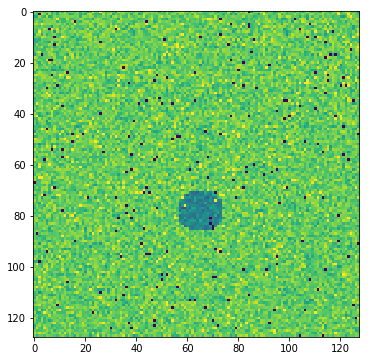

In [70]:
import matplotlib.pyplot as plt
for inputs, classes in test_loader:
    print(inputs[0].shape)

x = plt.imshow(inputs[1][0])

In [74]:
model.eval()
outputs = model(inputs.to(device, dtype=torch.float))

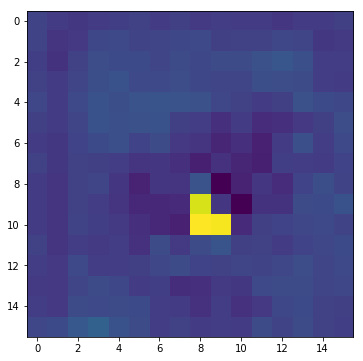

In [75]:
cpu_= outputs[0][1][1].cpu()
cpu_ = cpu_.detach().numpy()
plt.imshow(cpu_)

### Скриншот tensorboard с графиками функции потерь и точности

In [ ]:
# ================================== YOUR CODE HERE ==================================
# ====================================================================================

In [ ]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
x.shape